In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

pd.options.display.max_rows = 3000

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import seaborn as sns
sns.reset_orig()

from scipy.io import arff
from scipy.stats import multivariate_normal, norm, ks_2samp

import glob
import os
from copy import deepcopy
import pickle

import h5py

import timeit
import tqdm

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, auc

from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.ddm import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection.hddm_a import HDDM_A
from skmultiflow.drift_detection.hddm_w import HDDM_W
from skmultiflow.drift_detection.kswin import KSWIN
from skmultiflow.drift_detection.page_hinkley import PageHinkley

In [3]:
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

# R packages
## robseg
robseg = importr("robseg")
## base
base = importr("base")

dollar = base.__dict__["$"]

In [4]:
def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

#def nearPD(A, nit=10):
def nearPD(A, nit=100):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be Identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

In [5]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [6]:
def compute_tau(X, theta, eps=1e-12):
    #N = X.shape[0]
    K = len(theta.pi)
    
    #D = X.shape[1]
    D = X.shape[-1]    
    N = X.shape[-2]
    
    dim_X = len(X.shape)
        
    tau = np.zeros((N, K))
    for k in range(K):
        if D == 1:
            d_k = norm(theta.mu[k], np.sqrt(theta.sigma[k]))
        else:
            #if np.any(np.linalg.eigvals(theta.sigma[k, :, :]) <= 0.0):
            #    theta.sigma[k, :, :] = nearPD(theta.sigma[k, :, :])
            #d_k = multivariate_normal(theta.mu[k, :], theta.sigma[k, :, :])
            try:
                d_k = multivariate_normal(theta.mu[k, :], theta.sigma[k, :, :], 
                                          allow_singular=True)
            except:
                d_k = multivariate_normal(theta.mu[k, :], nearPD(theta.sigma[k, :, :]), 
                                          allow_singular=True)
        
        for i in range(N):
            if dim_X == 3:
                tau[i, k] = theta.pi[k] * d_k.pdf(X[k, i, :])
            elif dim_X == 2:
                tau[i, k] = theta.pi[k] * d_k.pdf(X[i, :])
                
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [7]:
def compute_stat(X, Z):
    #N = X.shape[0]
    K = Z.shape[1]
    #D = X.shape[1]
    
    dim_X = len(X.shape)
    D = X.shape[-1]    
    N = X.shape[-2]
    
    #s1 = np.sum(Z, axis=0, keepdims=True)
    s1 = np.sum(Z.T, axis=1, keepdims=True)
    #s1 = np.mean(Z, axis=0, keepdims=True)
    #print('s1.shape:', s1.shape)
    s2 = X.T.dot(Z).T
    #s2 = np.einsum('kij,ik->kj', X, Z)
    #print('s2.shape:', s2.shape)
    
    if dim_X == 2:
        s3 = np.einsum('ijk,il->ljk', np.array([np.outer(X[i, :], X[i, :]) for i in range(X.shape[0])]), Z)
    else:
        s3 = np.einsum('kijl,ik->kjl', np.array([[np.outer(X[k, i, :], X[k, i, :]) for i in range(X.shape[0])] for k in range(K)]), Z)
    #print('s3.shape:', s3.shape)
    
    return s1, s2, s3

In [8]:
def step_M(s, x, eps=1e-8):
    #print('s.s1')
    #print(s.s1)
    #print('s.s2')
    #print(s.s2)
    #print('s.s3')
    #print(s.s3)

    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)

    #print('pi')
    #print(pi)
    #print('mu')
    #print(mu)
    #print('sigma')
    #print(sigma)
    
    return pi, mu, sigma

In [9]:
class SuffStat:
    def __init__(self):
        pass

In [10]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
        self.s2 = np.random.random((K, D))
        self.s3 = np.random.random((K, D, D))

In [11]:
def calc_falarms_benefit(scores, change_points, start=None, end=None, h=100, T=100, N_thr=100, eps=1e-2):
    scores_max, scores_min = np.nanmax(scores), np.nanmin(scores)
    threshold_list = np.linspace(scores_min - eps, scores_max + eps, N_thr)

    falarms = []
    benefits = []
    
    N = len(scores)
    
    for threshold in threshold_list:
        binary_alarm = (np.array(scores) >= threshold)
        
        benefit = np.zeros(N)
        for cp in change_points:
            if cp < T:
                # t = 0, ... , cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(cp, 0, -1), np.arange(T)))/T
                benefit[:(cp+T)] = values
            elif cp+T > N:
                # t = cp-T, ..., cp, cp+1, ..., N-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(N-cp)))/T
                benefit[(cp-T):] = values
            else:
                # t = cp-T, ..., cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(T)))/T
                benefit[(cp-T):(cp+T)] = values
            
        if start is not None:
            if end is not None:
                benefit = benefit[start:end]
                binary_alarm = binary_alarm[start:end]
            else:
                benefit = benefit[start:]
                binary_alarm = binary_alarm[start:]
        elif end is not None:
            benefit = benefit[:end]
            binary_alarm = binary_alarm[:end]
                
        total_benefit = np.nansum(binary_alarm * benefit)
        n_falarm = np.nansum(binary_alarm * (benefit == 0.0).astype(int))
        
        benefits.append(total_benefit/np.nansum(benefit))
        falarms.append(n_falarm/np.nansum(benefit == 0.0))

    benefits = np.array(benefits)    
    falarms = np.array(falarms)
    
    return falarms, benefits

In [12]:
def calc_auc_main(scores, cps, start, end, T, N_thr=100):
    falarms, benefits = calc_falarms_benefit(scores, cps, start=start, end=end, T=T, N_thr=N_thr)
    
    if np.unique(scores).shape[0] == 2:
        falarms = np.hstack((falarms[0], falarms[1], falarms[1], falarms[1:]))
        benefits = np.hstack((benefits[0], 1.0, benefits[1], benefits[1:]))
    
    auc_ = auc(falarms, benefits)

    return auc_

# SKAB

In [13]:
T_auc = 20
outdir = './output/real/skab_T%s' % (T_auc)
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [14]:
def plot_skab(infile='data/SKAB/data/valve1/0.csv', outfile=None, dpi=200):
    df_skab = pd.read_csv(infile, sep=';')
    X = df_skab.loc[:, 'Accelerometer1RMS':'Volume Flow RateRMS'].values
    
    varnames = ['X%d' % (i+1) for i in range(X.shape[1])]
    X_df = pd.DataFrame(X, columns=varnames)
    print(X_df.describe())
    
    idxes_anomaly = np.where(df_skab['anomaly'].astype(np.int) == 1)[0]
    idxes_change = np.where(df_skab['changepoint'].astype(np.int) == 1)[0]

    fig, axes = plt.subplots(X.shape[1], 1, sharex=True, figsize=(12, 12))
    for j in range(X.shape[1]):
        axes[j].plot(X[:, j])
        for ic in idxes_change:
            axes[j].axvline(x=ic, color='red', linestyle='--')
            
        axes[j].set_ylabel(r'$y_{j}$' % (j+1))
        
    axes[-1].set_xlabel('time')
    
    if not outfile:
        plt.show()
    else:
        plt.savefig(outfile, bbox_inches='tight')
        
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    X_cor = np.corrcoef(X, rowvar=False)
    X_cor_df = pd.DataFrame(X_cor, index=varnames, columns=varnames)
    sns.heatmap(X_cor_df, annot=True, fmt='.3f', ax=ax)
    plt.show()
    
    #fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    sns.pairplot(X_df)
    plt.show()

In [15]:
def plot_skab_with_changespan(infile='data/SKAB/data/valve1/0.csv', outfile=None, dpi=200):
    df_skab = pd.read_csv(infile, sep=';')
    X = df_skab.loc[:, 'Accelerometer1RMS':'Volume Flow RateRMS'].values
    
    varnames = ['X%d' % (i+1) for i in range(X.shape[1])]
    X_df = pd.DataFrame(X, columns=varnames)
    
    idxes_anomaly = np.where(df_skab['anomaly'].astype(np.int) == 1)[0] + 1
    idxes_change = np.where(df_skab['changepoint'].astype(np.int) == 1)[0] + 1
    
    fig, axes = plt.subplots(X.shape[1], 1, sharex=True, figsize=(12, 9))
    for j in range(X.shape[1]):
        axes[j].plot(X[:, j])
        axes[j].xaxis.set_tick_params(which='both', labelbottom=True)
        #axes[j].set_xlabel('time')
        axes[j].set_ylabel(r'$y_{{{:1d}}}$'.format(j+1))
        
        if len(idxes_change) == 4:
            axes[j].axvspan(idxes_change[0], idxes_change[1], color='green', alpha=0.1)
            axes[j].axvspan(idxes_change[1], idxes_change[2], color='red', alpha=0.1)
            axes[j].axvspan(idxes_change[2], idxes_change[3], color='green', alpha=0.1)
        
            axes[j].axvline(x=idxes_change[0], color='red', linestyle='--', zorder=1)
            axes[j].axvline(x=idxes_change[2], color='red', linestyle='--', zorder=1)
        elif len(idxes_change) == 3:
            axes[j].axvline(x=idxes_change[0], color='red', linestyle='--', zorder=1)
            axes[j].axvline(x=idxes_change[1], color='red', linestyle='--', zorder=1)

        #for ic in idxes_change:
        #    axes[j].axvline(x=ic, color='red', linestyle='--')
        #axes[j].set_ylabel(r'$X_{%d}$' % (j+1))
    axes[-1].set_xlabel('time')
    
    plt.tight_layout()
    
    if not outfile:
        plt.show()
    else:
        plt.savefig(outfile, bbox_inches='tight', dpi=dpi)

In [18]:
X_list = []
idxes_change_list = []
for infile in list(infiles_dict_sorted.values()):
    df_skab = pd.read_csv(infile, sep=';')
    X = df_skab.loc[:, 'Accelerometer1RMS':'Volume Flow RateRMS'].values
    #X = X[:, np.hstack((0, np.arange(2, X.shape[1])))]
    X = np.hstack([((X[:, j] - np.mean(X[:20, j]))/np.std(X[:20, j])).reshape(-1, 1) for j in range(X.shape[1])])
    X_list.append(X)
    
    idxes_anomaly = np.where(df_skab['anomaly'].astype(np.int) == 1)[0]
    idxes_change = np.where(df_skab['changepoint'].astype(np.int) == 1)[0]
    print(idxes_change)
    #idxes_change = np.where(df_skab['changepoint'].astype(np.int) == 1)[0][[0, 2]]
    idxes_change = idxes_change[[0, 2]] if len(idxes_change) == 4 else idxes_change[[0, 1]]
    idxes_change_list.append(idxes_change)

[574 631 918 975]
[572 629 916 974]
[566 846 903]
[574 632 919 978]
[573 631 865 922]
[577 635 923 980]
[576 634 922 981]
[578 635 924 983]
[572 629 915 972]
[574 631 917 976]
[573 630 917 974]
[572 630 914 971]
[570 627 912 969]
[570 627 912 969]
[569 626 911 968]
[574 632 920 978]


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np

In [19]:
idxes_change_list

[array([574, 918]),
 array([572, 916]),
 array([566, 846]),
 array([574, 919]),
 array([573, 865]),
 array([577, 923]),
 array([576, 922]),
 array([578, 924]),
 array([572, 915]),
 array([574, 917]),
 array([573, 917]),
 array([572, 914]),
 array([570, 912]),
 array([570, 912]),
 array([569, 911]),
 array([574, 920])]

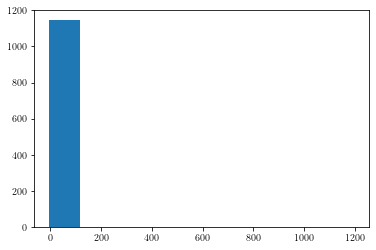

In [20]:
plt.hist(X_list[3][:, 2])
plt.show()

In [21]:
pd.Series(X_list[3][:, 2]).describe()

count    1149.000000
mean        1.130708
std        49.773051
min        -4.402745
25%        -2.286183
50%        -0.823977
75%         0.354567
max      1195.684894
dtype: float64

In [22]:
np.where(X_list[3][:, 2] > 10)[0]

array([337, 494])

In [23]:
pd.Series(X_list[3][:, 6]).describe()

count    1149.000000
mean        0.287629
std         1.117613
min       -20.094831
25%        -0.192751
50%         0.327680
75%         0.872771
max         2.402751
dtype: float64

In [24]:
np.where(X_list[3][:, 6] < -10)[0]

array([494])

## SDEM

In [25]:
class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.pi_list = []
        self.pi_bar_list = []
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_)
        self.covariances_bar = np.copy(self.covariances_)
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[self.t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[self.t]/self.weights_.shape[0] # \overline{\gamma}_i^{(t)} in the paper
        gamma = gamma.ravel()
        self.weights_ = (1-self.r[self.t])*self.weights_ + self.r[self.t]*gamma
        
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            # E-step
            m = (1-self.r[self.t])*m + self.r[self.t]*gamma[i]*x
            cov = (1-self.r[self.t])*cov + self.r[self.t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step
            m = m/w
            cov = cov/w - np.outer(m, m)
            means.append(m)
            covariances.append(cov)

        self.means_ = np.vstack(means) # \mu_i^{(t)} in the paper
        self.covariances_ = np.stack(covariances)
        self.means_bar = np.stack(means_bar)
        self.covariances_bar = np.stack(covariances_bar)
        
        self.pi_list.append(self.weights_)
        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [26]:
def calc_scores_sdem(X, r, n_cluster, alpha=1.0, 
                     X_init=None,
                     init_start=20, init_end=40, score_start=20, seed=0):
    np.random.seed(seed)
    rho_const = np.repeat([r], X.shape[0])
    sdem = SDEM(rho_const, alpha, n_components=n_cluster)

    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    if X_init is None:
        X_init = np.hstack([ np.random.uniform(np.min(X[init_start:init_end, j]), 
                                               np.max(X[init_start:init_end, j]), 
                                               20).reshape(-1, 1) 
                             for j in range(X.shape[1]) ])
    #X_init = X[start:end, :]
    
    sdem.fit(X_init)
    
    for t in range(X.shape[0]):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_bar_list)
    sigma_est = np.array(sdem.covariances_list)
    
    scores = [np.nan] * score_start

    for t in tqdm.tqdm(range(score_start, pi_est.shape[0])):
        p = np.zeros(n_cluster)
        for k in range(n_cluster):
            if np.any(np.linalg.eigvals(sigma_est[t-1, k, :, :]) <= 0.0):
                sigma_est[t-1, k, :, :] = nearPD(sigma_est[t-1, k, :, :])
            if X.shape[0] == 1:
                p_k = pi_est[t-1, k] * norm(mu_est[t-1, k, :], np.sqrt(sigma_est[t-1, k, :, :])).pdf(X[t, :])
            else:
                try:
                    p_k = pi_est[t-1, k] * multivariate_normal(
                        mean=mu_est[t-1, k, :], 
                        cov=sigma_est[t-1, k, :, :], 
                        allow_singular=True
                    ).pdf(
                        X[t, :].reshape(1, -1)
                    )
                except:
                    p_k = pi_est[t-1, k] * multivariate_normal(
                        mean=mu_est[t-1, k, :], 
                        cov=nearPD(sigma_est[t-1, k, :, :]),
                        allow_singular=True
                    ).pdf(
                        X[t, :].reshape(1, -1)
                    )

            p[k] = p_k
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            scores.append(-np.log(p_tot))
        else:
            scores.append(-np.log(-1.0/np.finfo(float).min))
    scores = np.array(scores)
    
    return scores, X_init

In [27]:
#r_list = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1]
#r_list = [0.001, 0.003, 0.005, 0.01, 0.03]
r_list = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]
k_list = [1, 2]

timeit_sdem = np.nan * np.ones((len(r_list), len(k_list), 10))

res_sdem = []

for n, (X, idxes_change) in enumerate(zip(X_list, idxes_change_list)):
    for i, r in enumerate(r_list):
        for j, k in enumerate(k_list):
            trial = 0
            count_success = 0
            #for trial in range(10):
            while count_success < 5:
                seed = i*len(r_list) + j*len(k_list) + trial
                trial += 1
                try:
                    scores_sdem, _ = calc_scores_sdem(X, r, k, 
                                                      init_start=0, init_end=20, 
                                                      score_start=20, 
                                                      alpha=1.0, seed=seed)
                    auc_ = calc_auc_main(scores_sdem, idxes_change, 
                                         start=100, end=X.shape[0], T=T_auc, N_thr=100)
            
                    res_sdem.append([n, r, k, auc_])

                    count_success += 1
                except:
                    continue

In [28]:
res_sdem_df = pd.DataFrame(res_sdem, columns=['n', 'r', 'k', 'auc'])

In [29]:
with open(os.path.join(outdir, 'res_sdem.pkl'), 'wb') as f:
    pickle.dump(res_sdem_df, f)

In [31]:
res_sdem_train_df = res_sdem_df.loc[res_sdem_df['n'] % 2 == 0, :]
res_sdem_test_df = res_sdem_df.loc[res_sdem_df['n'] % 2 == 1, :]

In [32]:
res_sdem_train_df.groupby(['r', 'k'])['auc'].agg(['mean', 'std'])

mean       std
r    k                    
0.01 1  0.565468  0.089293
     2  0.568151  0.091421
0.03 1  0.579564  0.056306
     2  0.563924  0.079466
0.05 1  0.564744  0.062997
     2  0.561127  0.099693
0.10 1  0.543877  0.050887
     2  0.541226  0.098905
0.30 1  0.507612  0.025298
     2  0.528618  0.092975
0.50 1  0.495476  0.023014
     2  0.515269  0.082454

In [33]:
res_sdem_test_df.groupby(['r', 'k'])['auc'].agg(['mean', 'std'])

mean       std
r    k                    
0.01 1  0.549071  0.090909
     2  0.543118  0.110567
0.03 1  0.567313  0.083808
     2  0.574257  0.078830
0.05 1  0.566427  0.073823
     2  0.551000  0.073347
0.10 1  0.556652  0.066118
     2  0.546059  0.076113
0.30 1  0.522645  0.025560
     2  0.506655  0.052315
0.50 1  0.517958  0.017377
     2  0.481608  0.054210

## IEM

In [34]:
def calc_scores_iem(X, n_cluster, alpha=1.0, 
                    X_init=None,
                    init_start=20, init_end=40, 
                    score_start=20,
                    seed=0):
    np.random.seed(seed)
    rhos = 1.0 / np.arange(1, X.shape[0]+1)
    sdem = SDEM(rhos, alpha, n_components=n_cluster)

    #xmin = np.min(X[start:end, :])
    #xmax = np.max(X[start:end, :])
    
    #X_init = np.random.uniform(xmin, xmax, 20).reshape(20, X.shape[1])
    if X_init is None:
        X_init = np.hstack([ np.random.uniform(np.min(X[init_start:init_end, j]), 
                                               np.max(X[init_start:init_end, j]), 
                                               20).reshape(-1, 1) 
                             for j in range(X.shape[1]) ])
    
    sdem.fit(X_init)
    
    for t in tqdm.tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    scores = [np.nan] * score_start

    #n_cluster = pi_est.shape[1]
    for t in range(score_start, X.shape[0]):
        p = np.zeros(n_cluster)
        for k in range(n_cluster):
            if np.any(np.linalg.eigvals(sigma_est[t-1, k, :, :]) <= 0.0):
                sigma_est[t-1, k, :, :] = nearPD(sigma_est[t-1, k, :, :])
            if X.shape[0] == 1:
                p_k = pi_est[t-1, k] * norm(mu_est[t-1, k, :], np.sqrt(sigma_est[t-1, k, :, :])).pdf(X[t, :])
            else:
                try:
                    p_k = pi_est[t-1, k] * multivariate_normal(
                        mean=mu_est[t-1, k, :], 
                        cov=sigma_est[t-1, k, :, :], 
                        allow_singular=True
                    ).pdf(
                        X[t, :].reshape(1, -1)
                    )
                except:
                    p_k = pi_est[t-1, k] * multivariate_normal(
                        mean=mu_est[t-1, k, :], 
                        cov=nearPD(sigma_est[t-1, k, :, :]), 
                        allow_singular=True
                    ).pdf(
                        X[t, :].reshape(1, -1)
                    )
            p[k] = p_k
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            scores.append(-np.log(p_tot))
        else:
            scores.append(np.log(np.finfo(float).max))
    
    scores = np.array(scores)
    
    return scores, X_init

In [35]:
k_list = [1, 2]

res_iem = []

for n, (X, idxes_change) in enumerate(zip(X_list, idxes_change_list)):
    for i, k in enumerate(k_list):
        print('i =', i, 'k =', k)

        trial = 0
        count_success = 0
        #for trial in range(10):
        while count_success < 5:
            seed = i * len(k_list) + trial
            trial += 1
            #try:
            scores_iem, X_init = calc_scores_iem(X, k, 
                                                 init_start=0, init_end=20,
                                                 score_start=50, 
                                                 alpha=1.0, seed=seed)
            auc_ = calc_auc_main(scores_iem, idxes_change, 
                                 start=100, end=X.shape[0], 
                                 T=T_auc, N_thr=100)
            print(auc_)
            res_iem.append([n, k, auc_])

            count_success += 1
            #except:
            #    continue

 30%|██▉       | 343/1148 [00:00<00:00, 3424.48it/s]

i = 0 k = 1


 28%|██▊       | 324/1148 [00:00<00:00, 3232.08it/s]

0.5252010309278351


 32%|███▏      | 366/1148 [00:00<00:00, 3651.74it/s]

0.5252010309278351


 59%|█████▉    | 676/1148 [00:00<00:00, 3254.01it/s]

0.5252010309278351


 31%|███       | 354/1148 [00:00<00:00, 3531.87it/s]

0.5252010309278351


 19%|█▉        | 223/1148 [00:00<00:00, 2229.19it/s]

0.5252010309278351
i = 1 k = 2


 27%|██▋       | 305/1148 [00:00<00:00, 3046.77it/s]

0.5262126288659793


 28%|██▊       | 316/1148 [00:00<00:00, 3151.83it/s]

0.5223782216494846


 25%|██▌       | 288/1148 [00:00<00:00, 2879.22it/s]

0.5282989690721649


 25%|██▌       | 291/1148 [00:00<00:00, 2909.04it/s]

0.5262126288659793


 30%|██▉       | 339/1145 [00:00<00:00, 3384.11it/s]

0.5262126288659793
i = 0 k = 1


 29%|██▉       | 331/1145 [00:00<00:00, 3301.68it/s]

0.7215201654601862


 28%|██▊       | 318/1145 [00:00<00:00, 3176.10it/s]

0.7215201654601862


 25%|██▌       | 289/1145 [00:00<00:00, 2887.49it/s]

0.7215201654601862


 28%|██▊       | 321/1145 [00:00<00:00, 3209.45it/s]

0.7215201654601862


 25%|██▌       | 287/1145 [00:00<00:00, 2861.39it/s]

0.7215201654601862
i = 1 k = 2


 24%|██▍       | 276/1145 [00:00<00:00, 2755.51it/s]

0.7201240951396071


 24%|██▎       | 271/1145 [00:00<00:00, 2706.40it/s]

0.7201240951396071


 25%|██▍       | 286/1145 [00:00<00:00, 2852.53it/s]

0.7201240951396071


 21%|██        | 238/1145 [00:00<00:00, 2372.98it/s]

0.7201240951396071


 31%|███       | 334/1075 [00:00<00:00, 3338.20it/s]

0.7201240951396071
i = 0 k = 1


 29%|██▉       | 316/1075 [00:00<00:00, 3155.68it/s]

0.5153079710144928


 61%|██████▏   | 660/1075 [00:00<00:00, 3046.02it/s]

0.5153079710144928


 31%|███       | 335/1075 [00:00<00:00, 3343.59it/s]

0.5153079710144928


 32%|███▏      | 346/1075 [00:00<00:00, 3455.40it/s]

0.5153079710144928


 26%|██▌       | 275/1075 [00:00<00:00, 2745.64it/s]

0.5153079710144928
i = 1 k = 2


 25%|██▌       | 271/1075 [00:00<00:00, 2708.81it/s]

0.5144767279821628


 27%|██▋       | 285/1075 [00:00<00:00, 2843.72it/s]

0.5357176700111483


 23%|██▎       | 245/1075 [00:00<00:00, 2447.21it/s]

0.5337973801560758


 26%|██▌       | 275/1075 [00:00<00:00, 2749.90it/s]

0.5144767279821628


 56%|█████▋    | 648/1149 [00:00<00:00, 3015.95it/s]

0.5144767279821628
i = 0 k = 1


 24%|██▍       | 273/1149 [00:00<00:00, 2721.97it/s]

0.4966761071060762


 21%|██        | 239/1149 [00:00<00:00, 2379.70it/s]

0.4966761071060762


 26%|██▌       | 294/1149 [00:00<00:00, 2934.46it/s]

0.4966761071060762


 26%|██▌       | 295/1149 [00:00<00:00, 2947.09it/s]

0.4966761071060762


 22%|██▏       | 255/1149 [00:00<00:00, 2545.48it/s]

0.4966761071060762
i = 1 k = 2


 22%|██▏       | 257/1149 [00:00<00:00, 2566.20it/s]

0.4982209062821833


 22%|██▏       | 256/1149 [00:00<00:00, 2557.29it/s]

0.4687763903192585


 21%|██▏       | 245/1149 [00:00<00:00, 2445.60it/s]

0.4766992790937178


 22%|██▏       | 250/1149 [00:00<00:00, 2491.25it/s]

0.4982209062821833


 27%|██▋       | 300/1095 [00:00<00:00, 2993.81it/s]

0.4982209062821833
i = 0 k = 1


 27%|██▋       | 294/1095 [00:00<00:00, 2932.75it/s]

0.5799223009814612


 27%|██▋       | 291/1095 [00:00<00:00, 2900.72it/s]

0.5799223009814612


 25%|██▌       | 275/1095 [00:00<00:00, 2744.08it/s]

0.5799223009814612


 28%|██▊       | 307/1095 [00:00<00:00, 3062.40it/s]

0.5799223009814612


 23%|██▎       | 253/1095 [00:00<00:00, 2523.07it/s]

0.5799223009814612
i = 1 k = 2


 22%|██▏       | 241/1095 [00:00<00:00, 2403.80it/s]

0.5745583424209378


 46%|████▌     | 502/1095 [00:00<00:00, 2494.87it/s]

0.5794179389312978


 22%|██▏       | 245/1095 [00:00<00:00, 2444.46it/s]

0.5794179389312978


 23%|██▎       | 250/1095 [00:00<00:00, 2494.19it/s]

0.5794179389312978


 25%|██▌       | 291/1154 [00:00<00:00, 2902.42it/s]

0.587198745910578
i = 0 k = 1


 23%|██▎       | 267/1154 [00:00<00:00, 2669.52it/s]

0.44735143442622954


 26%|██▌       | 299/1154 [00:00<00:00, 2977.92it/s]

0.44735143442622954


 25%|██▌       | 289/1154 [00:00<00:00, 2889.83it/s]

0.44735143442622954


 24%|██▍       | 276/1154 [00:00<00:00, 2757.05it/s]

0.44735143442622954


 21%|██        | 241/1154 [00:00<00:00, 2408.74it/s]

0.44735143442622954
i = 1 k = 2


 21%|██        | 242/1154 [00:00<00:00, 2418.74it/s]

0.4495081967213115


 20%|██        | 234/1154 [00:00<00:00, 2331.63it/s]

0.4453726946721312


 20%|██        | 233/1154 [00:00<00:00, 2328.02it/s]

0.4428003329918032


 22%|██▏       | 249/1154 [00:00<00:00, 2487.24it/s]

0.4481525358606557


 21%|██▏       | 246/1154 [00:00<00:00, 2452.13it/s]

0.45205174180327873
i = 0 k = 1


 21%|██        | 244/1154 [00:00<00:00, 2434.77it/s]

0.4498335040983607


 21%|██        | 244/1154 [00:00<00:00, 2434.36it/s]

0.4498335040983607


 21%|██        | 243/1154 [00:00<00:00, 2427.99it/s]

0.4498335040983607


 21%|██        | 241/1154 [00:00<00:00, 2402.25it/s]

0.4498335040983607


 18%|█▊        | 203/1154 [00:00<00:00, 2011.31it/s]

0.4498335040983607
i = 1 k = 2


 18%|█▊        | 206/1154 [00:00<00:00, 2058.82it/s]

0.4503457991803279


 18%|█▊        | 202/1154 [00:00<00:00, 2013.88it/s]

0.4503457991803279


 18%|█▊        | 203/1154 [00:00<00:00, 2027.49it/s]

0.4503457991803279


 17%|█▋        | 201/1154 [00:00<00:00, 2002.71it/s]

0.4503457991803279


 23%|██▎       | 252/1094 [00:00<00:00, 2518.21it/s]

0.4503457991803279
i = 0 k = 1


 23%|██▎       | 255/1094 [00:00<00:00, 2540.95it/s]

0.48078329694323146


 23%|██▎       | 250/1094 [00:00<00:00, 2490.69it/s]

0.48078329694323146


 20%|██        | 220/1094 [00:00<00:00, 2199.44it/s]

0.48078329694323146


 23%|██▎       | 248/1094 [00:00<00:00, 2478.89it/s]

0.48078329694323146


 19%|█▊        | 204/1094 [00:00<00:00, 2039.80it/s]

0.48078329694323146
i = 1 k = 2


 19%|█▉        | 208/1094 [00:00<00:00, 2079.07it/s]

0.4794411844978166


 19%|█▉        | 212/1094 [00:00<00:00, 2113.56it/s]

0.4794411844978166


 19%|█▊        | 204/1094 [00:00<00:00, 2031.97it/s]

0.4794411844978166


 19%|█▉        | 212/1094 [00:00<00:00, 2115.35it/s]

0.4794411844978166


 22%|██▏       | 253/1144 [00:00<00:00, 2526.24it/s]

0.4794411844978166
i = 0 k = 1


 21%|██        | 238/1144 [00:00<00:00, 2371.61it/s]

0.6300866977225673


 24%|██▎       | 270/1144 [00:00<00:00, 2699.13it/s]

0.6300866977225673


 22%|██▏       | 249/1144 [00:00<00:00, 2488.70it/s]

0.6300866977225673


 20%|██        | 230/1144 [00:00<00:00, 2293.33it/s]

0.6300866977225673


 20%|█▉        | 225/1144 [00:00<00:00, 2240.72it/s]

0.6300866977225673
i = 1 k = 2


 19%|█▉        | 221/1144 [00:00<00:00, 2202.51it/s]

0.631383281573499


 22%|██▏       | 248/1144 [00:00<00:00, 2472.77it/s]

0.5671862060041408


 21%|██▏       | 244/1144 [00:00<00:00, 2439.41it/s]

0.631383281573499


 22%|██▏       | 246/1144 [00:00<00:00, 2449.47it/s]

0.631383281573499


 24%|██▍       | 277/1148 [00:00<00:00, 2765.19it/s]

0.6305188923395445
i = 0 k = 1


 28%|██▊       | 322/1148 [00:00<00:00, 3212.90it/s]

0.5701404639175256


 26%|██▋       | 303/1148 [00:00<00:00, 3020.30it/s]

0.5701404639175256


 24%|██▍       | 276/1148 [00:00<00:00, 2757.24it/s]

0.5701404639175256


 25%|██▌       | 292/1148 [00:00<00:00, 2911.53it/s]

0.5701404639175256


 24%|██▍       | 279/1148 [00:00<00:00, 2782.57it/s]

0.5701404639175256
i = 1 k = 2


 25%|██▍       | 282/1148 [00:00<00:00, 2814.43it/s]

0.5823904639175258


 24%|██▍       | 278/1148 [00:00<00:00, 2779.14it/s]

0.5747448453608246


 24%|██▍       | 279/1148 [00:00<00:00, 2786.80it/s]

0.5545077319587629


 26%|██▌       | 298/1148 [00:00<00:00, 2976.78it/s]

0.5747448453608246


 61%|██████    | 694/1146 [00:00<00:00, 3142.34it/s]

0.49223002577319586
i = 0 k = 1


 29%|██▉       | 336/1146 [00:00<00:00, 3353.40it/s]

0.6107857696280992


 30%|██▉       | 340/1146 [00:00<00:00, 3394.44it/s]

0.6107857696280992


 30%|██▉       | 339/1146 [00:00<00:00, 3382.13it/s]

0.6107857696280992


 26%|██▋       | 302/1146 [00:00<00:00, 3018.55it/s]

0.6107857696280992


 25%|██▍       | 285/1146 [00:00<00:00, 2849.91it/s]

0.6107857696280992
i = 1 k = 2


 25%|██▍       | 286/1146 [00:00<00:00, 2850.82it/s]

0.6089830836776859


 24%|██▍       | 280/1146 [00:00<00:00, 2797.62it/s]

0.6941225464876033


 25%|██▌       | 290/1146 [00:00<00:00, 2896.38it/s]

0.6089830836776859


 25%|██▍       | 284/1146 [00:00<00:00, 2836.77it/s]

0.6089830836776859


 30%|██▉       | 337/1141 [00:00<00:00, 3367.47it/s]

0.6089830836776859
i = 0 k = 1


 28%|██▊       | 314/1141 [00:00<00:00, 3136.61it/s]

0.371166277258567


 27%|██▋       | 305/1141 [00:00<00:00, 3049.46it/s]

0.371166277258567


 30%|███       | 343/1141 [00:00<00:00, 3419.71it/s]

0.371166277258567


 57%|█████▋    | 652/1141 [00:00<00:00, 3045.72it/s]

0.371166277258567


 24%|██▍       | 274/1141 [00:00<00:00, 2738.27it/s]

0.371166277258567
i = 1 k = 2


 50%|████▉     | 565/1141 [00:00<00:00, 2820.65it/s]

0.37227414330218067


 25%|██▌       | 288/1141 [00:00<00:00, 2870.82it/s]

0.39755581516095534


 26%|██▋       | 300/1141 [00:00<00:00, 2991.00it/s]

0.37227414330218067


 27%|██▋       | 305/1141 [00:00<00:00, 3046.56it/s]

0.37227414330218067


 31%|███       | 351/1140 [00:00<00:00, 3497.34it/s]

0.41334047248182765
i = 0 k = 1


 29%|██▊       | 326/1140 [00:00<00:00, 3259.41it/s]

0.6402280405405405


 32%|███▏      | 367/1140 [00:00<00:00, 3663.60it/s]

0.6402280405405405


 31%|███▏      | 358/1140 [00:00<00:00, 3570.96it/s]

0.6402280405405405


 31%|███       | 350/1140 [00:00<00:00, 3492.73it/s]

0.6402280405405405


 52%|█████▏    | 594/1140 [00:00<00:00, 2969.95it/s]

0.6402280405405405
i = 1 k = 2


 24%|██▍       | 274/1140 [00:00<00:00, 2730.85it/s]

0.6409569906444906


 26%|██▌       | 291/1140 [00:00<00:00, 2903.81it/s]

0.6409569906444906


 26%|██▌       | 292/1140 [00:00<00:00, 2914.26it/s]

0.6409569906444906


 25%|██▌       | 290/1140 [00:00<00:00, 2898.77it/s]

0.6409569906444906


 31%|███       | 348/1140 [00:00<00:00, 3474.35it/s]

0.6409569906444906
i = 0 k = 1


 62%|██████▏   | 706/1140 [00:00<00:00, 3239.52it/s]

0.4219484147609148


 31%|███       | 356/1140 [00:00<00:00, 3550.09it/s]

0.4219484147609148


 31%|███       | 351/1140 [00:00<00:00, 3507.30it/s]

0.4219484147609148


 31%|███       | 356/1140 [00:00<00:00, 3552.96it/s]

0.4219484147609148


 25%|██▌       | 286/1140 [00:00<00:00, 2856.97it/s]

0.4219484147609148
i = 1 k = 2


 25%|██▌       | 290/1140 [00:00<00:00, 2894.32it/s]

0.4243457640332641


 26%|██▌       | 292/1140 [00:00<00:00, 2919.70it/s]

0.40847518191268195


 26%|██▌       | 291/1140 [00:00<00:00, 2908.46it/s]

0.4243457640332641


 26%|██▌       | 296/1140 [00:00<00:00, 2952.86it/s]

0.4243457640332641


 30%|██▉       | 340/1139 [00:00<00:00, 3396.50it/s]

0.4243457640332641
i = 0 k = 1


 27%|██▋       | 309/1139 [00:00<00:00, 3085.34it/s]

0.5155267950052029


 31%|███▏      | 358/1139 [00:00<00:00, 3575.21it/s]

0.5155267950052029


 32%|███▏      | 366/1139 [00:00<00:00, 3659.34it/s]

0.5155267950052029


 32%|███▏      | 365/1139 [00:00<00:00, 3645.66it/s]

0.5155267950052029


 27%|██▋       | 302/1139 [00:00<00:00, 3015.06it/s]

0.5155267950052029
i = 1 k = 2


 52%|█████▏    | 595/1139 [00:00<00:00, 2969.22it/s]

0.5151313735691988


 26%|██▋       | 301/1139 [00:00<00:00, 3004.74it/s]

0.5151313735691988


 27%|██▋       | 308/1139 [00:00<00:00, 3071.90it/s]

0.5151313735691988


 26%|██▋       | 300/1139 [00:00<00:00, 2998.41it/s]

0.5151313735691988


 32%|███▏      | 363/1150 [00:00<00:00, 3622.97it/s]

0.5151313735691988
i = 0 k = 1


 32%|███▏      | 363/1150 [00:00<00:00, 3627.39it/s]

0.7213316615226337


 32%|███▏      | 363/1150 [00:00<00:00, 3628.88it/s]

0.7213316615226337


 30%|██▉       | 340/1150 [00:00<00:00, 3396.34it/s]

0.7213316615226337


 61%|██████    | 700/1150 [00:00<00:00, 3250.15it/s]

0.7213316615226337


 26%|██▋       | 304/1150 [00:00<00:00, 3031.84it/s]

0.7213316615226337
i = 1 k = 2


 26%|██▋       | 303/1150 [00:00<00:00, 3019.61it/s]

0.7216300154320987


 27%|██▋       | 310/1150 [00:00<00:00, 3099.72it/s]

0.7085570987654322


 22%|██▏       | 249/1150 [00:00<00:00, 2488.88it/s]

0.7298488940329217


 27%|██▋       | 305/1150 [00:00<00:00, 3048.48it/s]

0.7216300154320987


100%|██████████| 1150/1150 [00:00<00:00, 3101.37it/s]


0.7401864711934156


In [36]:
res_iem_df = pd.DataFrame(res_iem, columns=['n', 'k', 'auc'])

In [37]:
with open(os.path.join(outdir, 'res_iem.pkl'), 'wb') as f:
    pickle.dump(res_iem_df, f)

In [38]:
res_iem_df.groupby(['k'])['auc'].agg([np.mean, np.std])

,mean,std
k,,
1,0.543613,0.099766
2,0.543828,0.099831


In [39]:
res_iem_train_df = res_iem_df.loc[res_iem_df['n'] % 2 == 0, :]
res_iem_test_df = res_iem_df.loc[res_iem_df['n'] % 2 == 1, :]

In [40]:
res_iem_train_df.groupby(['k'])['auc'].agg([np.mean, np.std])

,mean,std
k,,
1,0.558362,0.063676
2,0.559909,0.065295


In [41]:
res_iem_test_df.groupby(['k'])['auc'].agg([np.mean, np.std])

,mean,std
k,,
1,0.528865,0.125144
2,0.527747,0.124074


## sEM

In [42]:
def sem(X, theta0, rho, 
        #X_init, 
        init_start, init_end, 
        score_start, score_end, 
        seed):
    np.random.seed(seed)
    
    #print('X.shape:', X.shape)
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    #print('N =', N)
    #print('D =', D)
    
    theta = deepcopy(theta0)
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    #print('after initializing s:')
    #print('s.s1.shape:', s.s1.shape)
    #print('s.s2.shape:', s.s2.shape)
    #print('s.s3.shape:', s.s3.shape)
    
    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    #if X_init is None:
    #    X_init = np.hstack([ np.random.uniform(np.min(X[init_start:init_end, j]), 
    #                                           np.max(X[init_start:init_end, j]), 
    #                                           20).reshape(-1, 1) 
    #                         for j in range(X.shape[1]) ])
    
    # initialization
    #tau = compute_tau(X_init, theta)
    #s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)
    tau = compute_tau(X[init_start:init_end, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[init_start:init_end, :], tau)
    theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
    pi_est[0, :] = theta.pi.copy()
    mu_est[0, :, :] = theta.mu.copy()
    sigma_est[0, :, :, :] = theta.sigma.copy()
    
    inds = np.arange(N)
    #print('inds.shape:', inds.shape)
    
    #for n in tqdm.tqdm(range(start, N)):
    #for n in tqdm.tqdm(range(score_start, score_end)):
    for n in tqdm.tqdm(range(1, score_end)):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        #print('===========')
        #print('theta.pi')
        #print(theta.pi)
        #print('theta.mu')
        #print(theta.mu)
        #print('theta.sigma')
        #print(theta.sigma)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    return pi_est, mu_est, sigma_est

In [43]:
def calc_scores_sem(X, theta0, 
                    #X_init, 
                    r, k, 
                    init_start=0, init_end=20, 
                    score_start=20, score_end=40, seed=0):
    rho_const = np.repeat([r], X.shape[0])
    pi_est, mu_est, sigma_est = sem(X, theta0, rho_const, 
                                    #X_init,
                                    init_start, init_end, 
                                    score_start, score_end, seed)
    D = X.shape[-1]
    
    scores = [np.nan]*score_start
    for t in range(score_start, pi_est.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            if D == 1:
                p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            else:
                #print('mu_est[t-1, i, :]')
                #print(mu_est[t-1, i, :])
                #print('sigma_est[t-1, i, :, :]')
                #print(sigma_est[t-1, i, :, :])
                #print('X[t, :]')
                #print(X[t, :])
                try:
                    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :],
                                                               allow_singular=True).pdf(X[t, :])
                except:
                    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :]),
                                                               allow_singular=True).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            scores.append(-np.log(p_tot))
        else:
            scores.append(np.log(np.finfo(float).max))
            
    return scores

In [44]:
init_start = 0
init_end = 20

k_list = [1, 2]
#r_list = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]
#r_list = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3]
r_list = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]

res_sem = []

for n, (X, idxes_change) in enumerate(zip(X_list, idxes_change_list)):
    for i, r in enumerate(r_list):
        for j, k in enumerate(k_list):
            print('r =', r, ', k =', k)
            trial = 0
            count_success = 0
            #for trial in range(10):
            #while trial < 10:
            #for trial in range(10):
            #    seed = i*len(r_list) + j*len(k_list) + trial
            while count_success < 5:
                seed = i*len(r_list) + j*len(k_list) + trial
                np.random.seed(seed)

                trial += 1

                try: 
                    pi0 = np.array([1/k] * k).reshape(-1, 1)
                    #pi0 = np.array([1/k] * k)
                    #X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20).reshape(20, X.shape[1])
                    X_init = np.array([np.hstack([ np.random.uniform(
                                                        np.min(X[init_start:init_end, j]), 
                                                        np.max(X[init_start:init_end, j]), 
                                                        20).reshape(-1, 1) 
                                                   for j in range(X.shape[1]) ]) for _ in range(k)])

                    mu0 = np.mean(X_init, axis=1)
                    sigma0 = np.array([np.cov(X_init[kk, :, :], rowvar=False) for kk in range(k)])
                    theta0 = Theta(pi0, mu0, sigma0)

                    #try:
                    scores_sem = calc_scores_sem(X, theta0, 
                                                 #X_init,
                                                 r, k, 
                                                 init_start=0, init_end=20, 
                                                 score_start=20, score_end=X.shape[0], 
                                                 seed=seed)
                    auc_ = calc_auc_main(scores_sem, idxes_change, 
                                         start=100, end=X.shape[0], 
                                         T=T_auc, N_thr=100)
                    print(auc_)

                    res_sem.append([n, r, k, auc_])
                    #print('  train:', auc_train)

                    #trial += 1
                    count_success += 1
                except:
                    continue

 24%|██▍       | 276/1147 [00:00<00:00, 2754.24it/s]

r = 0.01 , k = 1


 24%|██▍       | 280/1147 [00:00<00:00, 2798.74it/s]

0.5002435567010309


 24%|██▍       | 273/1147 [00:00<00:00, 2729.70it/s]

0.5002435567010309


 25%|██▍       | 283/1147 [00:00<00:00, 2826.55it/s]

0.5002435567010309


 25%|██▌       | 289/1147 [00:00<00:00, 2881.50it/s]

0.5002435567010309


 29%|██▉       | 335/1147 [00:00<00:00, 1673.33it/s]

0.5002435567010309
r = 0.01 , k = 2


 15%|█▍        | 168/1147 [00:00<00:00, 1678.57it/s]

0.5025257731958763


 15%|█▍        | 170/1147 [00:00<00:00, 1693.36it/s]

0.5277835051546391


 15%|█▍        | 172/1147 [00:00<00:00, 1718.92it/s]

0.5330837628865979


 15%|█▍        | 169/1147 [00:00<00:00, 1685.08it/s]

0.4924600515463918


 26%|██▌       | 293/1147 [00:00<00:00, 2924.15it/s]

0.5017680412371134
r = 0.03 , k = 1


 25%|██▍       | 285/1147 [00:00<00:00, 2843.15it/s]

0.5619703608247423


 25%|██▍       | 282/1147 [00:00<00:00, 2817.32it/s]

0.5619703608247423


 51%|█████     | 583/1147 [00:00<00:00, 2899.99it/s]

0.5619703608247423


 50%|████▉     | 568/1147 [00:00<00:00, 2844.65it/s]

0.5619703608247423


 15%|█▍        | 172/1147 [00:00<00:00, 1719.79it/s]

0.5619703608247423
r = 0.03 , k = 2


 30%|███       | 348/1147 [00:00<00:00, 1727.86it/s]

0.5690064432989691


 15%|█▌        | 173/1147 [00:00<00:00, 1728.32it/s]

0.5474072164948454


 15%|█▌        | 173/1147 [00:00<00:00, 1726.61it/s]

0.5670869845360825


 15%|█▌        | 175/1147 [00:00<00:00, 1743.60it/s]

0.5569110824742268


 25%|██▌       | 289/1147 [00:00<00:00, 2882.38it/s]

0.5617867268041238
r = 0.05 , k = 1


 24%|██▍       | 276/1147 [00:00<00:00, 2758.81it/s]

0.5782474226804124


 22%|██▏       | 251/1147 [00:00<00:00, 2504.64it/s]

0.5782474226804124


 25%|██▌       | 287/1147 [00:00<00:00, 2862.84it/s]

0.5782474226804124


 23%|██▎       | 266/1147 [00:00<00:00, 2658.78it/s]

0.5782474226804124


 15%|█▍        | 167/1147 [00:00<00:00, 1668.60it/s]

0.5782474226804124
r = 0.05 , k = 2


 14%|█▍        | 164/1147 [00:00<00:00, 1634.21it/s]

0.5579387886597938


 14%|█▎        | 155/1147 [00:00<00:00, 1548.53it/s]

0.5784407216494847


 14%|█▍        | 164/1147 [00:00<00:00, 1632.63it/s]

0.5769780927835052


 14%|█▎        | 156/1147 [00:00<00:00, 1551.46it/s]

0.5185199742268041


 22%|██▏       | 254/1147 [00:00<00:00, 2539.19it/s]

0.5807809278350515
r = 0.1 , k = 1


 20%|█▉        | 229/1147 [00:00<00:00, 2284.47it/s]

0.5302145618556701


 21%|██▏       | 244/1147 [00:00<00:00, 2434.67it/s]

0.5302145618556701


 21%|██        | 243/1147 [00:00<00:00, 2421.45it/s]

0.5302145618556701


 22%|██▏       | 247/1147 [00:00<00:00, 2460.55it/s]

0.5302145618556701


 13%|█▎        | 147/1147 [00:00<00:00, 1467.64it/s]

0.5302145618556701
r = 0.1 , k = 2


 13%|█▎        | 144/1147 [00:00<00:00, 1434.08it/s]

0.5323028350515464


 13%|█▎        | 149/1147 [00:00<00:00, 1489.64it/s]

0.5299465206185566


 12%|█▏        | 142/1147 [00:00<00:00, 1410.97it/s]

0.5299465206185566


 13%|█▎        | 151/1147 [00:00<00:00, 1507.59it/s]

0.6606971649484538


 21%|██▏       | 246/1147 [00:00<00:00, 2457.68it/s]

0.5323015463917526
r = 0.3 , k = 1


 37%|███▋      | 424/1147 [00:00<00:00, 2149.27it/s]

0.5618820876288659


 22%|██▏       | 256/1147 [00:00<00:00, 2548.36it/s]

0.5618820876288659


 21%|██        | 242/1147 [00:00<00:00, 2414.86it/s]

0.5618820876288659


 19%|█▉        | 222/1147 [00:00<00:00, 2216.94it/s]

0.5618820876288659


 11%|█         | 129/1147 [00:00<00:00, 1287.35it/s]

0.5618820876288659
r = 0.3 , k = 2


 13%|█▎        | 145/1147 [00:00<00:00, 1446.24it/s]

0.5618820876288659


  9%|▊         | 99/1147 [00:00<00:01, 983.15it/s]

0.5618820876288659


 11%|█         | 126/1147 [00:00<00:00, 1256.23it/s]

0.5618820876288659


 10%|▉         | 110/1147 [00:00<00:00, 1096.31it/s]

0.5639175257731959


 21%|██▏       | 244/1147 [00:00<00:00, 2430.60it/s]

0.5618820876288659
r = 0.5 , k = 1


 21%|██        | 237/1147 [00:00<00:00, 2356.13it/s]

0.5530927835051547


 21%|██        | 238/1147 [00:00<00:00, 2379.05it/s]

0.5530927835051547


 20%|██        | 235/1147 [00:00<00:00, 2342.06it/s]

0.5530927835051547


 18%|█▊        | 202/1147 [00:00<00:00, 2011.01it/s]

0.5530927835051547


 12%|█▏        | 140/1147 [00:00<00:00, 1393.39it/s]

0.5530927835051547
r = 0.5 , k = 2


 10%|▉         | 110/1147 [00:00<00:00, 1098.08it/s]

0.5


 12%|█▏        | 136/1147 [00:00<00:00, 1352.21it/s]

0.5258324742268041


 12%|█▏        | 138/1147 [00:00<00:00, 1373.54it/s]

0.5041237113402062


 12%|█▏        | 135/1147 [00:00<00:00, 1346.50it/s]

0.5


 19%|█▊        | 213/1144 [00:00<00:00, 2119.02it/s]

0.5
r = 0.01 , k = 1


 19%|█▊        | 213/1144 [00:00<00:00, 2129.19it/s]

0.5542412099276112


 15%|█▌        | 173/1144 [00:00<00:00, 1715.85it/s]

0.5542412099276112


 18%|█▊        | 203/1144 [00:00<00:00, 2022.76it/s]

0.5542412099276112


 34%|███▍      | 393/1144 [00:00<00:00, 1959.67it/s]

0.5542412099276112


 10%|█         | 115/1144 [00:00<00:00, 1141.63it/s]

0.5542412099276112
r = 0.01 , k = 2


 10%|█         | 118/1144 [00:00<00:00, 1176.66it/s]

0.5633641416752844


  9%|▉         | 108/1144 [00:00<00:00, 1075.68it/s]

0.5702352637021716


 10%|▉         | 110/1144 [00:00<00:00, 1099.06it/s]

0.5671503360910032


 10%|█         | 117/1144 [00:00<00:00, 1160.96it/s]

0.5624741468459151


 18%|█▊        | 203/1144 [00:00<00:00, 2026.07it/s]

0.5592269906928645
r = 0.03 , k = 1


 34%|███▎      | 385/1144 [00:00<00:00, 1926.97it/s]

0.6153516028955532


 18%|█▊        | 204/1144 [00:00<00:00, 2036.29it/s]

0.6153516028955532


 18%|█▊        | 202/1144 [00:00<00:00, 2019.76it/s]

0.6153516028955532


 17%|█▋        | 197/1144 [00:00<00:00, 1968.46it/s]

0.6153516028955532


 10%|▉         | 112/1144 [00:00<00:00, 1114.56it/s]

0.6153516028955532
r = 0.03 , k = 2


 10%|▉         | 110/1144 [00:00<00:00, 1095.05it/s]

0.6115751034126163


 20%|██        | 230/1144 [00:00<00:00, 1142.88it/s]

0.6333369958634952


 10%|█         | 120/1144 [00:00<00:00, 1193.96it/s]

0.6169040847983454


 11%|█         | 126/1144 [00:00<00:00, 1254.32it/s]

0.6304272233712512


 18%|█▊        | 211/1144 [00:00<00:00, 2100.80it/s]

0.6389167528438471
r = 0.05 , k = 1


 19%|█▉        | 219/1144 [00:00<00:00, 2186.57it/s]

0.6200355480868667


 19%|█▉        | 222/1144 [00:00<00:00, 2208.97it/s]

0.6200355480868667


 20%|█▉        | 227/1144 [00:00<00:00, 2262.54it/s]

0.6200355480868667


 39%|███▉      | 447/1144 [00:00<00:00, 2226.83it/s]

0.6200355480868667


 11%|█▏        | 130/1144 [00:00<00:00, 1296.75it/s]

0.6200355480868667
r = 0.05 , k = 2


 12%|█▏        | 134/1144 [00:00<00:00, 1335.59it/s]

0.6454375646328852


 11%|█         | 125/1144 [00:00<00:00, 1242.78it/s]

0.6211911840744572


 13%|█▎        | 150/1144 [00:00<00:00, 1497.93it/s]

0.6200355480868667


 13%|█▎        | 148/1144 [00:00<00:00, 1471.39it/s]

0.6200355480868667


 22%|██▏       | 253/1144 [00:00<00:00, 2522.23it/s]

0.6195553257497415
r = 0.1 , k = 1


 21%|██▏       | 244/1144 [00:00<00:00, 2431.78it/s]

0.6067767580144778


 39%|███▉      | 448/1144 [00:00<00:00, 2247.17it/s]

0.6067767580144778


 22%|██▏       | 253/1144 [00:00<00:00, 2524.98it/s]

0.6067767580144778


 22%|██▏       | 248/1144 [00:00<00:00, 2472.23it/s]

0.6067767580144778


 13%|█▎        | 147/1144 [00:00<00:00, 1467.87it/s]

0.6067767580144778
r = 0.1 , k = 2


 11%|█         | 128/1144 [00:00<00:00, 1276.42it/s]

0.605026499482937


 12%|█▏        | 136/1144 [00:00<00:00, 1350.58it/s]

0.6067767580144778


 10%|▉         | 112/1144 [00:00<00:00, 1119.48it/s]

0.6067767580144778


 11%|█▏        | 129/1144 [00:00<00:00, 1289.24it/s]

0.6067767580144778


 18%|█▊        | 202/1144 [00:00<00:00, 2009.73it/s]

0.6067767580144778
r = 0.3 , k = 1


 21%|██        | 235/1144 [00:00<00:00, 2347.96it/s]

0.5103729317476733


 21%|██        | 235/1144 [00:00<00:00, 2340.64it/s]

0.5103729317476733


 21%|██        | 237/1144 [00:00<00:00, 2365.17it/s]

0.5103729317476733


 20%|█▉        | 227/1144 [00:00<00:00, 2266.51it/s]

0.5103729317476733


 12%|█▏        | 138/1144 [00:00<00:00, 1370.72it/s]

0.5103729317476733
r = 0.3 , k = 2


 24%|██▍       | 280/1144 [00:00<00:00, 1399.64it/s]

0.5103729317476733


 12%|█▏        | 138/1144 [00:00<00:00, 1371.10it/s]

0.5103729317476733


 11%|█         | 125/1144 [00:00<00:00, 1237.10it/s]

0.5103729317476733


 12%|█▏        | 137/1144 [00:00<00:00, 1368.04it/s]

0.5103729317476733


 46%|████▌     | 525/1144 [00:00<00:00, 2625.60it/s]

0.5103729317476733
r = 0.5 , k = 1


 24%|██▍       | 272/1144 [00:00<00:00, 2712.13it/s]

0.5197453464322648


 24%|██▍       | 274/1144 [00:00<00:00, 2734.83it/s]

0.5197453464322648


 24%|██▍       | 276/1144 [00:00<00:00, 2751.66it/s]

0.5197453464322648


 24%|██▍       | 274/1144 [00:00<00:00, 2732.40it/s]

0.5197453464322648


 15%|█▌        | 173/1144 [00:00<00:00, 1724.98it/s]

0.5197453464322648
r = 0.5 , k = 2


 14%|█▍        | 159/1144 [00:00<00:00, 1583.02it/s]

0.5010341261633919


 15%|█▍        | 169/1144 [00:00<00:00, 1684.89it/s]

0.5431418045501551


 15%|█▍        | 171/1144 [00:00<00:00, 1701.85it/s]

0.500517063081696


 14%|█▍        | 164/1144 [00:00<00:00, 1636.75it/s]

0.5


 25%|██▌       | 273/1074 [00:00<00:00, 2728.28it/s]

0.5222337125129266
r = 0.01 , k = 1


 25%|██▌       | 270/1074 [00:00<00:00, 2691.21it/s]

0.4774163879598663


 25%|██▍       | 264/1074 [00:00<00:00, 2632.73it/s]

0.4774163879598663


 24%|██▍       | 261/1074 [00:00<00:00, 2606.87it/s]

0.4774163879598663


 25%|██▍       | 264/1074 [00:00<00:00, 2631.21it/s]

0.4774163879598663


 15%|█▍        | 158/1074 [00:00<00:00, 1571.75it/s]

0.4774163879598663
r = 0.01 , k = 2


 14%|█▍        | 155/1074 [00:00<00:00, 1543.18it/s]

0.49080615942028993


 15%|█▍        | 157/1074 [00:00<00:00, 1559.77it/s]

0.4680595039018952


 15%|█▍        | 158/1074 [00:00<00:00, 1575.93it/s]

0.4743701226309922


 15%|█▍        | 160/1074 [00:00<00:00, 1592.31it/s]

0.4905100334448161


 25%|██▌       | 271/1074 [00:00<00:00, 2704.46it/s]

0.47409489966555185
r = 0.03 , k = 1


 24%|██▎       | 255/1074 [00:00<00:00, 2548.95it/s]

0.5350236900780379


 24%|██▍       | 262/1074 [00:00<00:00, 2612.68it/s]

0.5350236900780379


 25%|██▍       | 265/1074 [00:00<00:00, 2642.03it/s]

0.5350236900780379


 24%|██▍       | 262/1074 [00:00<00:00, 2616.13it/s]

0.5350236900780379


 14%|█▍        | 148/1074 [00:00<00:00, 1471.79it/s]

0.5350236900780379
r = 0.03 , k = 2


 14%|█▍        | 154/1074 [00:00<00:00, 1536.05it/s]

0.5356256967670011


 14%|█▍        | 151/1074 [00:00<00:00, 1506.41it/s]

0.5298836399108138


 15%|█▍        | 161/1074 [00:00<00:00, 1609.87it/s]

0.5362736900780379


 30%|███       | 324/1074 [00:00<00:00, 1618.17it/s]

0.5353769509476032


 25%|██▍       | 268/1074 [00:00<00:00, 2674.09it/s]

0.5337054069119287
r = 0.05 , k = 1


 25%|██▍       | 268/1074 [00:00<00:00, 2671.48it/s]

0.4944913600891862


 25%|██▌       | 273/1074 [00:00<00:00, 2721.39it/s]

0.4944913600891862


 25%|██▌       | 272/1074 [00:00<00:00, 2719.87it/s]

0.4944913600891862


 25%|██▌       | 271/1074 [00:00<00:00, 2705.76it/s]

0.4944913600891862


 15%|█▌        | 162/1074 [00:00<00:00, 1614.51it/s]

0.4944913600891862
r = 0.05 , k = 2


 15%|█▍        | 158/1074 [00:00<00:00, 1576.70it/s]

0.49216694537346717


 15%|█▍        | 160/1074 [00:00<00:00, 1598.45it/s]

0.4912081939799331


 15%|█▍        | 156/1074 [00:00<00:00, 1553.46it/s]

0.48831800445930884


 15%|█▍        | 158/1074 [00:00<00:00, 1577.64it/s]

0.4920234113712375


 22%|██▏       | 238/1074 [00:00<00:00, 2374.44it/s]

0.49150641025641023
r = 0.1 , k = 1


 25%|██▌       | 269/1074 [00:00<00:00, 2680.83it/s]

0.48469272575250844


 23%|██▎       | 251/1074 [00:00<00:00, 2505.96it/s]

0.48469272575250844


 25%|██▌       | 271/1074 [00:00<00:00, 2702.11it/s]

0.48469272575250844


 25%|██▌       | 273/1074 [00:00<00:00, 2728.53it/s]

0.48469272575250844


 15%|█▍        | 157/1074 [00:00<00:00, 1561.85it/s]

0.48469272575250844
r = 0.1 , k = 2


 15%|█▌        | 163/1074 [00:00<00:00, 1628.46it/s]

0.48510869565217396


 15%|█▌        | 162/1074 [00:00<00:00, 1614.54it/s]

0.4822644927536232


 15%|█▌        | 163/1074 [00:00<00:00, 1622.44it/s]

0.48285813823857304


 15%|█▍        | 160/1074 [00:00<00:00, 1592.47it/s]

0.4883333333333333


 25%|██▌       | 272/1074 [00:00<00:00, 2718.80it/s]

0.4861301560758083
r = 0.3 , k = 1


 25%|██▍       | 264/1074 [00:00<00:00, 2630.42it/s]

0.6093102006688964


 24%|██▍       | 263/1074 [00:00<00:00, 2627.60it/s]

0.6093102006688964


 48%|████▊     | 520/1074 [00:00<00:00, 2597.26it/s]

0.6093102006688964


 24%|██▍       | 261/1074 [00:00<00:00, 2602.68it/s]

0.6093102006688964


 14%|█▍        | 152/1074 [00:00<00:00, 1513.42it/s]

0.6093102006688964
r = 0.3 , k = 2


 15%|█▍        | 156/1074 [00:00<00:00, 1552.89it/s]

0.6093102006688964


 14%|█▍        | 152/1074 [00:00<00:00, 1510.11it/s]

0.6093102006688964


 14%|█▍        | 150/1074 [00:00<00:00, 1498.71it/s]

0.6093102006688964


 14%|█▎        | 146/1074 [00:00<00:00, 1456.32it/s]

0.6093102006688964


 25%|██▍       | 265/1074 [00:00<00:00, 2648.73it/s]

0.6093102006688964
r = 0.5 , k = 1


 52%|█████▏    | 560/1074 [00:00<00:00, 2805.28it/s]

0.6031215161649944


 24%|██▍       | 263/1074 [00:00<00:00, 2625.93it/s]

0.6031215161649944


 25%|██▍       | 266/1074 [00:00<00:00, 2657.02it/s]

0.6031215161649944


 49%|████▊     | 521/1074 [00:00<00:00, 2610.38it/s]

0.6031215161649944


 15%|█▌        | 164/1074 [00:00<00:00, 1633.16it/s]

0.6031215161649944
r = 0.5 , k = 2


 14%|█▍        | 153/1074 [00:00<00:00, 1524.43it/s]

0.5


 15%|█▍        | 158/1074 [00:00<00:00, 1578.44it/s]

0.5156075808249722


 15%|█▍        | 157/1074 [00:00<00:00, 1565.72it/s]

0.5011148272017838


 15%|█▍        | 159/1074 [00:00<00:00, 1584.99it/s]

0.5016722408026756


 21%|██▏       | 244/1148 [00:00<00:00, 2434.52it/s]

0.5
r = 0.01 , k = 1


 20%|█▉        | 226/1148 [00:00<00:00, 2253.53it/s]

0.43572605561277034


 41%|████▏     | 475/1148 [00:00<00:00, 2378.84it/s]

0.43572605561277034


 21%|██        | 240/1148 [00:00<00:00, 2391.42it/s]

0.43572605561277034


 20%|██        | 231/1148 [00:00<00:00, 2308.36it/s]

0.43572605561277034


 12%|█▏        | 143/1148 [00:00<00:00, 1424.53it/s]

0.43572605561277034
r = 0.01 , k = 2


 11%|█         | 127/1148 [00:00<00:00, 1266.92it/s]

0.45237062306900094


 12%|█▏        | 137/1148 [00:00<00:00, 1361.13it/s]

0.44738349639546854


 12%|█▏        | 137/1148 [00:00<00:00, 1358.09it/s]

0.4244773429454171


 12%|█▏        | 137/1148 [00:00<00:00, 1361.87it/s]

0.4427993048403707


 20%|██        | 231/1148 [00:00<00:00, 2300.93it/s]

0.4373635427394439
r = 0.03 , k = 1


 39%|███▉      | 448/1148 [00:00<00:00, 2238.13it/s]

0.44271240988671473


 20%|██        | 233/1148 [00:00<00:00, 2328.23it/s]

0.44271240988671473


 20%|██        | 233/1148 [00:00<00:00, 2324.68it/s]

0.44271240988671473


 20%|█▉        | 228/1148 [00:00<00:00, 2279.72it/s]

0.44271240988671473


 11%|█         | 129/1148 [00:00<00:00, 1285.87it/s]

0.44271240988671473
r = 0.03 , k = 2


 23%|██▎       | 267/1148 [00:00<00:00, 1333.34it/s]

0.4450347579814624


 12%|█▏        | 133/1148 [00:00<00:00, 1322.15it/s]

0.4667816683831102


 11%|█▏        | 131/1148 [00:00<00:00, 1304.44it/s]

0.4258708805355304


 12%|█▏        | 133/1148 [00:00<00:00, 1329.76it/s]

0.43204235324407825


 19%|█▉        | 218/1148 [00:00<00:00, 2178.11it/s]

0.43307221936148305
r = 0.05 , k = 1


 17%|█▋        | 198/1148 [00:00<00:00, 1975.36it/s]

0.4737332646755922


 19%|█▉        | 222/1148 [00:00<00:00, 2214.55it/s]

0.4737332646755922


 19%|█▉        | 223/1148 [00:00<00:00, 2222.04it/s]

0.4737332646755922


 20%|██        | 231/1148 [00:00<00:00, 2302.71it/s]

0.4737332646755922


 12%|█▏        | 137/1148 [00:00<00:00, 1361.76it/s]

0.4737332646755922
r = 0.05 , k = 2


 11%|█▏        | 132/1148 [00:00<00:00, 1317.39it/s]

0.44726699279093723


 11%|█▏        | 131/1148 [00:00<00:00, 1307.29it/s]

0.47816297631307925


 11%|█▏        | 130/1148 [00:00<00:00, 1291.37it/s]

0.4757466529351184


 13%|█▎        | 145/1148 [00:00<00:00, 1447.00it/s]

0.4721228115345004


 20%|█▉        | 225/1148 [00:00<00:00, 2247.67it/s]

0.4752433058702369
r = 0.1 , k = 1


 21%|██        | 242/1148 [00:00<00:00, 2410.16it/s]

0.47665872811534504


 19%|█▉        | 222/1148 [00:00<00:00, 2213.60it/s]

0.47665872811534504


 20%|██        | 235/1148 [00:00<00:00, 2342.09it/s]

0.47665872811534504


 21%|██        | 243/1148 [00:00<00:00, 2428.60it/s]

0.47665872811534504


 12%|█▏        | 140/1148 [00:00<00:00, 1398.57it/s]

0.47665872811534504
r = 0.1 , k = 2


 13%|█▎        | 145/1148 [00:00<00:00, 1447.02it/s]

0.47665872811534504


 25%|██▍       | 283/1148 [00:00<00:00, 1416.94it/s]

0.47665872811534504


 13%|█▎        | 144/1148 [00:00<00:00, 1430.54it/s]

0.47665872811534504


 14%|█▎        | 157/1148 [00:00<00:00, 1565.21it/s]

0.47665872811534504


 23%|██▎       | 266/1148 [00:00<00:00, 2654.75it/s]

0.47665872811534504
r = 0.3 , k = 1


 21%|██        | 240/1148 [00:00<00:00, 2390.80it/s]

0.642561148300721


 23%|██▎       | 268/1148 [00:00<00:00, 2678.87it/s]

0.642561148300721


 22%|██▏       | 248/1148 [00:00<00:00, 2472.58it/s]

0.642561148300721


 23%|██▎       | 263/1148 [00:00<00:00, 2619.94it/s]

0.642561148300721


 14%|█▎        | 156/1148 [00:00<00:00, 1554.42it/s]

0.642561148300721
r = 0.3 , k = 2


 13%|█▎        | 153/1148 [00:00<00:00, 1521.44it/s]

0.642561148300721


 14%|█▎        | 157/1148 [00:00<00:00, 1569.69it/s]

0.642561148300721


 14%|█▍        | 162/1148 [00:00<00:00, 1615.73it/s]

0.642561148300721


 14%|█▍        | 163/1148 [00:00<00:00, 1629.89it/s]

0.642561148300721


 50%|████▉     | 571/1148 [00:00<00:00, 2863.09it/s]

0.6367514160659115
r = 0.5 , k = 1


 24%|██▍       | 279/1148 [00:00<00:00, 2789.05it/s]

0.4539875128733264


 26%|██▌       | 296/1148 [00:00<00:00, 2950.11it/s]

0.4539875128733264


 25%|██▍       | 284/1148 [00:00<00:00, 2830.60it/s]

0.4539875128733264


 24%|██▎       | 270/1148 [00:00<00:00, 2699.22it/s]

0.4539875128733264


 15%|█▌        | 173/1148 [00:00<00:00, 1720.51it/s]

0.4539875128733264
r = 0.5 , k = 2


 15%|█▍        | 172/1148 [00:00<00:00, 1713.47it/s]

0.5015447991761071


 15%|█▌        | 174/1148 [00:00<00:00, 1731.81it/s]

0.45698120494335737


 15%|█▍        | 169/1148 [00:00<00:00, 1684.78it/s]

0.515447991761071


 15%|█▌        | 174/1148 [00:00<00:00, 1731.52it/s]

0.5101184346035015


 24%|██▍       | 265/1094 [00:00<00:00, 2640.68it/s]

0.5
r = 0.01 , k = 1


 24%|██▍       | 268/1094 [00:00<00:00, 2671.32it/s]

0.4791841603053435


 24%|██▍       | 267/1094 [00:00<00:00, 2666.91it/s]

0.4791841603053435


 24%|██▍       | 267/1094 [00:00<00:00, 2661.42it/s]

0.4791841603053435


 25%|██▍       | 269/1094 [00:00<00:00, 2680.00it/s]

0.4791841603053435


 14%|█▍        | 158/1094 [00:00<00:00, 1574.46it/s]

0.4791841603053435
r = 0.01 , k = 2


 15%|█▍        | 161/1094 [00:00<00:00, 1602.39it/s]

0.5109514721919302


 14%|█▍        | 157/1094 [00:00<00:00, 1562.50it/s]

0.48922437295528903


 14%|█▍        | 158/1094 [00:00<00:00, 1571.04it/s]

0.515925572519084


 15%|█▍        | 162/1094 [00:00<00:00, 1616.14it/s]

0.5144847328244275


 24%|██▍       | 265/1094 [00:00<00:00, 2649.23it/s]

0.4910059978189749
r = 0.03 , k = 1


 24%|██▍       | 261/1094 [00:00<00:00, 2604.74it/s]

0.5138801799345692


 48%|████▊     | 528/1094 [00:00<00:00, 2614.62it/s]

0.5138801799345692


 23%|██▎       | 254/1094 [00:00<00:00, 2532.56it/s]

0.5138801799345692


 24%|██▍       | 264/1094 [00:00<00:00, 2639.76it/s]

0.5138801799345692


 15%|█▍        | 161/1094 [00:00<00:00, 1606.71it/s]

0.5138801799345692
r = 0.03 , k = 2


 15%|█▌        | 166/1094 [00:00<00:00, 1658.72it/s]

0.5119806434023991


 15%|█▌        | 166/1094 [00:00<00:00, 1657.50it/s]

0.5263992639040349


 15%|█▍        | 160/1094 [00:00<00:00, 1598.03it/s]

0.5146946564885497


 29%|██▊       | 313/1094 [00:00<00:00, 1562.55it/s]

0.528471237731734


 51%|█████▏    | 561/1094 [00:00<00:00, 2802.12it/s]

0.6654321155943294
r = 0.05 , k = 1


 23%|██▎       | 257/1094 [00:00<00:00, 2563.21it/s]

0.5037322791712106


 24%|██▍       | 260/1094 [00:00<00:00, 2599.38it/s]

0.5037322791712106


 24%|██▍       | 263/1094 [00:00<00:00, 2625.20it/s]

0.5037322791712106


 46%|████▌     | 501/1094 [00:00<00:00, 2504.09it/s]

0.5037322791712106


 14%|█▍        | 153/1094 [00:00<00:00, 1529.02it/s]

0.5037322791712106
r = 0.05 , k = 2


 14%|█▍        | 151/1094 [00:00<00:00, 1500.43it/s]

0.5027140130861505


 27%|██▋       | 293/1094 [00:00<00:00, 1464.95it/s]

0.5070815158124319


 13%|█▎        | 145/1094 [00:00<00:00, 1441.71it/s]

0.667918484187568


 13%|█▎        | 140/1094 [00:00<00:00, 1395.83it/s]

0.6750013631406762


 22%|██▏       | 245/1094 [00:00<00:00, 2448.22it/s]

0.5042414122137405
r = 0.1 , k = 1


 21%|██        | 227/1094 [00:00<00:00, 2268.82it/s]

0.5293007088331517


 15%|█▍        | 163/1094 [00:00<00:00, 1622.79it/s]

0.5293007088331517


 20%|██        | 222/1094 [00:00<00:00, 2214.28it/s]

0.5293007088331517


 19%|█▉        | 207/1094 [00:00<00:00, 2065.08it/s]

0.5293007088331517


 12%|█▏        | 127/1094 [00:00<00:00, 1261.71it/s]

0.5293007088331517
r = 0.1 , k = 2


 11%|█         | 117/1094 [00:00<00:00, 1163.98it/s]

0.5293007088331517


 11%|█         | 122/1094 [00:00<00:00, 1215.98it/s]

0.5251983369683753


 11%|█▏        | 125/1094 [00:00<00:00, 1247.76it/s]

0.5211273173391494


 11%|█         | 122/1094 [00:00<00:00, 1219.18it/s]

0.5101097328244275


 20%|█▉        | 215/1094 [00:00<00:00, 2148.33it/s]

0.6620092693565977
r = 0.3 , k = 1


 19%|█▉        | 207/1094 [00:00<00:00, 2060.58it/s]

0.5569152126499455


 19%|█▉        | 209/1094 [00:00<00:00, 2081.79it/s]

0.5569152126499455


 18%|█▊        | 202/1094 [00:00<00:00, 2013.11it/s]

0.5569152126499455


 20%|█▉        | 217/1094 [00:00<00:00, 2168.14it/s]

0.5569152126499455


 11%|█▏        | 125/1094 [00:00<00:00, 1246.20it/s]

0.5569152126499455
r = 0.3 , k = 2


 12%|█▏        | 128/1094 [00:00<00:00, 1272.11it/s]

0.5546905670665213


 12%|█▏        | 132/1094 [00:00<00:00, 1312.77it/s]

0.5570862868047982


 12%|█▏        | 136/1094 [00:00<00:00, 1357.98it/s]

0.5572185114503817


 13%|█▎        | 137/1094 [00:00<00:00, 1362.89it/s]

0.5569152126499455


 23%|██▎       | 252/1094 [00:00<00:00, 2516.86it/s]

0.5572498636859323
r = 0.5 , k = 1


 49%|████▉     | 535/1094 [00:00<00:00, 2681.93it/s]

0.5365321701199564


 24%|██▍       | 261/1094 [00:00<00:00, 2601.23it/s]

0.5365321701199564


 24%|██▍       | 268/1094 [00:00<00:00, 2676.89it/s]

0.5365321701199564


 24%|██▍       | 264/1094 [00:00<00:00, 2632.36it/s]

0.5365321701199564


 15%|█▍        | 163/1094 [00:00<00:00, 1627.43it/s]

0.5365321701199564
r = 0.5 , k = 2


 14%|█▍        | 156/1094 [00:00<00:00, 1554.28it/s]

0.5


 15%|█▍        | 163/1094 [00:00<00:00, 1625.01it/s]

0.539803707742639


 30%|██▉       | 328/1094 [00:00<00:00, 1629.13it/s]

0.5365321701199564


 15%|█▍        | 160/1094 [00:00<00:00, 1594.93it/s]

0.549618320610687


 22%|██▏       | 256/1153 [00:00<00:00, 2552.19it/s]

0.5119956379498365
r = 0.01 , k = 1


 23%|██▎       | 262/1153 [00:00<00:00, 2614.98it/s]

0.5130007684426229


 23%|██▎       | 266/1153 [00:00<00:00, 2656.91it/s]

0.5130007684426229


 22%|██▏       | 254/1153 [00:00<00:00, 2533.91it/s]

0.5130007684426229


 46%|████▋     | 534/1153 [00:00<00:00, 2671.18it/s]

0.5130007684426229


 14%|█▍        | 160/1153 [00:00<00:00, 1592.12it/s]

0.5130007684426229
r = 0.01 , k = 2


 13%|█▎        | 155/1153 [00:00<00:00, 1549.47it/s]

0.5004123975409835


 14%|█▍        | 161/1153 [00:00<00:00, 1603.94it/s]

0.5022758709016394


 14%|█▍        | 163/1153 [00:00<00:00, 1628.54it/s]

0.5078150614754098


 14%|█▎        | 157/1153 [00:00<00:00, 1563.09it/s]

0.4975998975409836


 22%|██▏       | 256/1153 [00:00<00:00, 2552.75it/s]

0.5170030737704918
r = 0.03 , k = 1


 23%|██▎       | 265/1153 [00:00<00:00, 2641.89it/s]

0.4923360655737704


 22%|██▏       | 250/1153 [00:00<00:00, 2495.25it/s]

0.4923360655737704


 24%|██▎       | 271/1153 [00:00<00:00, 2707.78it/s]

0.4923360655737704


 47%|████▋     | 540/1153 [00:00<00:00, 2683.61it/s]

0.4923360655737704


 13%|█▎        | 154/1153 [00:00<00:00, 1535.59it/s]

0.4923360655737704
r = 0.03 , k = 2


 14%|█▍        | 162/1153 [00:00<00:00, 1611.31it/s]

0.5095101178278688


 14%|█▍        | 163/1153 [00:00<00:00, 1620.36it/s]

0.4977049180327868


 14%|█▎        | 157/1153 [00:00<00:00, 1562.34it/s]

0.5131109118852459


 29%|██▊       | 331/1153 [00:00<00:00, 1657.51it/s]

0.5054296875


 23%|██▎       | 267/1153 [00:00<00:00, 2665.39it/s]

0.5101344774590164
r = 0.05 , k = 1


 24%|██▍       | 277/1153 [00:00<00:00, 2762.57it/s]

0.49098552766393444


 24%|██▍       | 282/1153 [00:00<00:00, 2817.43it/s]

0.49098552766393444


 24%|██▍       | 280/1153 [00:00<00:00, 2799.50it/s]

0.49098552766393444


 24%|██▍       | 281/1153 [00:00<00:00, 2804.43it/s]

0.49098552766393444


 14%|█▍        | 163/1153 [00:00<00:00, 1625.04it/s]

0.49098552766393444
r = 0.05 , k = 2


 14%|█▍        | 166/1153 [00:00<00:00, 1654.64it/s]

0.4865074282786885


 14%|█▍        | 163/1153 [00:00<00:00, 1625.55it/s]

0.5050909323770493


 14%|█▍        | 159/1153 [00:00<00:00, 1580.79it/s]

0.4887051741803278


 13%|█▎        | 155/1153 [00:00<00:00, 1549.91it/s]

0.479585681352459


 23%|██▎       | 265/1153 [00:00<00:00, 2642.13it/s]

0.48820824795081974
r = 0.1 , k = 1


 21%|██        | 241/1153 [00:00<00:00, 2406.82it/s]

0.47177190061475416


 22%|██▏       | 249/1153 [00:00<00:00, 2486.84it/s]

0.47177190061475416


 23%|██▎       | 261/1153 [00:00<00:00, 2607.13it/s]

0.47177190061475416


 44%|████▍     | 506/1153 [00:00<00:00, 2506.17it/s]

0.47177190061475416


 13%|█▎        | 147/1153 [00:00<00:00, 1462.09it/s]

0.47177190061475416
r = 0.1 , k = 2


 13%|█▎        | 149/1153 [00:00<00:00, 1481.36it/s]

0.5552311731557377


 13%|█▎        | 150/1153 [00:00<00:00, 1493.89it/s]

0.5598091700819673


 13%|█▎        | 150/1153 [00:00<00:00, 1497.75it/s]

0.47617379610655747


 12%|█▏        | 143/1153 [00:00<00:00, 1426.16it/s]

0.4922938012295082


 21%|██▏       | 246/1153 [00:00<00:00, 2450.74it/s]

0.49801613729508204
r = 0.3 , k = 1


 21%|██▏       | 246/1153 [00:00<00:00, 2459.06it/s]

0.5635271516393442


 43%|████▎     | 494/1153 [00:00<00:00, 2473.19it/s]

0.5635271516393442


 22%|██▏       | 251/1153 [00:00<00:00, 2502.62it/s]

0.5635271516393442


 21%|██▏       | 246/1153 [00:00<00:00, 2454.95it/s]

0.5635271516393442


 13%|█▎        | 152/1153 [00:00<00:00, 1514.92it/s]

0.5635271516393442
r = 0.3 , k = 2


 13%|█▎        | 145/1153 [00:00<00:00, 1446.47it/s]

0.5635271516393442


 13%|█▎        | 149/1153 [00:00<00:00, 1485.71it/s]

0.5635271516393442


 26%|██▌       | 300/1153 [00:00<00:00, 1486.24it/s]

0.5635271516393442


 13%|█▎        | 147/1153 [00:00<00:00, 1469.78it/s]

0.5622047899590163


 24%|██▎       | 272/1153 [00:00<00:00, 2716.19it/s]

0.5604015112704919
r = 0.5 , k = 1


 47%|████▋     | 547/1153 [00:00<00:00, 2732.12it/s]

0.5302254098360656


 24%|██▍       | 278/1153 [00:00<00:00, 2779.00it/s]

0.5302254098360656


 23%|██▎       | 263/1153 [00:00<00:00, 2625.61it/s]

0.5302254098360656


 24%|██▎       | 272/1153 [00:00<00:00, 2715.19it/s]

0.5302254098360656


 14%|█▍        | 162/1153 [00:00<00:00, 1612.76it/s]

0.5302254098360656
r = 0.5 , k = 2


 14%|█▎        | 157/1153 [00:00<00:00, 1565.38it/s]

0.5005122950819672


 13%|█▎        | 151/1153 [00:00<00:00, 1502.58it/s]

0.5081967213114754


 13%|█▎        | 149/1153 [00:00<00:00, 1485.23it/s]

0.5081967213114754


 13%|█▎        | 155/1153 [00:00<00:00, 1545.76it/s]

0.5


 43%|████▎     | 495/1153 [00:00<00:00, 2479.89it/s]

0.5081967213114754
r = 0.01 , k = 1


 22%|██▏       | 254/1153 [00:00<00:00, 2531.47it/s]

0.4299500512295082


 22%|██▏       | 249/1153 [00:00<00:00, 2488.93it/s]

0.4299500512295082


 22%|██▏       | 252/1153 [00:00<00:00, 2513.34it/s]

0.4299500512295082


 21%|██        | 245/1153 [00:00<00:00, 2444.47it/s]

0.4299500512295082


 12%|█▏        | 144/1153 [00:00<00:00, 1438.07it/s]

0.4299500512295082
r = 0.01 , k = 2


 26%|██▌       | 298/1153 [00:00<00:00, 1487.48it/s]

0.4546241034836065


 13%|█▎        | 151/1153 [00:00<00:00, 1507.35it/s]

0.4319973104508196


 13%|█▎        | 148/1153 [00:00<00:00, 1479.60it/s]

0.44756339651639343


 13%|█▎        | 152/1153 [00:00<00:00, 1516.01it/s]

0.44118212090163933


 22%|██▏       | 255/1153 [00:00<00:00, 2538.76it/s]

0.4293711577868853
r = 0.03 , k = 1


 22%|██▏       | 255/1153 [00:00<00:00, 2549.72it/s]

0.4650819672131147


 44%|████▍     | 506/1153 [00:00<00:00, 2508.48it/s]

0.4650819672131147


 22%|██▏       | 255/1153 [00:00<00:00, 2545.80it/s]

0.4650819672131147


 22%|██▏       | 250/1153 [00:00<00:00, 2492.47it/s]

0.4650819672131147


 13%|█▎        | 155/1153 [00:00<00:00, 1547.52it/s]

0.4650819672131147
r = 0.03 , k = 2


 13%|█▎        | 148/1153 [00:00<00:00, 1479.88it/s]

0.4705174180327868


 13%|█▎        | 152/1153 [00:00<00:00, 1516.54it/s]

0.4677055584016394


 13%|█▎        | 149/1153 [00:00<00:00, 1485.74it/s]

0.48036949282786884


 14%|█▎        | 156/1153 [00:00<00:00, 1556.39it/s]

0.4615964395491803


 22%|██▏       | 253/1153 [00:00<00:00, 2524.12it/s]

0.4564177766393443
r = 0.05 , k = 1


 18%|█▊        | 211/1153 [00:00<00:00, 2108.71it/s]

0.5087615266393443


 21%|██        | 239/1153 [00:00<00:00, 2388.18it/s]

0.5087615266393443


 20%|██        | 232/1153 [00:00<00:00, 2312.35it/s]

0.5087615266393443


 21%|██        | 243/1153 [00:00<00:00, 2427.67it/s]

0.5087615266393443


 11%|█▏        | 130/1153 [00:00<00:00, 1295.19it/s]

0.5087615266393443
r = 0.05 , k = 2


 13%|█▎        | 146/1153 [00:00<00:00, 1456.00it/s]

0.5266348616803278


 12%|█▏        | 135/1153 [00:00<00:00, 1345.48it/s]

0.5266662397540984


 12%|█▏        | 135/1153 [00:00<00:00, 1349.92it/s]

0.524906506147541


 12%|█▏        | 136/1153 [00:00<00:00, 1346.65it/s]

0.5266662397540984


 40%|███▉      | 460/1153 [00:00<00:00, 2285.84it/s]

0.49949218750000013
r = 0.1 , k = 1


 19%|█▉        | 217/1153 [00:00<00:00, 2157.87it/s]

0.5341630379098361


 19%|█▉        | 220/1153 [00:00<00:00, 2195.04it/s]

0.5341630379098361


 19%|█▊        | 215/1153 [00:00<00:00, 2147.96it/s]

0.5341630379098361


 20%|█▉        | 225/1153 [00:00<00:00, 2243.62it/s]

0.5341630379098361


 12%|█▏        | 136/1153 [00:00<00:00, 1350.74it/s]

0.5341630379098361
r = 0.1 , k = 2


 12%|█▏        | 136/1153 [00:00<00:00, 1358.78it/s]

0.5309413422131147


 12%|█▏        | 135/1153 [00:00<00:00, 1349.39it/s]

0.5309413422131147


 12%|█▏        | 136/1153 [00:00<00:00, 1350.33it/s]

0.5392181096311475


 12%|█▏        | 140/1153 [00:00<00:00, 1391.79it/s]

0.5341630379098361


 21%|██        | 240/1153 [00:00<00:00, 2395.93it/s]

0.5371939036885246
r = 0.3 , k = 1


 21%|██        | 245/1153 [00:00<00:00, 2443.33it/s]

0.5358414446721311


 21%|██▏       | 246/1153 [00:00<00:00, 2455.68it/s]

0.5358414446721311


 21%|██        | 244/1153 [00:00<00:00, 2433.19it/s]

0.5358414446721311


 22%|██▏       | 251/1153 [00:00<00:00, 2506.87it/s]

0.5358414446721311


 13%|█▎        | 151/1153 [00:00<00:00, 1507.50it/s]

0.5358414446721311
r = 0.3 , k = 2


 13%|█▎        | 151/1153 [00:00<00:00, 1501.02it/s]

0.5358414446721311


 14%|█▎        | 157/1153 [00:00<00:00, 1567.48it/s]

0.5358414446721311


 14%|█▎        | 157/1153 [00:00<00:00, 1568.71it/s]

0.5358414446721311


 14%|█▍        | 159/1153 [00:00<00:00, 1583.76it/s]

0.5358414446721311


 23%|██▎       | 266/1153 [00:00<00:00, 2654.56it/s]

0.43619620901639344
r = 0.5 , k = 1


 48%|████▊     | 548/1153 [00:00<00:00, 2735.61it/s]

0.4416822489754098


 48%|████▊     | 554/1153 [00:00<00:00, 2770.32it/s]

0.4416822489754098


 23%|██▎       | 263/1153 [00:00<00:00, 2629.55it/s]

0.4416822489754098


 49%|████▊     | 561/1153 [00:00<00:00, 2804.00it/s]

0.4416822489754098


 14%|█▍        | 167/1153 [00:00<00:00, 1662.23it/s]

0.4416822489754098
r = 0.5 , k = 2


 14%|█▍        | 160/1153 [00:00<00:00, 1594.30it/s]

0.5005122950819672


 14%|█▍        | 163/1153 [00:00<00:00, 1621.14it/s]

0.5158017418032786


 13%|█▎        | 155/1153 [00:00<00:00, 1543.44it/s]

0.5020491803278688


 14%|█▍        | 165/1153 [00:00<00:00, 1647.22it/s]

0.5


 47%|████▋     | 510/1093 [00:00<00:00, 2528.95it/s]

0.5005122950819672
r = 0.01 , k = 1


 22%|██▏       | 242/1093 [00:00<00:00, 2414.81it/s]

0.42650723253275113


 24%|██▍       | 262/1093 [00:00<00:00, 2618.01it/s]

0.42650723253275113


 24%|██▍       | 266/1093 [00:00<00:00, 2657.02it/s]

0.42650723253275113


 24%|██▍       | 264/1093 [00:00<00:00, 2635.54it/s]

0.42650723253275113


 14%|█▍        | 154/1093 [00:00<00:00, 1533.51it/s]

0.42650723253275113
r = 0.01 , k = 2


 13%|█▎        | 147/1093 [00:00<00:00, 1465.62it/s]

0.4234299945414848


 13%|█▎        | 145/1093 [00:00<00:00, 1441.85it/s]

0.42882096069868997


 14%|█▎        | 150/1093 [00:00<00:00, 1498.40it/s]

0.42353916484716153


 14%|█▍        | 152/1093 [00:00<00:00, 1510.99it/s]

0.4332355349344978


 22%|██▏       | 245/1093 [00:00<00:00, 2442.46it/s]

0.458123635371179
r = 0.03 , k = 1


 23%|██▎       | 250/1093 [00:00<00:00, 2498.10it/s]

0.5098799126637555


 23%|██▎       | 253/1093 [00:00<00:00, 2524.57it/s]

0.5098799126637555


 46%|████▋     | 506/1093 [00:00<00:00, 2410.63it/s]

0.5098799126637555


 23%|██▎       | 249/1093 [00:00<00:00, 2484.91it/s]

0.5098799126637555


 13%|█▎        | 145/1093 [00:00<00:00, 1446.79it/s]

0.5098799126637555
r = 0.03 , k = 2


 14%|█▎        | 148/1093 [00:00<00:00, 1474.53it/s]

0.49052265283842794


 14%|█▍        | 153/1093 [00:00<00:00, 1527.28it/s]

0.5244875818777291


 14%|█▍        | 152/1093 [00:00<00:00, 1519.30it/s]

0.5106707150655022


 28%|██▊       | 307/1093 [00:00<00:00, 1529.29it/s]

0.5153131823144105


 23%|██▎       | 253/1093 [00:00<00:00, 2520.57it/s]

0.5308740447598254
r = 0.05 , k = 1


 46%|████▌     | 498/1093 [00:00<00:00, 2486.71it/s]

0.5344377729257641


 23%|██▎       | 255/1093 [00:00<00:00, 2546.36it/s]

0.5344377729257641


 23%|██▎       | 251/1093 [00:00<00:00, 2506.56it/s]

0.5344377729257641


 24%|██▎       | 258/1093 [00:00<00:00, 2570.69it/s]

0.5344377729257641


 14%|█▍        | 151/1093 [00:00<00:00, 1507.61it/s]

0.5344377729257641
r = 0.05 , k = 2


 14%|█▎        | 150/1093 [00:00<00:00, 1494.23it/s]

0.5121465611353712


 13%|█▎        | 147/1093 [00:00<00:00, 1465.88it/s]

0.5167890283842794


 14%|█▎        | 150/1093 [00:00<00:00, 1498.59it/s]

0.5349536026200874


 14%|█▍        | 157/1093 [00:00<00:00, 1568.77it/s]

0.5355287936681222


 47%|████▋     | 518/1093 [00:00<00:00, 2581.85it/s]

0.5167890283842794
r = 0.1 , k = 1


 24%|██▍       | 263/1093 [00:00<00:00, 2626.85it/s]

0.5386135371179038


 24%|██▍       | 267/1093 [00:00<00:00, 2666.99it/s]

0.5386135371179038


 24%|██▍       | 262/1093 [00:00<00:00, 2618.17it/s]

0.5386135371179038


 47%|████▋     | 517/1093 [00:00<00:00, 2582.75it/s]

0.5386135371179038


 14%|█▍        | 154/1093 [00:00<00:00, 1531.54it/s]

0.5386135371179038
r = 0.1 , k = 2


 14%|█▍        | 158/1093 [00:00<00:00, 1571.68it/s]

0.5386135371179038


 15%|█▍        | 162/1093 [00:00<00:00, 1610.95it/s]

0.5386135371179038


 15%|█▌        | 164/1093 [00:00<00:00, 1634.91it/s]

0.5386135371179038


 28%|██▊       | 302/1093 [00:00<00:00, 1523.56it/s]

0.5386135371179038


 24%|██▍       | 261/1093 [00:00<00:00, 2606.99it/s]

0.5386135371179038
r = 0.3 , k = 1


 25%|██▍       | 268/1093 [00:00<00:00, 2679.81it/s]

0.5277476801310044


 25%|██▌       | 275/1093 [00:00<00:00, 2740.38it/s]

0.5277476801310044


 25%|██▍       | 273/1093 [00:00<00:00, 2721.45it/s]

0.5277476801310044


 25%|██▍       | 271/1093 [00:00<00:00, 2703.78it/s]

0.5277476801310044


 14%|█▍        | 155/1093 [00:00<00:00, 1545.59it/s]

0.5277476801310044
r = 0.3 , k = 2


 15%|█▌        | 164/1093 [00:00<00:00, 1633.50it/s]

0.5277476801310044


 15%|█▍        | 162/1093 [00:00<00:00, 1612.59it/s]

0.5277476801310044


 15%|█▍        | 161/1093 [00:00<00:00, 1601.41it/s]

0.5277476801310044


 15%|█▌        | 168/1093 [00:00<00:00, 1676.93it/s]

0.5277476801310044


 28%|██▊       | 301/1093 [00:00<00:00, 3003.97it/s]

0.5277476801310044
r = 0.5 , k = 1


 55%|█████▌    | 604/1093 [00:00<00:00, 3017.44it/s]

0.6058201419213973


 55%|█████▌    | 602/1093 [00:00<00:00, 3007.50it/s]

0.6058201419213973


 54%|█████▍    | 589/1093 [00:00<00:00, 2945.29it/s]

0.6058201419213973


 27%|██▋       | 300/1093 [00:00<00:00, 2992.34it/s]

0.6058201419213973


 16%|█▌        | 172/1093 [00:00<00:00, 1718.57it/s]

0.6058201419213973
r = 0.5 , k = 2


 14%|█▍        | 157/1093 [00:00<00:00, 1569.47it/s]

0.5010917030567685


 15%|█▌        | 166/1093 [00:00<00:00, 1652.58it/s]

0.6057239355895196


 32%|███▏      | 349/1093 [00:00<00:00, 1743.20it/s]

0.5


 15%|█▌        | 166/1093 [00:00<00:00, 1655.89it/s]

0.5


 22%|██▏       | 256/1143 [00:00<00:00, 2552.93it/s]

0.5005458515283843
r = 0.01 , k = 1


 20%|██        | 234/1143 [00:00<00:00, 2328.48it/s]

0.5650420548654245


 45%|████▍     | 514/1143 [00:00<00:00, 2536.91it/s]

0.5650420548654245


 22%|██▏       | 256/1143 [00:00<00:00, 2557.14it/s]

0.5650420548654245


 23%|██▎       | 262/1143 [00:00<00:00, 2610.91it/s]

0.5650420548654245


 13%|█▎        | 151/1143 [00:00<00:00, 1507.73it/s]

0.5650420548654245
r = 0.01 , k = 2


 26%|██▌       | 299/1143 [00:00<00:00, 1488.95it/s]

0.5581211180124224


 13%|█▎        | 144/1143 [00:00<00:00, 1431.95it/s]

0.563871635610766


 25%|██▍       | 284/1143 [00:00<00:00, 1427.33it/s]

0.5573828933747411


 12%|█▏        | 137/1143 [00:00<00:00, 1363.43it/s]

0.5590314440993789


 22%|██▏       | 250/1143 [00:00<00:00, 2494.93it/s]

0.5532155797101449
r = 0.03 , k = 1


 21%|██▏       | 245/1143 [00:00<00:00, 2443.68it/s]

0.5789725672877847


 22%|██▏       | 253/1143 [00:00<00:00, 2524.90it/s]

0.5789725672877847


 22%|██▏       | 246/1143 [00:00<00:00, 2455.87it/s]

0.5789725672877847


 15%|█▍        | 168/1143 [00:00<00:00, 1679.23it/s]

0.5789725672877847


 12%|█▏        | 133/1143 [00:00<00:00, 1321.43it/s]

0.5789725672877847
r = 0.03 , k = 2


 11%|█▏        | 131/1143 [00:00<00:00, 1309.75it/s]

0.571317287784679


 22%|██▏       | 252/1143 [00:00<00:00, 1209.07it/s]

0.5764350414078675


 11%|█         | 125/1143 [00:00<00:00, 1244.15it/s]

0.5755292443064183


  8%|▊         | 94/1143 [00:00<00:01, 935.86it/s]

0.5731787008281574


 18%|█▊        | 211/1143 [00:00<00:00, 2109.09it/s]

0.5797082039337474
r = 0.05 , k = 1


 18%|█▊        | 208/1143 [00:00<00:00, 2075.21it/s]

0.5571629140786748


 37%|███▋      | 423/1143 [00:00<00:00, 2115.03it/s]

0.5571629140786748


 18%|█▊        | 203/1143 [00:00<00:00, 2029.07it/s]

0.5571629140786748


 18%|█▊        | 203/1143 [00:00<00:00, 2028.73it/s]

0.5571629140786748


 11%|█         | 125/1143 [00:00<00:00, 1242.98it/s]

0.5571629140786748
r = 0.05 , k = 2


 11%|█         | 124/1143 [00:00<00:00, 1239.63it/s]

0.5478493788819876


 10%|█         | 115/1143 [00:00<00:00, 1144.13it/s]

0.5597858436853002


 11%|█         | 124/1143 [00:00<00:00, 1237.44it/s]

0.5431806418219461


 10%|█         | 120/1143 [00:00<00:00, 1197.14it/s]

0.526276526915114


 17%|█▋        | 193/1143 [00:00<00:00, 1924.84it/s]

0.529268245341615
r = 0.1 , k = 1


 32%|███▏      | 365/1143 [00:00<00:00, 1824.47it/s]

0.5110028467908904


 17%|█▋        | 189/1143 [00:00<00:00, 1887.31it/s]

0.5110028467908904


 15%|█▍        | 169/1143 [00:00<00:00, 1689.88it/s]

0.5110028467908904


 17%|█▋        | 194/1143 [00:00<00:00, 1932.58it/s]

0.5110028467908904


 10%|█         | 117/1143 [00:00<00:00, 1160.90it/s]

0.5110028467908904
r = 0.1 , k = 2


 10%|▉         | 109/1143 [00:00<00:00, 1084.37it/s]

0.5110028467908904


 10%|▉         | 111/1143 [00:00<00:00, 1102.76it/s]

0.5110028467908904


 21%|██        | 240/1143 [00:00<00:00, 1165.91it/s]

0.5110028467908904


 10%|█         | 115/1143 [00:00<00:00, 1149.87it/s]

0.5110028467908904


 16%|█▋        | 188/1143 [00:00<00:00, 1874.19it/s]

0.5110028467908904
r = 0.3 , k = 1


 17%|█▋        | 196/1143 [00:00<00:00, 1958.76it/s]

0.5997923136645964


 16%|█▌        | 184/1143 [00:00<00:00, 1835.50it/s]

0.5997923136645964


 17%|█▋        | 192/1143 [00:00<00:00, 1918.24it/s]

0.5997923136645964


 34%|███▎      | 384/1143 [00:00<00:00, 1906.43it/s]

0.5997923136645964


 10%|█         | 116/1143 [00:00<00:00, 1154.97it/s]

0.5997923136645964
r = 0.3 , k = 2


 10%|▉         | 112/1143 [00:00<00:00, 1113.17it/s]

0.5997923136645964


 10%|█         | 115/1143 [00:00<00:00, 1139.34it/s]

0.5997923136645964


 10%|█         | 120/1143 [00:00<00:00, 1191.79it/s]

0.5997923136645964


 11%|█         | 125/1143 [00:00<00:00, 1245.67it/s]

0.5997923136645964


 19%|█▉        | 220/1143 [00:00<00:00, 2199.08it/s]

0.5979690734989649
r = 0.5 , k = 1


 39%|███▉      | 448/1143 [00:00<00:00, 2241.58it/s]

0.4432770445134576


 18%|█▊        | 203/1143 [00:00<00:00, 2028.52it/s]

0.4432770445134576


 19%|█▉        | 220/1143 [00:00<00:00, 2193.16it/s]

0.4432770445134576


 38%|███▊      | 440/1143 [00:00<00:00, 2200.37it/s]

0.4432770445134576


 12%|█▏        | 139/1143 [00:00<00:00, 1389.42it/s]

0.4432770445134576
r = 0.5 , k = 2


 12%|█▏        | 138/1143 [00:00<00:00, 1379.18it/s]

0.5020703933747412


 12%|█▏        | 142/1143 [00:00<00:00, 1414.79it/s]

0.5020703933747412


 12%|█▏        | 139/1143 [00:00<00:00, 1389.60it/s]

0.4299864130434783


 12%|█▏        | 142/1143 [00:00<00:00, 1415.02it/s]

0.4558844461697723


 38%|███▊      | 434/1147 [00:00<00:00, 2106.70it/s]

0.5082815734989647
r = 0.01 , k = 1


 19%|█▊        | 213/1147 [00:00<00:00, 2128.13it/s]

0.45113788659793824


 18%|█▊        | 205/1147 [00:00<00:00, 2041.94it/s]

0.45113788659793824


 18%|█▊        | 202/1147 [00:00<00:00, 2016.79it/s]

0.45113788659793824


 18%|█▊        | 211/1147 [00:00<00:00, 2105.83it/s]

0.45113788659793824


 11%|█         | 125/1147 [00:00<00:00, 1246.25it/s]

0.45113788659793824
r = 0.01 , k = 2


 11%|█▏        | 130/1147 [00:00<00:00, 1298.88it/s]

0.48282345360824735


 11%|█▏        | 130/1147 [00:00<00:00, 1297.07it/s]

0.50034793814433


 24%|██▎       | 270/1147 [00:00<00:00, 1348.39it/s]

0.47397164948453596


 12%|█▏        | 133/1147 [00:00<00:00, 1328.70it/s]

0.5082171391752577


 20%|██        | 230/1147 [00:00<00:00, 2295.54it/s]

0.488597293814433
r = 0.03 , k = 1


 20%|██        | 230/1147 [00:00<00:00, 2293.41it/s]

0.48934407216494846


 20%|██        | 231/1147 [00:00<00:00, 2301.23it/s]

0.48934407216494846


 20%|██        | 234/1147 [00:00<00:00, 2338.08it/s]

0.48934407216494846


 20%|█▉        | 225/1147 [00:00<00:00, 2242.92it/s]

0.48934407216494846


 12%|█▏        | 137/1147 [00:00<00:00, 1364.26it/s]

0.48934407216494846
r = 0.03 , k = 2


 13%|█▎        | 144/1147 [00:00<00:00, 1434.33it/s]

0.44433440721649486


 13%|█▎        | 147/1147 [00:00<00:00, 1464.88it/s]

0.3945753865979381


 26%|██▌       | 298/1147 [00:00<00:00, 1424.83it/s]

0.46973324742268047


 14%|█▎        | 155/1147 [00:00<00:00, 1547.56it/s]

0.4865463917525773


 23%|██▎       | 263/1147 [00:00<00:00, 2620.59it/s]

0.4888795103092783
r = 0.05 , k = 1


 46%|████▌     | 522/1147 [00:00<00:00, 2603.59it/s]

0.5194942010309278


 24%|██▎       | 271/1147 [00:00<00:00, 2700.58it/s]

0.5194942010309278


 24%|██▎       | 272/1147 [00:00<00:00, 2711.46it/s]

0.5194942010309278


 24%|██▍       | 281/1147 [00:00<00:00, 2809.30it/s]

0.5194942010309278


 15%|█▍        | 167/1147 [00:00<00:00, 1661.98it/s]

0.5194942010309278
r = 0.05 , k = 2


 14%|█▍        | 166/1147 [00:00<00:00, 1653.86it/s]

0.49387177835051543


 14%|█▎        | 157/1147 [00:00<00:00, 1563.36it/s]

0.5125889175257731


 15%|█▍        | 167/1147 [00:00<00:00, 1669.20it/s]

0.484541237113402


 14%|█▍        | 163/1147 [00:00<00:00, 1626.93it/s]

0.45466365979381446


 20%|█▉        | 225/1147 [00:00<00:00, 2240.81it/s]

0.45413788659793813
r = 0.1 , k = 1


 40%|███▉      | 454/1147 [00:00<00:00, 2280.34it/s]

0.5305805412371134


 43%|████▎     | 490/1147 [00:00<00:00, 2457.10it/s]

0.5305805412371134


 44%|████▍     | 504/1147 [00:00<00:00, 2512.04it/s]

0.5305805412371134


 42%|████▏     | 483/1147 [00:00<00:00, 2435.56it/s]

0.5305805412371134


 13%|█▎        | 149/1147 [00:00<00:00, 1481.13it/s]

0.5305805412371134
r = 0.1 , k = 2


 14%|█▎        | 155/1147 [00:00<00:00, 1549.88it/s]

0.5310296391752578


 26%|██▌       | 301/1147 [00:00<00:00, 1508.14it/s]

0.5710624999999999


 13%|█▎        | 153/1147 [00:00<00:00, 1528.35it/s]

0.5709890463917526


 13%|█▎        | 144/1147 [00:00<00:00, 1430.83it/s]

0.5305805412371134


 20%|██        | 235/1147 [00:00<00:00, 2342.37it/s]

0.5310296391752578
r = 0.3 , k = 1


 22%|██▏       | 251/1147 [00:00<00:00, 2501.55it/s]

0.5700090206185567


 20%|██        | 235/1147 [00:00<00:00, 2348.38it/s]

0.5700090206185567


 21%|██        | 238/1147 [00:00<00:00, 2374.80it/s]

0.5700090206185567


 21%|██        | 243/1147 [00:00<00:00, 2429.87it/s]

0.5700090206185567


 12%|█▏        | 141/1147 [00:00<00:00, 1403.05it/s]

0.5700090206185567
r = 0.3 , k = 2


 12%|█▏        | 141/1147 [00:00<00:00, 1403.89it/s]

0.5700090206185567


 23%|██▎       | 259/1147 [00:00<00:00, 1295.17it/s]

0.5700090206185567


 12%|█▏        | 134/1147 [00:00<00:00, 1339.30it/s]

0.5700090206185567


 12%|█▏        | 134/1147 [00:00<00:00, 1334.82it/s]

0.5700090206185567


 18%|█▊        | 207/1147 [00:00<00:00, 2069.01it/s]

0.5700090206185567
r = 0.5 , k = 1


 21%|██        | 243/1147 [00:00<00:00, 2423.41it/s]

0.5361836340206185


 22%|██▏       | 248/1147 [00:00<00:00, 2476.90it/s]

0.5361836340206185


 21%|██        | 241/1147 [00:00<00:00, 2403.34it/s]

0.5361836340206185


 21%|██        | 242/1147 [00:00<00:00, 2411.20it/s]

0.5361836340206185


 12%|█▏        | 134/1147 [00:00<00:00, 1338.98it/s]

0.5361836340206185
r = 0.5 , k = 2


 12%|█▏        | 139/1147 [00:00<00:00, 1382.24it/s]

0.46685373711340206


 25%|██▍       | 284/1147 [00:00<00:00, 1417.69it/s]

0.5612274484536082


 12%|█▏        | 136/1147 [00:00<00:00, 1356.18it/s]

0.5361836340206185


 12%|█▏        | 138/1147 [00:00<00:00, 1374.78it/s]

0.4693898195876289


 18%|█▊        | 209/1145 [00:00<00:00, 2084.69it/s]

0.4582996134020618
r = 0.01 , k = 1


 19%|█▉        | 220/1145 [00:00<00:00, 2195.06it/s]

0.5870318956611571


 13%|█▎        | 150/1145 [00:00<00:00, 1495.54it/s]

0.5870318956611571


 15%|█▌        | 174/1145 [00:00<00:00, 1737.07it/s]

0.5870318956611571


 19%|█▉        | 216/1145 [00:00<00:00, 2151.13it/s]

0.5870318956611571


 11%|█         | 121/1145 [00:00<00:00, 1199.19it/s]

0.5870318956611571
r = 0.01 , k = 2


 11%|█         | 124/1145 [00:00<00:00, 1235.92it/s]

0.6450561725206612


  8%|▊         | 95/1145 [00:00<00:01, 948.91it/s]

0.62622611053719


 11%|█         | 124/1145 [00:00<00:00, 1235.96it/s]

0.6294027634297521


 12%|█▏        | 135/1145 [00:00<00:00, 1347.40it/s]

0.5977886105371901


 21%|██        | 237/1145 [00:00<00:00, 2367.96it/s]

0.6388384555785124
r = 0.03 , k = 1


 20%|█▉        | 225/1145 [00:00<00:00, 2243.16it/s]

0.671610924586777


 21%|██        | 242/1145 [00:00<00:00, 2418.48it/s]

0.671610924586777


 21%|██        | 240/1145 [00:00<00:00, 2390.98it/s]

0.671610924586777


 22%|██▏       | 250/1145 [00:00<00:00, 2493.62it/s]

0.671610924586777


 12%|█▏        | 141/1145 [00:00<00:00, 1404.20it/s]

0.671610924586777
r = 0.03 , k = 2


 13%|█▎        | 147/1145 [00:00<00:00, 1466.48it/s]

0.6707851239669421


 13%|█▎        | 147/1145 [00:00<00:00, 1462.38it/s]

0.6731605113636364


 12%|█▏        | 139/1145 [00:00<00:00, 1384.24it/s]

0.6721952479338844


 13%|█▎        | 144/1145 [00:00<00:00, 1436.70it/s]

0.671116993801653


 22%|██▏       | 253/1145 [00:00<00:00, 2524.95it/s]

0.6723379390495868
r = 0.05 , k = 1


 17%|█▋        | 197/1145 [00:00<00:00, 1962.52it/s]

0.6349380165289256


 22%|██▏       | 247/1145 [00:00<00:00, 2467.76it/s]

0.6349380165289256


 14%|█▍        | 163/1145 [00:00<00:00, 1622.25it/s]

0.6349380165289256


 22%|██▏       | 252/1145 [00:00<00:00, 2513.29it/s]

0.6349380165289256


 13%|█▎        | 148/1145 [00:00<00:00, 1473.47it/s]

0.6349380165289256
r = 0.05 , k = 2


 13%|█▎        | 152/1145 [00:00<00:00, 1517.51it/s]

0.633855888429752


 13%|█▎        | 150/1145 [00:00<00:00, 1491.25it/s]

0.6334659090909092


 13%|█▎        | 154/1145 [00:00<00:00, 1538.75it/s]

0.6314966425619835


 13%|█▎        | 152/1145 [00:00<00:00, 1511.04it/s]

0.6342252066115703


 23%|██▎       | 258/1145 [00:00<00:00, 2576.01it/s]

0.626694214876033
r = 0.1 , k = 1


 22%|██▏       | 255/1145 [00:00<00:00, 2549.11it/s]

0.5598586002066116


 22%|██▏       | 254/1145 [00:00<00:00, 2531.99it/s]

0.5598586002066116


 45%|████▌     | 516/1145 [00:00<00:00, 2558.22it/s]

0.5598586002066116


 22%|██▏       | 251/1145 [00:00<00:00, 2496.79it/s]

0.5598586002066116


 14%|█▎        | 156/1145 [00:00<00:00, 1559.21it/s]

0.5598586002066116
r = 0.1 , k = 2


 13%|█▎        | 151/1145 [00:00<00:00, 1506.36it/s]

0.5597940340909091


 13%|█▎        | 152/1145 [00:00<00:00, 1513.05it/s]

0.5585046487603306


 12%|█▏        | 143/1145 [00:00<00:00, 1425.78it/s]

0.6818808109504132


 13%|█▎        | 150/1145 [00:00<00:00, 1493.46it/s]

0.559425361570248


 22%|██▏       | 255/1145 [00:00<00:00, 2547.38it/s]

0.5595887138429751
r = 0.3 , k = 1


 21%|██        | 243/1145 [00:00<00:00, 2426.24it/s]

0.5780952995867767


 23%|██▎       | 261/1145 [00:00<00:00, 2608.21it/s]

0.5780952995867767


 22%|██▏       | 254/1145 [00:00<00:00, 2532.38it/s]

0.5780952995867767


 21%|██        | 243/1145 [00:00<00:00, 2429.76it/s]

0.5780952995867767


 13%|█▎        | 146/1145 [00:00<00:00, 1456.00it/s]

0.5780952995867767
r = 0.3 , k = 2


 13%|█▎        | 149/1145 [00:00<00:00, 1489.48it/s]

0.5780952995867767


 13%|█▎        | 145/1145 [00:00<00:00, 1443.98it/s]

0.5780952995867767


 11%|█▏        | 129/1145 [00:00<00:00, 1286.20it/s]

0.5780952995867767


 12%|█▏        | 134/1145 [00:00<00:00, 1338.96it/s]

0.5780952995867767


 22%|██▏       | 253/1145 [00:00<00:00, 2527.57it/s]

0.5780952995867767
r = 0.5 , k = 1


 15%|█▌        | 175/1145 [00:00<00:00, 1749.86it/s]

0.503099173553719


 20%|██        | 229/1145 [00:00<00:00, 2288.03it/s]

0.503099173553719


 22%|██▏       | 252/1145 [00:00<00:00, 2511.86it/s]

0.503099173553719


 23%|██▎       | 266/1145 [00:00<00:00, 2653.32it/s]

0.503099173553719


 27%|██▋       | 308/1145 [00:00<00:00, 1538.86it/s]

0.503099173553719
r = 0.5 , k = 2


 12%|█▏        | 136/1145 [00:00<00:00, 1356.16it/s]

0.5


 13%|█▎        | 146/1145 [00:00<00:00, 1450.42it/s]

0.6177685950413223


 10%|▉         | 114/1145 [00:00<00:00, 1135.45it/s]

0.5


 12%|█▏        | 141/1145 [00:00<00:00, 1408.26it/s]

0.5005165289256198


 19%|█▉        | 214/1140 [00:00<00:00, 2137.52it/s]

0.5
r = 0.01 , k = 1


 20%|█▉        | 223/1140 [00:00<00:00, 2228.11it/s]

0.46727154724818276


 37%|███▋      | 424/1140 [00:00<00:00, 2124.64it/s]

0.46727154724818276


 18%|█▊        | 205/1140 [00:00<00:00, 2042.52it/s]

0.46727154724818276


 36%|███▋      | 415/1140 [00:00<00:00, 2068.21it/s]

0.46727154724818276


 10%|█         | 114/1140 [00:00<00:00, 1135.44it/s]

0.46727154724818276
r = 0.01 , k = 2


 11%|█         | 125/1140 [00:00<00:00, 1246.38it/s]

0.4713655244029076


 10%|█         | 118/1140 [00:00<00:00, 1178.29it/s]

0.47474883177570093


 11%|█         | 127/1140 [00:00<00:00, 1266.45it/s]

0.48621560228452754


 11%|█         | 122/1140 [00:00<00:00, 1218.61it/s]

0.47616692627206636


 17%|█▋        | 198/1140 [00:00<00:00, 1976.42it/s]

0.47846053997923155
r = 0.03 , k = 1


 12%|█▏        | 132/1140 [00:00<00:00, 1319.22it/s]

0.5534585929387331


 20%|█▉        | 223/1140 [00:00<00:00, 2220.14it/s]

0.5534585929387331


 19%|█▊        | 211/1140 [00:00<00:00, 2100.84it/s]

0.5534585929387331


 18%|█▊        | 204/1140 [00:00<00:00, 2025.41it/s]

0.5534585929387331


 11%|█         | 121/1140 [00:00<00:00, 1201.93it/s]

0.5534585929387331
r = 0.03 , k = 2


 12%|█▏        | 132/1140 [00:00<00:00, 1310.89it/s]

0.5589096573208723


 11%|█▏        | 130/1140 [00:00<00:00, 1292.81it/s]

0.5193496884735203


 12%|█▏        | 134/1140 [00:00<00:00, 1337.16it/s]

0.5589563862928348


 12%|█▏        | 141/1140 [00:00<00:00, 1407.72it/s]

0.5569671599169264


 40%|████      | 456/1140 [00:00<00:00, 2284.12it/s]

0.555240134994808
r = 0.05 , k = 1


 20%|██        | 233/1140 [00:00<00:00, 2326.72it/s]

0.5539855919003115


 20%|██        | 231/1140 [00:00<00:00, 2306.91it/s]

0.5539855919003115


 21%|██        | 237/1140 [00:00<00:00, 2361.24it/s]

0.5539855919003115


 15%|█▌        | 175/1140 [00:00<00:00, 1745.88it/s]

0.5539855919003115


 13%|█▎        | 149/1140 [00:00<00:00, 1485.75it/s]

0.5539855919003115
r = 0.05 , k = 2


 13%|█▎        | 151/1140 [00:00<00:00, 1501.83it/s]

0.5585371235721703


 13%|█▎        | 149/1140 [00:00<00:00, 1481.03it/s]

0.5377414330218069


 11%|█▏        | 131/1140 [00:00<00:00, 1303.37it/s]

0.5590589304257527


 10%|█         | 116/1140 [00:00<00:00, 1151.62it/s]

0.5537603842159916


 37%|███▋      | 421/1140 [00:00<00:00, 2122.24it/s]

0.5371015057113188
r = 0.1 , k = 1


 20%|█▉        | 227/1140 [00:00<00:00, 2265.49it/s]

0.5549811786085151


 20%|██        | 232/1140 [00:00<00:00, 2314.36it/s]

0.5549811786085151


 19%|█▉        | 222/1140 [00:00<00:00, 2214.31it/s]

0.5549811786085151


 19%|█▉        | 220/1140 [00:00<00:00, 2190.17it/s]

0.5549811786085151


 11%|█▏        | 129/1140 [00:00<00:00, 1285.45it/s]

0.5549811786085151
r = 0.1 , k = 2


 11%|█▏        | 131/1140 [00:00<00:00, 1308.26it/s]

0.5609916926272066


 24%|██▍       | 279/1140 [00:00<00:00, 1390.56it/s]

0.487736240913811


 11%|█▏        | 130/1140 [00:00<00:00, 1294.57it/s]

0.4884488577362409


 12%|█▏        | 132/1140 [00:00<00:00, 1318.39it/s]

0.4854718328141226


 19%|█▊        | 212/1140 [00:00<00:00, 2114.10it/s]

0.4902401349948079
r = 0.3 , k = 1


 19%|█▉        | 217/1140 [00:00<00:00, 2169.78it/s]

0.496047507788162


 39%|███▉      | 442/1140 [00:00<00:00, 2197.36it/s]

0.496047507788162


 19%|█▉        | 221/1140 [00:00<00:00, 2194.97it/s]

0.496047507788162


 20%|██        | 230/1140 [00:00<00:00, 2296.60it/s]

0.496047507788162


 12%|█▏        | 136/1140 [00:00<00:00, 1355.49it/s]

0.496047507788162
r = 0.3 , k = 2


 12%|█▏        | 132/1140 [00:00<00:00, 1314.33it/s]

0.496047507788162


 12%|█▏        | 134/1140 [00:00<00:00, 1336.19it/s]

0.496047507788162


 11%|█         | 120/1140 [00:00<00:00, 1198.85it/s]

0.4956976895119418


 10%|█         | 115/1140 [00:00<00:00, 1140.10it/s]

0.496047507788162


 18%|█▊        | 202/1140 [00:00<00:00, 2014.58it/s]

0.496047507788162
r = 0.5 , k = 1


 18%|█▊        | 206/1140 [00:00<00:00, 2051.95it/s]

0.35321261682242994


 39%|███▉      | 442/1140 [00:00<00:00, 2210.99it/s]

0.35321261682242994


 37%|███▋      | 427/1140 [00:00<00:00, 2154.12it/s]

0.35321261682242994


 18%|█▊        | 210/1140 [00:00<00:00, 2092.51it/s]

0.35321261682242994


  9%|▉         | 106/1140 [00:00<00:00, 1054.06it/s]

0.35321261682242994
r = 0.5 , k = 2


 11%|█         | 122/1140 [00:00<00:00, 1214.66it/s]

0.5


 26%|██▌       | 292/1140 [00:00<00:00, 1458.58it/s]

0.531016355140187


 25%|██▌       | 289/1140 [00:00<00:00, 1452.45it/s]

0.5005192107995846


 11%|█▏        | 131/1140 [00:00<00:00, 1307.19it/s]

0.5005192107995846


 18%|█▊        | 208/1139 [00:00<00:00, 2079.83it/s]

0.5100733385254413
r = 0.01 , k = 1


 21%|██▏       | 244/1139 [00:00<00:00, 2432.20it/s]

0.600102001039501


 19%|█▉        | 222/1139 [00:00<00:00, 2217.39it/s]

0.600102001039501


 19%|█▉        | 220/1139 [00:00<00:00, 2192.01it/s]

0.600102001039501


 19%|█▉        | 216/1139 [00:00<00:00, 2157.88it/s]

0.600102001039501


 12%|█▏        | 131/1139 [00:00<00:00, 1299.11it/s]

0.600102001039501
r = 0.01 , k = 2


 13%|█▎        | 151/1139 [00:00<00:00, 1507.62it/s]

0.6057283004158004


 24%|██▎       | 268/1139 [00:00<00:00, 1340.85it/s]

0.6057984667359667


 12%|█▏        | 142/1139 [00:00<00:00, 1418.83it/s]

0.6064137214137214


 13%|█▎        | 153/1139 [00:00<00:00, 1521.36it/s]

0.603445945945946


 20%|██        | 228/1139 [00:00<00:00, 2277.39it/s]

0.6072745582120582
r = 0.03 , k = 1


 43%|████▎     | 488/1139 [00:00<00:00, 2460.75it/s]

0.5900058471933471


 22%|██▏       | 255/1139 [00:00<00:00, 2537.13it/s]

0.5900058471933471


 19%|█▉        | 220/1139 [00:00<00:00, 2199.15it/s]

0.5900058471933471


 23%|██▎       | 259/1139 [00:00<00:00, 2588.42it/s]

0.5900058471933471


 12%|█▏        | 141/1139 [00:00<00:00, 1402.12it/s]

0.5900058471933471
r = 0.03 , k = 2


 24%|██▍       | 271/1139 [00:00<00:00, 1354.83it/s]

0.5891612525987526


 13%|█▎        | 152/1139 [00:00<00:00, 1514.13it/s]

0.5875084459459459


 12%|█▏        | 138/1139 [00:00<00:00, 1372.32it/s]

0.5875513253638254


 12%|█▏        | 134/1139 [00:00<00:00, 1336.74it/s]

0.5878553794178794


 19%|█▉        | 219/1139 [00:00<00:00, 2189.69it/s]

0.5889429573804574
r = 0.05 , k = 1


 20%|██        | 228/1139 [00:00<00:00, 2272.94it/s]

0.5608056133056132


 22%|██▏       | 249/1139 [00:00<00:00, 2482.62it/s]

0.5608056133056132


 40%|████      | 461/1139 [00:00<00:00, 2303.52it/s]

0.5608056133056132


 20%|██        | 232/1139 [00:00<00:00, 2308.59it/s]

0.5608056133056132


 13%|█▎        | 145/1139 [00:00<00:00, 1440.08it/s]

0.5608056133056132
r = 0.05 , k = 2


 13%|█▎        | 145/1139 [00:00<00:00, 1445.23it/s]

0.5560576923076923


 13%|█▎        | 143/1139 [00:00<00:00, 1422.43it/s]

0.5611363045738045


 13%|█▎        | 145/1139 [00:00<00:00, 1445.88it/s]

0.5520484667359666


 13%|█▎        | 144/1139 [00:00<00:00, 1433.59it/s]

0.5549051455301455


 22%|██▏       | 251/1139 [00:00<00:00, 2503.32it/s]

0.5603410862785863
r = 0.1 , k = 1


 22%|██▏       | 251/1139 [00:00<00:00, 2508.90it/s]

0.5359245062370063


 22%|██▏       | 253/1139 [00:00<00:00, 2521.96it/s]

0.5359245062370063


 21%|██▏       | 244/1139 [00:00<00:00, 2437.56it/s]

0.5359245062370063


 22%|██▏       | 250/1139 [00:00<00:00, 2493.20it/s]

0.5359245062370063


 12%|█▏        | 141/1139 [00:00<00:00, 1409.92it/s]

0.5359245062370063
r = 0.1 , k = 2


 13%|█▎        | 147/1139 [00:00<00:00, 1466.82it/s]

0.5359245062370063


 13%|█▎        | 143/1139 [00:00<00:00, 1425.10it/s]

0.536362396049896


 13%|█▎        | 143/1139 [00:00<00:00, 1421.14it/s]

0.5370374220374221


 13%|█▎        | 144/1139 [00:00<00:00, 1438.59it/s]

0.5359245062370063


 22%|██▏       | 250/1139 [00:00<00:00, 2494.71it/s]

0.5359245062370063
r = 0.3 , k = 1


 22%|██▏       | 246/1139 [00:00<00:00, 2453.70it/s]

0.4201845114345114


 21%|██▏       | 244/1139 [00:00<00:00, 2439.56it/s]

0.4201845114345114


 22%|██▏       | 253/1139 [00:00<00:00, 2519.92it/s]

0.4201845114345114


 20%|█▉        | 225/1139 [00:00<00:00, 2244.73it/s]

0.4201845114345114


 11%|█         | 125/1139 [00:00<00:00, 1246.62it/s]

0.4201845114345114
r = 0.3 , k = 2


 12%|█▏        | 142/1139 [00:00<00:00, 1419.33it/s]

0.4229599792099792


 12%|█▏        | 137/1139 [00:00<00:00, 1366.35it/s]

0.4166554054054054


 12%|█▏        | 142/1139 [00:00<00:00, 1411.24it/s]

0.4201845114345114


 13%|█▎        | 150/1139 [00:00<00:00, 1492.64it/s]

0.4201845114345114


 23%|██▎       | 263/1139 [00:00<00:00, 2627.80it/s]

0.41946725571725574
r = 0.5 , k = 1


 46%|████▌     | 522/1139 [00:00<00:00, 2611.58it/s]

0.5027793659043659


 23%|██▎       | 267/1139 [00:00<00:00, 2659.84it/s]

0.5027793659043659


 25%|██▌       | 287/1139 [00:00<00:00, 2861.73it/s]

0.5027793659043659


 25%|██▍       | 281/1139 [00:00<00:00, 2808.37it/s]

0.5027793659043659


 15%|█▍        | 166/1139 [00:00<00:00, 1654.88it/s]

0.5027793659043659
r = 0.5 , k = 2


 15%|█▍        | 166/1139 [00:00<00:00, 1650.87it/s]

0.5


 15%|█▌        | 172/1139 [00:00<00:00, 1719.12it/s]

0.5387967775467776


 15%|█▌        | 171/1139 [00:00<00:00, 1709.34it/s]

0.5090404106029107


 14%|█▍        | 165/1139 [00:00<00:00, 1640.40it/s]

0.5


 23%|██▎       | 266/1139 [00:00<00:00, 2651.43it/s]

0.5
r = 0.01 , k = 1


 23%|██▎       | 262/1139 [00:00<00:00, 2616.78it/s]

0.38439514033264033


 23%|██▎       | 266/1139 [00:00<00:00, 2655.12it/s]

0.38439514033264033


 24%|██▍       | 271/1139 [00:00<00:00, 2708.79it/s]

0.38439514033264033


 22%|██▏       | 256/1139 [00:00<00:00, 2554.79it/s]

0.38439514033264033


 14%|█▍        | 159/1139 [00:00<00:00, 1584.36it/s]

0.38439514033264033
r = 0.01 , k = 2


 14%|█▍        | 160/1139 [00:00<00:00, 1592.33it/s]

0.39232783264033266


 14%|█▍        | 158/1139 [00:00<00:00, 1576.52it/s]

0.39464656964656963


 28%|██▊       | 317/1139 [00:00<00:00, 1583.73it/s]

0.3985128638253638


 14%|█▎        | 154/1139 [00:00<00:00, 1539.69it/s]

0.40590436590436585


 22%|██▏       | 255/1139 [00:00<00:00, 2549.02it/s]

0.38666904885654885
r = 0.03 , k = 1


 22%|██▏       | 248/1139 [00:00<00:00, 2479.11it/s]

0.49850376819126824


 22%|██▏       | 250/1139 [00:00<00:00, 2497.76it/s]

0.49850376819126824


 22%|██▏       | 245/1139 [00:00<00:00, 2447.84it/s]

0.49850376819126824


 23%|██▎       | 259/1139 [00:00<00:00, 2583.59it/s]

0.49850376819126824


 13%|█▎        | 148/1139 [00:00<00:00, 1472.21it/s]

0.49850376819126824
r = 0.03 , k = 2


 14%|█▎        | 154/1139 [00:00<00:00, 1536.65it/s]

0.5015443087318088


 14%|█▎        | 156/1139 [00:00<00:00, 1557.31it/s]

0.5045790020790021


 13%|█▎        | 147/1139 [00:00<00:00, 1464.30it/s]

0.5049655665280666


 14%|█▎        | 155/1139 [00:00<00:00, 1541.20it/s]

0.5011363045738046


 22%|██▏       | 253/1139 [00:00<00:00, 2528.54it/s]

0.501493633056133
r = 0.05 , k = 1


 22%|██▏       | 255/1139 [00:00<00:00, 2547.05it/s]

0.5239403586278587


 22%|██▏       | 256/1139 [00:00<00:00, 2559.82it/s]

0.5239403586278587


 22%|██▏       | 254/1139 [00:00<00:00, 2536.36it/s]

0.5239403586278587


 23%|██▎       | 260/1139 [00:00<00:00, 2595.25it/s]

0.5239403586278587


 13%|█▎        | 152/1139 [00:00<00:00, 1513.36it/s]

0.5239403586278587
r = 0.05 , k = 2


 14%|█▎        | 156/1139 [00:00<00:00, 1555.61it/s]

0.5277618243243243


 13%|█▎        | 152/1139 [00:00<00:00, 1514.68it/s]

0.5282919698544699


 13%|█▎        | 153/1139 [00:00<00:00, 1521.04it/s]

0.5283341995841996


 14%|█▎        | 155/1139 [00:00<00:00, 1549.46it/s]

0.5285115644490646


 22%|██▏       | 254/1139 [00:00<00:00, 2538.00it/s]

0.527214786902287
r = 0.1 , k = 1


 22%|██▏       | 255/1139 [00:00<00:00, 2543.62it/s]

0.5461713877338876


 23%|██▎       | 257/1139 [00:00<00:00, 2561.54it/s]

0.5461713877338876


 24%|██▎       | 270/1139 [00:00<00:00, 2693.08it/s]

0.5461713877338876


 24%|██▍       | 271/1139 [00:00<00:00, 2702.70it/s]

0.5461713877338876


 14%|█▍        | 163/1139 [00:00<00:00, 1622.72it/s]

0.5461713877338876
r = 0.1 , k = 2


 14%|█▍        | 161/1139 [00:00<00:00, 1603.48it/s]

0.5461713877338876


 14%|█▍        | 159/1139 [00:00<00:00, 1587.58it/s]

0.5461713877338876


 14%|█▍        | 163/1139 [00:00<00:00, 1621.25it/s]

0.5461713877338876


 14%|█▎        | 156/1139 [00:00<00:00, 1554.44it/s]

0.566237655925156


 24%|██▍       | 271/1139 [00:00<00:00, 2705.11it/s]

0.5461350051975051
r = 0.3 , k = 1


 24%|██▎       | 269/1139 [00:00<00:00, 2686.86it/s]

0.5354307432432432


 47%|████▋     | 532/1139 [00:00<00:00, 2659.95it/s]

0.5354307432432432


 24%|██▎       | 269/1139 [00:00<00:00, 2686.26it/s]

0.5354307432432432


 22%|██▏       | 254/1139 [00:00<00:00, 2538.76it/s]

0.5354307432432432


 14%|█▍        | 160/1139 [00:00<00:00, 1594.80it/s]

0.5354307432432432
r = 0.3 , k = 2


 14%|█▍        | 160/1139 [00:00<00:00, 1599.01it/s]

0.5354307432432432


 15%|█▍        | 166/1139 [00:00<00:00, 1659.34it/s]

0.5354307432432432


 15%|█▍        | 168/1139 [00:00<00:00, 1670.50it/s]

0.5354307432432432


 14%|█▍        | 163/1139 [00:00<00:00, 1625.95it/s]

0.5354307432432432


 27%|██▋       | 307/1139 [00:00<00:00, 3060.79it/s]

0.5354307432432432
r = 0.5 , k = 1


 27%|██▋       | 308/1139 [00:00<00:00, 3077.76it/s]

0.5083160083160083


 27%|██▋       | 306/1139 [00:00<00:00, 3057.47it/s]

0.5083160083160083


 27%|██▋       | 304/1139 [00:00<00:00, 3034.38it/s]

0.5083160083160083


 27%|██▋       | 306/1139 [00:00<00:00, 3058.50it/s]

0.5083160083160083


 16%|█▌        | 178/1139 [00:00<00:00, 1775.46it/s]

0.5083160083160083
r = 0.5 , k = 2


 15%|█▌        | 176/1139 [00:00<00:00, 1756.73it/s]

0.49587123180873177


 16%|█▌        | 179/1139 [00:00<00:00, 1785.47it/s]

0.42286057692307694


 16%|█▌        | 179/1139 [00:00<00:00, 1785.70it/s]

0.43740254677754675


 15%|█▌        | 175/1139 [00:00<00:00, 1747.94it/s]

0.495189708939709


 49%|████▉     | 560/1138 [00:00<00:00, 2772.01it/s]

0.5083160083160083
r = 0.01 , k = 1


 49%|████▉     | 556/1138 [00:00<00:00, 2771.01it/s]

0.39345473465140474


 48%|████▊     | 546/1138 [00:00<00:00, 2726.65it/s]

0.39345473465140474


 24%|██▍       | 272/1138 [00:00<00:00, 2715.41it/s]

0.39345473465140474


 22%|██▏       | 246/1138 [00:00<00:00, 2458.87it/s]

0.39345473465140474


 14%|█▍        | 157/1138 [00:00<00:00, 1569.46it/s]

0.39345473465140474
r = 0.01 , k = 2


 14%|█▍        | 163/1138 [00:00<00:00, 1624.83it/s]

0.40180671175858473


 29%|██▉       | 334/1138 [00:00<00:00, 1662.84it/s]

0.40399453694068677


 29%|██▉       | 331/1138 [00:00<00:00, 1648.92it/s]

0.3995213319458897


 14%|█▍        | 158/1138 [00:00<00:00, 1575.61it/s]

0.4165303069719042


 49%|████▉     | 558/1138 [00:00<00:00, 2769.90it/s]

0.3987981269510926
r = 0.03 , k = 1


 25%|██▍       | 279/1138 [00:00<00:00, 2785.96it/s]

0.5444380853277836


 25%|██▍       | 281/1138 [00:00<00:00, 2808.62it/s]

0.5444380853277836


 24%|██▍       | 271/1138 [00:00<00:00, 2702.32it/s]

0.5444380853277836


 25%|██▍       | 280/1138 [00:00<00:00, 2793.13it/s]

0.5444380853277836


 14%|█▍        | 165/1138 [00:00<00:00, 1648.91it/s]

0.5444380853277836
r = 0.03 , k = 2


 14%|█▍        | 165/1138 [00:00<00:00, 1649.67it/s]

0.5459053069719042


 15%|█▍        | 166/1138 [00:00<00:00, 1652.22it/s]

0.5458695369406867


 15%|█▍        | 166/1138 [00:00<00:00, 1654.71it/s]

0.5471234391259105


 14%|█▍        | 164/1138 [00:00<00:00, 1631.97it/s]

0.5470044224765869


 25%|██▍       | 281/1138 [00:00<00:00, 2808.20it/s]

0.5445505983350677
r = 0.05 , k = 1


 49%|████▉     | 560/1138 [00:00<00:00, 2788.98it/s]

0.5356568678459936


 47%|████▋     | 534/1138 [00:00<00:00, 2674.04it/s]

0.5356568678459936


 25%|██▍       | 279/1138 [00:00<00:00, 2785.65it/s]

0.5356568678459936


 25%|██▍       | 282/1138 [00:00<00:00, 2811.87it/s]

0.5356568678459936


 14%|█▍        | 164/1138 [00:00<00:00, 1633.42it/s]

0.5356568678459936
r = 0.05 , k = 2


 15%|█▍        | 166/1138 [00:00<00:00, 1652.02it/s]

0.5371130332986471


 15%|█▍        | 166/1138 [00:00<00:00, 1654.26it/s]

0.5356210978147762


 14%|█▍        | 165/1138 [00:00<00:00, 1647.46it/s]

0.5356523152965661


 13%|█▎        | 145/1138 [00:00<00:00, 1444.99it/s]

0.5348276534859522


 25%|██▍       | 281/1138 [00:00<00:00, 2797.22it/s]

0.5357030437044745
r = 0.1 , k = 1


 25%|██▍       | 279/1138 [00:00<00:00, 2789.33it/s]

0.5003921696149845


 25%|██▍       | 282/1138 [00:00<00:00, 2818.54it/s]

0.5003921696149845


 49%|████▊     | 554/1138 [00:00<00:00, 2749.98it/s]

0.5003921696149845


 49%|████▉     | 556/1138 [00:00<00:00, 2749.28it/s]

0.5003921696149845


 15%|█▍        | 166/1138 [00:00<00:00, 1659.07it/s]

0.5003921696149845
r = 0.1 , k = 2


 29%|██▉       | 334/1138 [00:00<00:00, 1652.22it/s]

0.5004298907388137


 15%|█▍        | 167/1138 [00:00<00:00, 1661.54it/s]

0.5004298907388137


 15%|█▍        | 167/1138 [00:00<00:00, 1663.49it/s]

0.5004298907388137


 15%|█▍        | 166/1138 [00:00<00:00, 1657.44it/s]

0.5004298907388137


 48%|████▊     | 550/1138 [00:00<00:00, 2749.70it/s]

0.5004298907388137
r = 0.3 , k = 1


 24%|██▍       | 277/1138 [00:00<00:00, 2762.68it/s]

0.4948328563995838


 24%|██▍       | 278/1138 [00:00<00:00, 2777.92it/s]

0.4948328563995838


 25%|██▍       | 280/1138 [00:00<00:00, 2796.23it/s]

0.4948328563995838


 48%|████▊     | 546/1138 [00:00<00:00, 2732.31it/s]

0.4948328563995838


 29%|██▉       | 334/1138 [00:00<00:00, 1654.74it/s]

0.4948328563995838
r = 0.3 , k = 2


 13%|█▎        | 149/1138 [00:00<00:00, 1479.60it/s]

0.4948328563995838


 15%|█▍        | 166/1138 [00:00<00:00, 1652.04it/s]

0.4948328563995838


 15%|█▍        | 168/1138 [00:00<00:00, 1673.19it/s]

0.4924102497398543


 15%|█▍        | 168/1138 [00:00<00:00, 1671.34it/s]

0.48948621227887623


 26%|██▌       | 298/1138 [00:00<00:00, 2975.98it/s]

0.4948328563995838
r = 0.5 , k = 1


 26%|██▌       | 296/1138 [00:00<00:00, 2952.06it/s]

0.5031217481789803


 53%|█████▎    | 602/1138 [00:00<00:00, 3001.20it/s]

0.5031217481789803


 26%|██▌       | 297/1138 [00:00<00:00, 2965.58it/s]

0.5031217481789803


 53%|█████▎    | 600/1138 [00:00<00:00, 2997.61it/s]

0.5031217481789803


 15%|█▌        | 172/1138 [00:00<00:00, 1719.49it/s]

0.5031217481789803
r = 0.5 , k = 2


 15%|█▍        | 168/1138 [00:00<00:00, 1672.02it/s]

0.5


 15%|█▌        | 173/1138 [00:00<00:00, 1727.39it/s]

0.5031217481789803


 30%|███       | 346/1138 [00:00<00:00, 1729.20it/s]

0.5


 12%|█▏        | 139/1138 [00:00<00:00, 1383.91it/s]

0.5


 23%|██▎       | 263/1149 [00:00<00:00, 2625.85it/s]

0.5
r = 0.01 , k = 1


 24%|██▎       | 271/1149 [00:00<00:00, 2701.75it/s]

0.6739981995884774


 23%|██▎       | 264/1149 [00:00<00:00, 2639.86it/s]

0.6739981995884774


 23%|██▎       | 267/1149 [00:00<00:00, 2668.37it/s]

0.6739981995884774


 24%|██▎       | 272/1149 [00:00<00:00, 2713.11it/s]

0.6739981995884774


 13%|█▎        | 155/1149 [00:00<00:00, 1549.92it/s]

0.6739981995884774
r = 0.01 , k = 2


 27%|██▋       | 314/1149 [00:00<00:00, 1568.22it/s]

0.6835873199588478


 14%|█▍        | 158/1149 [00:00<00:00, 1579.35it/s]

0.6775932355967078


 13%|█▎        | 151/1149 [00:00<00:00, 1507.98it/s]

0.6775829475308642


 13%|█▎        | 155/1149 [00:00<00:00, 1549.43it/s]

0.6762821502057614


 23%|██▎       | 259/1149 [00:00<00:00, 2584.03it/s]

0.6786066100823045
r = 0.03 , k = 1


 22%|██▏       | 255/1149 [00:00<00:00, 2541.45it/s]

0.6971289866255144


 23%|██▎       | 260/1149 [00:00<00:00, 2593.90it/s]

0.6971289866255144


 23%|██▎       | 269/1149 [00:00<00:00, 2687.07it/s]

0.6971289866255144


 23%|██▎       | 267/1149 [00:00<00:00, 2666.61it/s]

0.6971289866255144


 13%|█▎        | 154/1149 [00:00<00:00, 1533.22it/s]

0.6971289866255144
r = 0.03 , k = 2


 13%|█▎        | 147/1149 [00:00<00:00, 1460.55it/s]

0.7005201903292182


 13%|█▎        | 153/1149 [00:00<00:00, 1524.82it/s]

0.6655414094650206


 13%|█▎        | 152/1149 [00:00<00:00, 1511.03it/s]

0.6953986625514403


 13%|█▎        | 153/1149 [00:00<00:00, 1525.80it/s]

0.7017348251028807


 44%|████▍     | 504/1149 [00:00<00:00, 2520.48it/s]

0.6951086676954733
r = 0.05 , k = 1


 22%|██▏       | 253/1149 [00:00<00:00, 2524.18it/s]

0.6867425411522634


 23%|██▎       | 261/1149 [00:00<00:00, 2609.16it/s]

0.6867425411522634


 42%|████▏     | 479/1149 [00:00<00:00, 2391.04it/s]

0.6867425411522634


 21%|██        | 237/1149 [00:00<00:00, 2366.71it/s]

0.6867425411522634


 13%|█▎        | 150/1149 [00:00<00:00, 1495.66it/s]

0.6867425411522634
r = 0.05 , k = 2


 13%|█▎        | 153/1149 [00:00<00:00, 1520.89it/s]

0.6873598251028806


 13%|█▎        | 144/1149 [00:00<00:00, 1435.68it/s]

0.6824266975308642


 13%|█▎        | 153/1149 [00:00<00:00, 1524.82it/s]

0.6869238683127572


 13%|█▎        | 145/1149 [00:00<00:00, 1440.91it/s]

0.6819071502057614


 23%|██▎       | 259/1149 [00:00<00:00, 2581.74it/s]

0.683812371399177
r = 0.1 , k = 1


 22%|██▏       | 256/1149 [00:00<00:00, 2555.52it/s]

0.651176054526749


 22%|██▏       | 258/1149 [00:00<00:00, 2570.52it/s]

0.651176054526749


 23%|██▎       | 260/1149 [00:00<00:00, 2590.72it/s]

0.651176054526749


 22%|██▏       | 252/1149 [00:00<00:00, 2517.83it/s]

0.651176054526749


 13%|█▎        | 152/1149 [00:00<00:00, 1513.89it/s]

0.651176054526749
r = 0.1 , k = 2


 13%|█▎        | 153/1149 [00:00<00:00, 1528.06it/s]

0.6511233281893005


 13%|█▎        | 153/1149 [00:00<00:00, 1521.17it/s]

0.6511535493827161


 13%|█▎        | 147/1149 [00:00<00:00, 1464.29it/s]

0.6511284722222223


 12%|█▏        | 133/1149 [00:00<00:00, 1328.84it/s]

0.651176054526749


 43%|████▎     | 494/1149 [00:00<00:00, 2471.94it/s]

0.6511027520576133
r = 0.3 , k = 1


 14%|█▍        | 158/1149 [00:00<00:00, 1577.35it/s]

0.544394933127572


 21%|██▏       | 246/1149 [00:00<00:00, 2459.03it/s]

0.544394933127572


 22%|██▏       | 251/1149 [00:00<00:00, 2505.96it/s]

0.544394933127572


 23%|██▎       | 264/1149 [00:00<00:00, 2631.03it/s]

0.544394933127572


 13%|█▎        | 152/1149 [00:00<00:00, 1510.83it/s]

0.544394933127572
r = 0.3 , k = 2


 26%|██▌       | 300/1149 [00:00<00:00, 1499.31it/s]

0.544394933127572


 13%|█▎        | 153/1149 [00:00<00:00, 1523.75it/s]

0.544394933127572


 13%|█▎        | 145/1149 [00:00<00:00, 1442.79it/s]

0.544394933127572


 14%|█▎        | 156/1149 [00:00<00:00, 1552.81it/s]

0.5395299639917697


 25%|██▍       | 287/1149 [00:00<00:00, 2867.11it/s]

0.5343016975308643
r = 0.5 , k = 1


 50%|████▉     | 569/1149 [00:00<00:00, 2846.88it/s]

0.5194450874485597


 25%|██▍       | 283/1149 [00:00<00:00, 2821.90it/s]

0.5194450874485597


 25%|██▍       | 285/1149 [00:00<00:00, 2846.76it/s]

0.5194450874485597


 25%|██▍       | 282/1149 [00:00<00:00, 2816.06it/s]

0.5194450874485597


 15%|█▍        | 167/1149 [00:00<00:00, 1666.76it/s]

0.5194450874485597
r = 0.5 , k = 2


 14%|█▍        | 159/1149 [00:00<00:00, 1585.23it/s]

0.5020576131687242


 15%|█▍        | 167/1149 [00:00<00:00, 1661.61it/s]

0.5324074074074074


 14%|█▍        | 166/1149 [00:00<00:00, 1653.51it/s]

0.5005144032921811


 15%|█▌        | 175/1149 [00:00<00:00, 1745.22it/s]

0.5005144032921811


100%|██████████| 1149/1149 [00:00<00:00, 1692.14it/s]


0.5010288065843622


In [45]:
res_sem_df = pd.DataFrame(res_sem, columns=['n', 'r', 'k', 'auc'])

In [46]:
with open(os.path.join(outdir, 'res_sem.pkl'), 'wb') as f:
    pickle.dump(res_sem_df, f)

In [47]:
res_sem_df.groupby(['r', 'k'])['auc'].agg([np.mean, np.std])

mean       std
r    k                    
0.01 1  0.496169  0.078971
     2  0.507397  0.079626
0.03 1  0.547481  0.068781
     2  0.548889  0.071931
0.05 1  0.548572  0.056281
     2  0.547579  0.061816
0.10 1  0.535142  0.044711
     2  0.540397  0.051236
0.30 1  0.546684  0.051106
     2  0.544988  0.052565
0.50 1  0.507103  0.060873
     2  0.504831  0.028485

In [48]:
res_sem_train_df = res_sem_df.loc[res_sem_df['n'] %2 == 0, :]
res_sem_test_df = res_sem_df.loc[res_sem_df['n'] %2 == 1, :]

In [49]:
res_sem_train_df.groupby(['r', 'k'])['auc'].agg([np.mean, np.std])

mean       std
r    k                    
0.01 1  0.504053  0.070617
     2  0.516501  0.074062
0.03 1  0.557623  0.057377
     2  0.561597  0.058447
0.05 1  0.546725  0.044177
     2  0.551468  0.049980
0.10 1  0.523194  0.022258
     2  0.532191  0.044732
0.30 1  0.544607  0.058659
     2  0.541855  0.061312
0.50 1  0.510838  0.051258
     2  0.506818  0.026430

In [50]:
res_sem_test_df.groupby(['r', 'k'])['auc'].agg([np.mean, np.std])

mean       std
r    k                    
0.01 1  0.488285  0.086709
     2  0.498293  0.084782
0.03 1  0.537339  0.077974
     2  0.536181  0.082058
0.05 1  0.550419  0.066765
     2  0.543691  0.072190
0.10 1  0.547091  0.057107
     2  0.548604  0.056378
0.30 1  0.548761  0.042905
     2  0.548122  0.042636
0.50 1  0.503367  0.069643
     2  0.502843  0.030609

## SRA

In [51]:
#def calc_scores_sra(X, theta0, k, gamma, d0, M, L_alpha, seed=0):
def calc_scores_sra(X, theta0, k, gamma, ratio, M, seed=0):
    np.random.seed(seed)
    
    #rho = (d0+1) * np.exp(-gamma**2/M**2) / (2.0*L_alpha*gamma)
    rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
    rho_const = np.repeat(rho, X.shape[0])
    pi_est, mu_est, sigma_est, outliers = sra(X, theta0, rho_const, gamma)
    
    anom_scores = []
    for t in range(pi_est.shape[0]):
        if t in outliers:
            #anom_scores.append(np.nan)
            anom_scores.append(anom_scores[-1])
            continue
        
        p = np.zeros(k)
        for i in range(k):
            try:
                p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :],
                                                           allow_singular=True).pdf(X[t, :])
            except:
            #    print(nearPD(sigma_est[t-1, i, :, :]))
                p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :]),
                                                           allow_singular=True).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(np.log(np.finfo(float).max))
                        
    return anom_scores, pi_est, mu_est, sigma_est

In [52]:
def sra(X, theta0, rho, gamma, t_start=50):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    #theta_est = np.zeros((N+1, 3*K+1))
    #theta_est[0, :] = np.hstack((0, theta0.pi, theta0.mu, theta0.sigma))
    pi_est = np.zeros((N, K, 1))
    mu_est = np.zeros((N, K, D))
    sigma_est = np.zeros((N, K, D, D))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(K, D)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    #s.s1[:], s.s2[:] = compute_stat(X[:10, :], tau)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    #s.s1[:] = theta0.pi
    #s.s2[:] = theta0.mu
    #s.s3[:] = theta0.sigma
    
    outliers = []
    
    inds = np.arange(N)
    
    for n in range(N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        #print('tau_indiv_new:', tau_indiv_new)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        #print('s2_indiv_new:', s2_indiv_new)
        #s3_indiv_new = np.outer(X[ind_n, :], X[ind_n, :]) * tau_indiv_new
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        #print('s3_indiv_new - s.s3:', s3_indiv_new - s.s3)
        
        #print("np.linalg.norm(s2_indiv_new - s.s2) >= gamma", np.linalg.norm(s2_indiv_new - s.s2))
        #if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) | (np.linalg.norm(s3_indiv_new - s.s3) >= gamma) ):
        
        if ( np.any(np.isnan(tau_indiv_new)) ) | ( (n >= t_start) &  (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            pi_est[n, :] = theta.pi
            mu_est[n, :, :] = theta.mu
            sigma_est[n, :, :, :] = theta.sigma
            
            outliers.append(n)
            continue
        
        # update the statistics
        #print('s.s1:', s.s1)
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        #print('n =', n, ': paramters updated.')
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        #theta_est[n+1, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
        #print('theta.pi:', theta.pi)
        #print('theta.mu:', theta.mu)
        #print('theta.sigma:', theta.sigma)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()

    #outliers = np.array(outliers)
    
    return pi_est, mu_est, sigma_est, outliers
    #return pi_est, mu_est, sigma_est

In [53]:
n_trial = 5
k_list = [1, 2]

##### previous combinations
#gamma_list = [10.0, 20.0, 30.0]
#ratio_list = [3.0, 5.0, 8.0]
#M_list = [1000.0, 2000.0, 3000.0]


#gamma_list = [10.0, 20.0, 30.0]
gamma_list = [80.0, 90.0, 100.0]
ratio_list = [1.0, 5.0, 10.0]
#M_list = [10000.0, 20000.0, 30000.0]
M_list = [10000.0, 50000.0, 100000.0]

In [54]:
init_start = 0
init_end = 20

#auc_sra_tot = np.zeros((len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
#auc_sra_tr = np.zeros((len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
#auc_sra_te = np.zeros((len(k_list), len(gamma_list), len(ratio_list), len(M_list)))

res_sra = []

for n, (X, idxes_change) in enumerate(zip(X_list, idxes_change_list)):
    for i, k in enumerate(k_list):
        #pi0 = np.array([1/k] * k).reshape(-1, 1)
        #mu0 = np.hstack([ 
        #          np.random.uniform(np.min(X[init_start:init_end, col]), np.max(X[init_start:init_end, col]), k).reshape(-1, 1)
        #          for col in range(X.shape[1])
        #      ])
        #sigma0 = np.stack([np.diag((X[init_start:init_end, :].max(axis=0) - X[init_start:init_end, :].min(axis=0))/10) for _ in range(k)])
        #theta0 = Theta(pi0, mu0, sigma0)
        for j, gamma in enumerate(gamma_list):
            for l, ratio in enumerate(ratio_list):
                for m, M in enumerate(M_list):
                    
                    #print('k = %d, gamma = %f, ratio = %f, M = %f' % (k, gamma, ratio, M))
                    trial = 0
                    count_success = 0
                    while count_success < 5:
                        seed = i*len(k_list) + j*len(gamma_list) + l*len(ratio_list) + m*len(M_list) + trial
                        np.random.seed(seed)
                        
                        pi0 = np.array([1/k] * k).reshape(-1, 1)
                        mu0 = np.hstack([ 
                                  np.random.uniform(np.min(X[init_start:init_end, col]), np.max(X[init_start:init_end, col]), k).reshape(-1, 1)
                                  for col in range(X.shape[1])
                              ])
                        sigma0 = np.stack([np.diag((X[init_start:init_end, :].max(axis=0) - X[init_start:init_end, :].min(axis=0))/10) for _ in range(k)])
                        theta0 = Theta(pi0, mu0, sigma0)

                        trial += 1

                        #try: 
                        scores_sra, _, _, _ = calc_scores_sra(X, theta0, k, gamma, ratio, M, seed=seed)
                        auc_ = calc_auc_main(scores_sra, idxes_change, 
                                             start=100, end=X.shape[0], 
                                             T=T_auc, N_thr=100)
                        print('k = %d, gamma = %f, ratio = %f, M = %f' % (k, gamma, ratio, M))
                        print(auc_)
                        res_sra.append([n, k, gamma, ratio, M, auc_])
                        count_success += 1
                        #except:
                        #    continue

In [55]:
res_sra_df = pd.DataFrame(res_sra, columns=['n', 'k', 'gamma', 'ratio', 'M', 'auc'])

In [56]:
with open(os.path.join(outdir, 'res_sra.pkl'), 'wb') as f:
    pickle.dump(res_sra_df, f)

In [57]:
res_sra_df.groupby(['k', 'gamma', 'ratio', 'M'])['auc'].agg(['mean', 'std'])

mean       std
k gamma ratio M                           
1 80.0  1.0   10000.0   0.433146  0.098764
              50000.0   0.433139  0.098767
              100000.0  0.433139  0.098767
        5.0   10000.0   0.556488  0.068605
              50000.0   0.556531  0.068624
              100000.0  0.556531  0.068624
        10.0  10000.0   0.550195  0.051732
              50000.0   0.550217  0.051698
              100000.0  0.550217  0.051698
  90.0  1.0   10000.0   0.429741  0.099690
              50000.0   0.429729  0.099695
              100000.0  0.429729  0.099695
        5.0   10000.0   0.552837  0.065423
              50000.0   0.552824  0.065413
              100000.0  0.552824  0.065413
        10.0  10000.0   0.553766  0.053110
              50000.0   0.553672  0.053202
              100000.0  0.553672  0.053202
  100.0 1.0   10000.0   0.419767  0.102468
              50000.0   0.419789  0.102450
              100000.0  0.419789  0.102450
        5.0   10000.0   0.552592  0.065984
              50000.0   0.552682  0.066027
              100000.0  0.552682  0.066027
        10.0  10000.0   0.554691  0.053948
              50000.0   0.554656  0.054008
              100000.0  0.554656  0.054008
2 80.0  1.0   10000.0   0.486792  0.095080
              50000.0   0.486998  0.087361
              100000.0  0.488752  0.080723
        5.0   10000.0   0.549915  0.069332
              50000.0   0.548942  0.072935
              100000.0  0.549269  0.069748
        10.0  10000.0   0.547858  0.065675
              50000.0   0.551355  0.063592
              100000.0  0.549760  0.058908
  90.0  1.0   10000.0   0.475200  0.091355
              50000.0   0.474827  0.087734
              100000.0  0.456782  0.090947
        5.0   10000.0   0.548243  0.074084
              50000.0   0.547879  0.069084
              100000.0  0.550212  0.064597
        10.0  10000.0   0.552030  0.064552
              50000.0   0.548008  0.057291
              100000.0  0.537189  0.058408
  100.0 1.0   10000.0   0.458693  0.089764
              50000.0   0.449748  0.093304
              100000.0  0.446197  0.104443
        5.0   10000.0   0.546766  0.070037
              50000.0   0.549145  0.067110
              100000.0  0.533727  0.070764
        10.0  10000.0   0.550061  0.057424
              50000.0   0.537523  0.057531
              100000.0  0.534764  0.062082

In [58]:
res_sra_train_df = res_sra_df.loc[res_sra_df['n'] %2 == 0, :]
res_sra_test_df = res_sra_df.loc[res_sra_df['n'] %2 == 1, :]

In [59]:
res_sra_train_df.groupby(['k', 'gamma', 'ratio', 'M'])['auc'].agg(['mean', 'std'])

mean       std
k gamma ratio M                           
1 80.0  1.0   10000.0   0.406526  0.078341
              50000.0   0.406513  0.078344
              100000.0  0.406513  0.078344
        5.0   10000.0   0.556427  0.055246
              50000.0   0.556505  0.055270
              100000.0  0.556505  0.055270
        10.0  10000.0   0.543115  0.043961
              50000.0   0.543179  0.043900
              100000.0  0.543179  0.043900
  90.0  1.0   10000.0   0.412891  0.083766
              50000.0   0.412867  0.083773
              100000.0  0.412867  0.083773
        5.0   10000.0   0.555784  0.058014
              50000.0   0.555758  0.057994
              100000.0  0.555758  0.057994
        10.0  10000.0   0.550200  0.044961
              50000.0   0.550220  0.044957
              100000.0  0.550220  0.044957
  100.0 1.0   10000.0   0.402993  0.083048
              50000.0   0.402964  0.083063
              100000.0  0.402964  0.083063
        5.0   10000.0   0.553942  0.058399
              50000.0   0.554037  0.058384
              100000.0  0.554037  0.058384
        10.0  10000.0   0.552086  0.047024
              50000.0   0.552031  0.047102
              100000.0  0.552031  0.047102
2 80.0  1.0   10000.0   0.489738  0.083080
              50000.0   0.486214  0.081169
              100000.0  0.485604  0.075855
        5.0   10000.0   0.553762  0.062358
              50000.0   0.548749  0.063962
              100000.0  0.548886  0.062921
        10.0  10000.0   0.544548  0.049858
              50000.0   0.545814  0.051509
              100000.0  0.544180  0.053312
  90.0  1.0   10000.0   0.470977  0.085787
              50000.0   0.467108  0.080577
              100000.0  0.443952  0.086051
        5.0   10000.0   0.547632  0.064376
              50000.0   0.550363  0.065726
              100000.0  0.550903  0.064496
        10.0  10000.0   0.545475  0.050789
              50000.0   0.541382  0.049021
              100000.0  0.540215  0.051414
  100.0 1.0   10000.0   0.445872  0.079771
              50000.0   0.434357  0.083234
              100000.0  0.421400  0.085232
        5.0   10000.0   0.549933  0.069232
              50000.0   0.551915  0.068593
              100000.0  0.539802  0.071766
        10.0  10000.0   0.544790  0.047524
              50000.0   0.540540  0.048893
              100000.0  0.534367  0.050670

In [60]:
res_sra_test_df.groupby(['k', 'gamma', 'ratio', 'M'])['auc'].agg(['mean', 'std'])

mean       std
k gamma ratio M                           
1 80.0  1.0   10000.0   0.459765  0.110308
              50000.0   0.459765  0.110308
              100000.0  0.459765  0.110308
        5.0   10000.0   0.556548  0.080510
              50000.0   0.556557  0.080527
              100000.0  0.556557  0.080527
        10.0  10000.0   0.557274  0.058186
              50000.0   0.557255  0.058181
              100000.0  0.557255  0.058181
  90.0  1.0   10000.0   0.446590  0.111946
              50000.0   0.446590  0.111946
              100000.0  0.446590  0.111946
        5.0   10000.0   0.549890  0.072709
              50000.0   0.549890  0.072709
              100000.0  0.549890  0.072709
        10.0  10000.0   0.557332  0.060549
              50000.0   0.557124  0.060727
              100000.0  0.557124  0.060727
  100.0 1.0   10000.0   0.436541  0.117450
              50000.0   0.436615  0.117392
              100000.0  0.436615  0.117392
        5.0   10000.0   0.551243  0.073520
              50000.0   0.551326  0.073611
              100000.0  0.551326  0.073611
        10.0  10000.0   0.557296  0.060582
              50000.0   0.557281  0.060628
              100000.0  0.557281  0.060628
2 80.0  1.0   10000.0   0.483845  0.106734
              50000.0   0.487782  0.094180
              100000.0  0.491900  0.086169
        5.0   10000.0   0.546067  0.076276
              50000.0   0.549135  0.081757
              100000.0  0.549653  0.076779
        10.0  10000.0   0.551168  0.078922
              50000.0   0.556895  0.073996
              100000.0  0.555340  0.064212
  90.0  1.0   10000.0   0.479423  0.097518
              50000.0   0.482547  0.094746
              100000.0  0.469613  0.094934
        5.0   10000.0   0.548854  0.083502
              50000.0   0.545396  0.073041
              100000.0  0.549522  0.065513
        10.0  10000.0   0.558584  0.075981
              50000.0   0.554635  0.064463
              100000.0  0.534163  0.065178
  100.0 1.0   10000.0   0.471515  0.098088
              50000.0   0.465139  0.101097
              100000.0  0.470994  0.116494
        5.0   10000.0   0.543600  0.071570
              50000.0   0.546376  0.066351
              100000.0  0.527652  0.070123
        10.0  10000.0   0.555332  0.066061
              50000.0   0.534507  0.065538
              100000.0  0.535161  0.072384

In [61]:
import optuna

In [59]:
from operator import itemgetter 

k = 1
init_start = 0
init_end = 100
seed = 0

def objective(trial):
    gamma = trial.suggest_float('gamma', 0.01, 100, log=False)
    ratio = trial.suggest_float('ratio', 1, 10, log=False)
    M = trial.suggest_float('M', 1, 100000, log=False)
    
    auc_list = []
    
    for n, (X, idxes_change) in enumerate(zip(itemgetter(*[1, 3, 5, 7, 9, 11, 13, 15])(X_list), 
                                              itemgetter(*[1, 3, 5, 7, 9, 11, 13, 15])(idxes_change_list))):
        pi0 = np.array([1/k] * k).reshape(-1, 1)
        mu0 = np.hstack([ 
                  np.random.uniform(np.min(X[init_start:init_end, col]), np.max(X[init_start:init_end, col]), k).reshape(-1, 1)
                  for col in range(X.shape[1])
              ])
        sigma0 = np.stack([np.diag((X[init_start:init_end, :].max(axis=0) - X[init_start:init_end, :].min(axis=0))/10) for _ in range(k)])
        theta0 = Theta(pi0, mu0, sigma0)
        
        scores_sra, pi_est, mu_est, sigma_est = calc_scores_sra(X, theta0, k, gamma, ratio, M, seed=seed)   
        auc_ = calc_auc_main(scores_sra, idxes_change, 
                             start=100, end=X.shape[0], 
                             T=T_auc, N_thr=100)
        
        auc_list.append(auc_)
        
    #return auc_
    return np.nanmean(auc_list)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

trial = study.best_trial

[I 2021-08-21 18:26:23,456] A new study created in memory with name: no-name-fbd36ecf-8f42-469b-bbfd-28d69d4516f5
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
[I 2021-08-21 18:26:28,985] Trial 0 finished with value: 0.484438862894179 and parameters: {'gamma': 11.804245110226008, 'ratio': 8.081363431059348, 'M': 45521.98059018677}. Best is trial 0 with value: 0.484438862894179.
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
[I 2021-08-21 18:26:34,671] Trial 1 finished with value: 0.5318690281771881 and parameters: {'gamma': 49.852143280114134, 'ratio': 4.630564371140919, 'M': 62502.671501259065}. Best is trial 1 with value: 0.5318690281771881.
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: Runtim

KeyboardInterrupt: 

# ADWIN

In [62]:
score_list_adwin = []
X = X_list[1]
for j in range(X.shape[1]):
    adwin = ADWIN(delta=0.99)
    score_list_adwin_j = []
    for t, x in enumerate(X[:, j]):
        adwin.add_element(x)

        score_list_adwin_j.append(adwin._width)

    score_list_adwin_j = np.hstack((np.nan, np.abs(np.diff(score_list_adwin_j))))
    score_list_adwin.append(score_list_adwin_j)

In [63]:
X

array([[ 1.54463917e+00,  1.16502436e+00, -1.12633753e-01, ...,
         1.34500199e+00,  9.76550673e-01, -6.55590100e-01],
       [ 1.20462868e+00, -7.78403995e-01,  1.45789591e+00, ...,
         2.14593895e+00, -7.77337628e-01, -6.55590100e-01],
       [ 4.50343297e-01,  9.51004400e-01,  1.39660031e+00, ...,
         7.49448153e-02,  1.01939640e-01,  1.52752406e+00],
       ...,
       [-1.43235944e+00,  5.63135772e-01,  8.64446459e-01, ...,
        -2.28432941e+01,  2.80577227e-01, -6.57776275e-01],
       [ 2.29531169e+00,  2.46208066e+00,  7.13910624e-01, ...,
        -2.29805976e+01,  7.64721184e-01, -2.83957873e+00],
       [ 4.75693549e-03, -6.34967498e-01,  1.59506214e+00, ...,
        -2.33238563e+01, -1.69582448e-01, -6.57776275e-01]])

In [64]:
X = X_list[0][:, 2]

adwin = ADWIN(delta=0.99999)
score_list_adwin_j = []
for t, x in enumerate(X):
    #print(t, ': ', x)
    adwin.add_element(x)
    
    score_list_adwin_j.append(adwin._width)
    
#score_list_adwin_j = np.hstack((np.nan, np.abs(np.diff(score_list_adwin_j))))

In [65]:
X

array([0.85805054, 0.98915941, 2.01460826, ..., 0.12011535, 0.7326732 ,
       0.35786385])

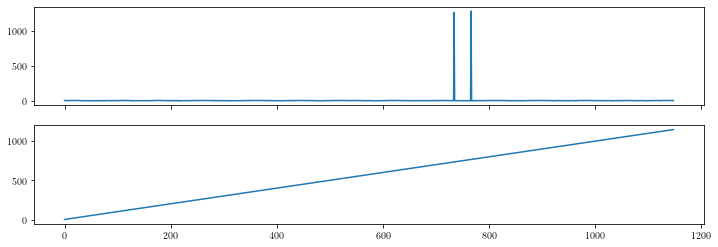

In [66]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
axes[0].plot(X)
axes[1].plot(score_list_adwin_j)
plt.show()

In [67]:
from math import log, sqrt, fabs

import os, sys
#sys.path.append('./')

"""
Within one bucket row, each bucket contains same number of original data.
New buckets are added at the end of bucket row.
When old buckets need to be removed, they are taken from the head of this bucket row.
"""


class AdwinBucketRow:
    def __init__(self, max_buckets=5, next_bucket_row=None, previous_bucket_row=None):
        """
        :param max_buckets: Max bucket with one row
        :param next_bucket_row: Following bucket row
        :param previous_bucket_row: Previous bucket row
        """
        self.max_buckets = max_buckets

        # Current count of buckets in this bucket row
        self.bucket_count = 0

        self.next_bucket_row = next_bucket_row
        # Set previous bucket row connect to this bucket row
        if next_bucket_row is not None:
            next_bucket_row.previous_bucket_row = self

        self.previous_bucket_row = previous_bucket_row
        # Set next bucket connect to this bucket
        if previous_bucket_row is not None:
            previous_bucket_row.next_bucket_row = self

        # Init statistic number for each bucket
        self.bucket_sum = np.zeros(self.max_buckets + 1)
        self.bucket_variance = np.zeros(self.max_buckets + 1)

    def insert_bucket(self, value, variance):
        """
        Insert a new bucket at the end.
        """
        self.bucket_sum[self.bucket_count] = value
        self.bucket_variance[self.bucket_count] = variance
        self.bucket_count += 1

    def compress_bucket(self, number_deleted):
        """
        Remove the oldest buckets.
        """
        delete_index = self.max_buckets - number_deleted + 1
        self.bucket_sum[:delete_index] = self.bucket_sum[number_deleted:]
        self.bucket_sum[delete_index:] = np.zeros(number_deleted)

        self.bucket_variance[:delete_index] = self.bucket_variance[number_deleted:]
        self.bucket_variance[delete_index:] = np.zeros(number_deleted)

        self.bucket_count -= number_deleted

"""
List of bucket rows.
Add new bucket row at head of window, remove old bucket row from tail of window.
"""

class AdwinRowBucketList:
    def __init__(self, max_buckets=5):
        """
        :param max_buckets: Max number of bucket in each bucket row
        """
        self.max_buckets = max_buckets

        self.count = 0
        self.head = None
        self.tail = None
        self.__add_to_head()

    def __add_to_head(self):
        """
        Init bucket row list.
        """
        self.head = AdwinBucketRow(self.max_buckets, next_bucket_row=self.head)
        if self.tail is None:
            self.tail = self.head
        self.count += 1

    def add_to_tail(self):
        """
        Add the bucket row at the end of the window.
        """
        self.tail = AdwinBucketRow(self.max_buckets, previous_bucket_row=self.tail)
        if self.head is None:
            self.head = self.tail
        self.count += 1

    def remove_from_tail(self):
        """
        Remove the last bucket row in the window.
        """
        self.tail = self.tail.previous_bucket_row
        if self.tail is None:
            self.head = None
        else:
            self.tail.next_bucket_row = None
        self.count -= 1

class AdWin:
    def __init__(self, delta=0.002, max_buckets=5, min_clock=32, min_win_len=10, min_sub_win_len=5):
        """
        :param delta: Confidence value
        :param max_buckets: Max number of buckets within one bucket row
        :param min_clock: Min number of new data for starting to reduce window and detect change
        :param min_win_len: Min window length for starting to reduce window and detect change
        :param min_sub_win_len: Min sub-window length, which is split from whole window
        """
        self.delta = delta
        self.max_buckets = max_buckets
        self.min_clock = min_clock
        self.min_win_len = min_win_len
        self.min_sub_win_len = min_sub_win_len

        # Time is used for comparison with min_clock parameter
        self.time = 0
        # Current window length
        self.window_len = 0
        # Sum of all values in the window
        self.window_sum = 0.0
        # Variance of all values in the window
        self.window_variance = 0.0

        # Count of bucket row within window
        self.bucket_row_count = 0
        # Init bucket list
        self.bucket_row_list = AdwinRowBucketList(self.max_buckets)

    def set_input(self, value):
        """
        Main method for adding a new data value and automatically detect a possible concept drift.
        :param value: new data value
        :return: true if there is a concept drift, otherwise false
        """
        self.time += 1

        # Insert the new element
        self.__insert_element(value)

        # Reduce window
        return self.__reduce_window()

    def __insert_element(self, value):
        """
        Create a new bucket, and insert it into bucket row which is the head of bucket row list.
        Meanwhile, this bucket row maybe compressed if reaches the maximum number of buckets.
        :param value: New data value from the stream
        """
        # Insert the new bucket
        self.bucket_row_list.head.insert_bucket(value, 0)

        # Calculate the incremental variance
        incremental_variance = 0
        if self.window_len > 0:
            mean = self.window_sum / self.window_len
            incremental_variance = self.window_len * pow(value - mean, 2) / (self.window_len + 1)

        # Update statistic value
        self.window_len += 1
        self.window_variance += incremental_variance
        self.window_sum += value

        # Compress buckets if necessary
        self.__compress_bucket_row()

    def __compress_bucket_row(self):
        """
        If reaches maximum number of buckets, then merge two buckets within one row into a next bucket row.
        """
        bucket_row = self.bucket_row_list.head
        bucket_row_level = 0
        while bucket_row is not None:
            # Merge buckets if row is full
            if bucket_row.bucket_count == self.max_buckets + 1:
                next_bucket_row = bucket_row.next_bucket_row
                if next_bucket_row is None:
                    # Add new bucket row and move to it
                    self.bucket_row_list.add_to_tail()
                    next_bucket_row = bucket_row.next_bucket_row
                    self.bucket_row_count += 1

                # Calculate number of bucket which will be compressed into next bucket row
                n_1 = pow(2, bucket_row_level)
                n_2 = pow(2, bucket_row_level)
                # Mean
                mean_1 = bucket_row.bucket_sum[0] / n_1
                mean_2 = bucket_row.bucket_sum[1] / n_2
                # Total
                next_total = bucket_row.bucket_sum[0] + bucket_row.bucket_sum[1]
                # Variance
                external_variance = n_1 * n_2 * pow(mean_1 - mean_2, 2) / (n_1 + n_2)
                next_variance = bucket_row.bucket_variance[0] + bucket_row.bucket_variance[1] + external_variance

                # Insert into next bucket row, meanwhile remove two original buckets
                next_bucket_row.insert_bucket(next_total, next_variance)

                # Compress those tow buckets
                bucket_row.compress_bucket(2)

                # Stop if the number of bucket within one row, which does not exceed limited
                if next_bucket_row.bucket_count <= self.max_buckets:
                    break
            else:
                break

            # Move to next bucket row
            bucket_row = bucket_row.next_bucket_row
            bucket_row_level += 1

    def __reduce_window(self):
        """
        Detect a change from last of each bucket row, reduce the window if there is a concept drift.
        :return: boolean: Whether has changed
        """
        is_changed = False
        if self.time % self.min_clock == 0 and self.window_len > self.min_win_len:
            is_reduced_width = True
            while is_reduced_width:
                is_reduced_width = False
                is_exit = False
                n_0, n_1 = 0, self.window_len
                sum_0, sum_1 = 0, self.window_sum

                # Start building sub windows from the tail of window (old bucket row)
                bucket_row = self.bucket_row_list.tail
                i = self.bucket_row_count
                while (not is_exit) and (bucket_row is not None):
                    for bucket_num in range(bucket_row.bucket_count):
                        # Iteration of last bucket row, or last bucket in one row
                        if i == 0 and bucket_num == bucket_row.bucket_count - 1:
                            is_exit = True
                            break

                        # Grow sub window 0, while reduce sub window 1
                        n_0 += pow(2, i)
                        n_1 -= pow(2, i)
                        sum_0 += bucket_row.bucket_sum[bucket_num]
                        sum_1 -= bucket_row.bucket_sum[bucket_num]
                        diff_value = (sum_0 / n_0) - (sum_1 / n_1)

                        # Minimum sub window length is matching
                        if n_0 > self.min_sub_win_len + 1 and n_1 > self.min_sub_win_len + 1:
                            # Remove oldest bucket if there is a concept drift
                            if self.__reduce_expression(n_0, n_1, diff_value):
                                is_reduced_width, is_changed = True, True
                                if self.window_len > 0:
                                    n_0 -= self.__delete_element()
                                    is_exit = True
                                    break

                    # Move to previous bucket row
                    bucket_row = bucket_row.previous_bucket_row
                    i -= 1
        return is_changed

    def __reduce_expression(self, n_0, n_1, diff_value):
        """
        Calculate epsilon cut value.
        :param n_0: number of elements in sub window 0
        :param n_1: number of elements in sub window 1
        :param diff_value: difference of mean values of both sub windows
        :return: true if difference of mean values is higher than epsilon_cut
        """
        # Harmonic mean of n0 and n1
        m = 1 / (n_0 - self.min_sub_win_len + 1) + 1 / (n_1 - self.min_sub_win_len + 1)
        d = log(2 * log(self.window_len) / self.delta)
        variance_window = self.window_variance / self.window_len
        epsilon_cut = sqrt(2 * m * variance_window * d) + 2 / 3 * m * d
        return fabs(diff_value) > epsilon_cut

    def __delete_element(self):
        """
        Remove a bucket from tail of bucket row.
        :return: Number of elements to be deleted
        """
        bucket_row = self.bucket_row_list.tail
        deleted_number = pow(2, self.bucket_row_count)
        self.window_len -= deleted_number
        self.window_sum -= bucket_row.bucket_sum[0]

        deleted_bucket_mean = bucket_row.bucket_sum[0] / deleted_number
        inc_variance = bucket_row.bucket_variance[0] + deleted_number * self.window_len * pow(
            deleted_bucket_mean - self.window_sum / self.window_len, 2
        ) / (deleted_number + self.window_len)

        self.window_variance -= inc_variance

        # Delete bucket from bucket row
        bucket_row.compress_bucket(1)
        # If bucket row is empty, remove it from the tail of window
        if bucket_row.bucket_count == 0:
            self.bucket_row_list.remove_from_tail()
            self.bucket_row_count -= 1

        return deleted_number


In [68]:
X = X_list[0][:, 1]

adwin = AdWin(delta=0.3)
score_list_adwin_j = []
for t, x in enumerate(X):
    prev_lenwin = adwin.window_len
    if adwin.set_input(x):
        post_lenwin = adwin.window_len
        score = prev_lenwin - post_lenwin + 1
        score_list_adwin_j.append(score)
    else:
        score_list_adwin_j.append(1.0)
    
#score_list_adwin_j = np.hstack((np.nan, np.abs(np.diff(score_list_adwin_j))))

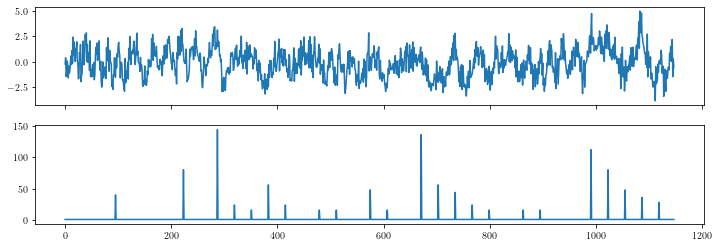

In [69]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
axes[0].plot(X)
axes[1].plot(score_list_adwin_j)
plt.show()

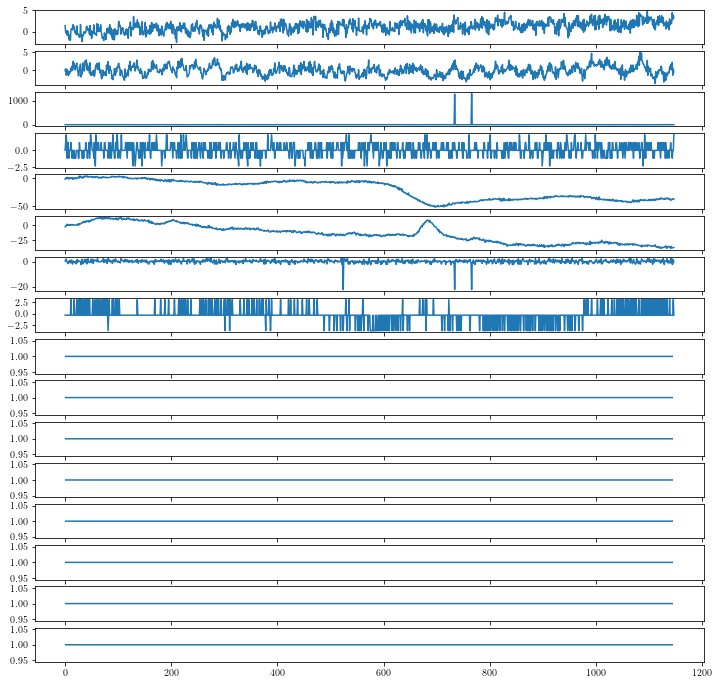

In [70]:
fig, axes = plt.subplots(2*X_list[0].shape[1], 1, sharex=True, figsize=(12, 12))
for j in range(X_list[0].shape[1]):
    axes[j].plot(X_list[0][:, j])

for j in range(X_list[0].shape[1]):
    axes[j+X_list[0].shape[1]].plot(score_list_adwin[j])
plt.show()

In [71]:
delta_list_adwin=[0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

score_start = 0
score_end = None

res_adwin = []

for n, (X, idxes_change) in enumerate(zip(X_list, idxes_change_list)):
    for i, delta in enumerate(delta_list_adwin):
        #print(f"delta = {delta}")
        score_list_adwin = []

        #time_start = time.time()

        """
        adwin = ADWIN(delta=delta)
        for t, x in enumerate(X.ravel()):
            adwin.add_element(x)

            score_list_adwin.append(adwin._width)

            #if adwin.detected_change():
            #    score = 1.0
            #else:
            #    score = 0.0
            #   
            #score_list_adwin.append(score)

        #time_end = time.time()
        #time_adwin_each.append(time_end - time_start)

        score_list_adwin = np.hstack((np.nan, np.abs(np.diff(score_list_adwin))))
        """
        auc_all = []
        for j in range(X.shape[1]):
            adwin = AdWin(delta=delta)
            score_list_adwin_j = []
            for t, x in enumerate(X[:, j]):
                prev_lenwin = adwin.window_len
                if adwin.set_input(x):
                    post_lenwin = adwin.window_len
                    score = prev_lenwin - post_lenwin + 1
                    score_list_adwin_j.append(score)
                else:
                    score_list_adwin_j.append(1.0)
            score_list_adwin_j = np.hstack((np.nan, np.abs(np.diff(score_list_adwin_j))))

            #ev, former, latter, total = calc_metrics(np.vstack(score_list_adwin), mu1, mu2, eval_start, eval_end, burnin)
            #auc_ = calc_auc_main(score_list_adwin, cps, start, end, T, N_thr)
            auc_j_ = calc_auc_main(score_list_adwin_j, idxes_change, start=100, end=X.shape[0],  
                                   T=T_auc, N_thr=100)
            auc_all.append(auc_j_)
            
        #auc_ = np.max(auc_all)
        #auc_adwin[trial, i] = auc_
        res_adwin.append([n, delta] +  auc_all)


In [72]:
res_adwin_df = pd.DataFrame(res_adwin, columns=['n', 'delta', 'auc1', 'auc2', 'auc3', 'auc4', 'auc5', 'auc6', 'auc7', 'auc8'])

In [73]:
res_adwin_df

,n,delta,auc1,auc2,auc3,auc4,auc5,auc6,auc7,auc8
0,0,0.001,0.507102,0.519889,0.498969,0.500000,0.489468,0.491259,0.500000,0.519097
1,0,0.002,0.506098,0.493814,0.497938,0.500000,0.512375,0.489278,0.500000,0.519097
2,0,0.005,0.505909,0.492784,0.496907,0.500000,0.512352,0.489278,0.500000,0.518113
3,0,0.010,0.505800,0.491753,0.493814,0.500000,0.511755,0.510568,0.500000,0.518018
4,0,0.020,0.491753,0.512530,0.491753,0.500000,0.512325,0.487649,0.500000,0.519001
5,0,0.050,0.491753,0.510325,0.489691,0.500000,0.512345,0.485317,0.498969,0.531170
6,0,0.100,0.493814,0.483505,0.487629,0.500000,0.512495,0.507160,0.497938,0.517780
7,0,0.200,0.491753,0.506773,0.485567,0.500000,0.512427,0.506121,0.521063,0.514544
8,0,0.500,0.487629,0.479381,0.507423,0.500000,0.507325,0.505307,0.520032,0.525349
9,1,0.001,0.496898,0.515668,0.498966,0.500000,0.486840,0.510517,0.500000,0.492761


In [74]:
res_adwin_train_df = res_adwin_df.loc[res_adwin_df['n'] %2 == 0, :]
res_adwin_test_df = res_adwin_df.loc[res_adwin_df['n'] %2 == 1, :]

In [75]:
res_adwin_train_df.groupby('delta')[['auc1', 'auc2', 'auc3', 'auc4', 'auc5', 'auc6', 'auc7', 'auc8']].agg(['mean', 'std'])

auc1                auc2                auc3                auc4  \
           mean       std      mean       std      mean       std      mean   
delta                                                                         
0.001  0.499070  0.003922  0.500403  0.011876  0.502104  0.008020  0.500000   
0.002  0.498941  0.003403  0.500274  0.011481  0.501708  0.008212  0.500000   
0.005  0.508994  0.014468  0.499468  0.011459  0.500416  0.008821  0.500000   
0.010  0.501273  0.008161  0.499467  0.009694  0.498997  0.009187  0.500000   
0.020  0.501743  0.009257  0.499315  0.009862  0.499870  0.009863  0.500000   
0.050  0.501828  0.016055  0.502253  0.008422  0.496561  0.009878  0.500000   
0.100  0.495252  0.002210  0.497017  0.010852  0.491733  0.007668  0.500000   
0.200  0.493531  0.002796  0.500171  0.009643  0.493791  0.009946  0.500000   
0.500  0.498328  0.010618  0.495159  0.012124  0.494730  0.011116  0.499721   

                     auc5                auc6                auc7            \
            std      mean       std      mean       std      mean       std   
delta                                                                         
0.001  0.000000  0.499275  0.011435  0.499908  0.012254  0.500000  0.000000   
0.002  0.000000  0.501982  0.011411  0.503526  0.013325  0.500000  0.000000   
0.005  0.000000  0.502943  0.007016  0.501374  0.014710  0.500000  0.000000   
0.010  0.000000  0.504925  0.009105  0.503558  0.013642  0.500000  0.000000   
0.020  0.000000  0.507315  0.007519  0.499522  0.015205  0.500000  0.000000   
0.050  0.000000  0.509729  0.008577  0.498009  0.012808  0.499871  0.000364   
0.100  0.000000  0.509799  0.008425  0.500366  0.013174  0.499613  0.000768   
0.200  0.000000  0.505705  0.010313  0.504594  0.008730  0.504839  0.010277   
0.500  0.000788  0.504349  0.010237  0.504045  0.007654  0.504056  0.010467   

           auc8            
           mean       std  
delta                      
0.001  0.497652  0.008871  
0.002  0.497651  0.008928  
0.005  0.497399  0.008662  
0.010  0.496864  0.008711  
0.020  0.496988  0.009067  
0.050  0.499352  0.013075  
0.100  0.497142  0.008858  
0.200  0.499675  0.011033  
0.500  0.506116  0.012176

In [76]:
res_adwin_test_df.groupby('delta')[['auc1', 'auc2', 'auc3', 'auc4', 'auc5', 'auc6', 'auc7', 'auc8']].agg(['mean', 'std'])

auc1                auc2                auc3                auc4  \
           mean       std      mean       std      mean       std      mean   
delta                                                                         
0.001  0.497663  0.001322  0.503900  0.011406  0.499088  0.001031  0.500000   
0.002  0.497268  0.001747  0.504080  0.011053  0.501300  0.007528  0.500000   
0.005  0.499864  0.007328  0.499509  0.008758  0.500024  0.008718  0.500000   
0.010  0.500618  0.010691  0.499149  0.008687  0.499376  0.008607  0.500000   
0.020  0.506396  0.013771  0.498335  0.008400  0.500953  0.009524  0.500000   
0.050  0.505087  0.012890  0.499708  0.010075  0.504530  0.011260  0.500000   
0.100  0.503612  0.011170  0.498310  0.012130  0.502336  0.008789  0.500000   
0.200  0.500623  0.008230  0.498933  0.011863  0.503969  0.009383  0.499871   
0.500  0.500841  0.009494  0.503129  0.012207  0.501002  0.008046  0.500963   

                     auc5                auc6                auc7            \
            std      mean       std      mean       std      mean       std   
delta                                                                         
0.001  0.000000  0.501083  0.009565  0.500889  0.009763  0.500000  0.000000   
0.002  0.000000  0.499818  0.015597  0.499240  0.011525  0.500000  0.000000   
0.005  0.000000  0.508304  0.011591  0.500416  0.010465  0.500000  0.000000   
0.010  0.000000  0.506758  0.010705  0.499945  0.007509  0.500000  0.000000   
0.020  0.000000  0.507910  0.010646  0.505655  0.006511  0.500000  0.000000   
0.050  0.000000  0.505060  0.012248  0.501238  0.012574  0.499864  0.000386   
0.100  0.000000  0.504935  0.012493  0.503803  0.009235  0.499734  0.000493   
0.200  0.000364  0.504462  0.011749  0.503036  0.008629  0.499212  0.000937   
0.500  0.004036  0.503594  0.014795  0.506841  0.007224  0.498689  0.000964   

           auc8            
           mean       std  
delta                      
0.001  0.505668  0.011259  
0.002  0.504144  0.010890  
0.005  0.505497  0.013151  
0.010  0.505252  0.012974  
0.020  0.502382  0.008434  
0.050  0.508250  0.013154  
0.100  0.512808  0.013876  
0.200  0.510078  0.015401  
0.500  0.507903  0.015211

# KSWIN

In [77]:
alpha_list_kswin = [0.001, 0.005, 0.01]
window_size_list_kswin = [20, 30]
stat_size_list_kswin = [10, 15]

res_kswin = []

for n, (X, idxes_change) in tqdm.tqdm(enumerate(zip(X_list, idxes_change_list))):
    for i, alpha in enumerate(alpha_list_kswin):
        for j, window_size in enumerate(window_size_list_kswin):
            for k, stat_size in enumerate(stat_size_list_kswin):
                auc_all = []
                for l in range(X.shape[1]):
                    kswin = KSWIN(alpha=alpha, window_size=window_size, stat_size=stat_size)
                    score_list_kswin_l = []
                    for t, x in enumerate(X[:, l]):
                        kswin.add_element(x)

                        #if kswin.detected_change():
                        #    score = 1.0
                        #else:
                        #    score = 0.0
                        currentLength = kswin.window.shape[0]
                        if currentLength >= kswin.window_size:
                            window = np.delete(kswin.window, 0)
                            rnd_window = np.random.choice(kswin.window[:stat_size], stat_size)

                            (st, p_value) = ks_2samp(rnd_window, kswin.window[-stat_size:], mode="exact")

                            score = 1.0 - p_value
                        else:
                            score = 0.0

                        score_list_kswin_l.append(score)

                    auc_l_ = calc_auc_main(score_list_kswin_l, idxes_change, start=100, end=X.shape[0],  
                                           T=T_auc, N_thr=100)
                    auc_all.append(auc_l_)

                #auc_ = np.max(auc_all)
                res_kswin.append([n, alpha, window_size, stat_size] + auc_all)

0it [00:00, ?it/s]/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)
16it [07:22, 27.66s/it]


In [78]:
res_kswin_df = pd.DataFrame(res_kswin, columns=['n', 'alpha', 'window_size', 'stat_size'] + ['auc%d' % (j+1) for j in range(X.shape[1])])

In [79]:
res_kswin_train_df = res_kswin_df.loc[res_kswin_df['n'] %2 == 0, :]
res_kswin_test_df = res_kswin_df.loc[res_kswin_df['n'] %2 == 1, :]

In [80]:
res_kswin_train_df.groupby(['alpha', 'window_size', 'stat_size'])[['auc1', 'auc2', 'auc3', 'auc4', 'auc5', 'auc6', 'auc7', 'auc8']].agg(['mean', 'std'])

auc1                auc2                auc3  \
                                 mean       std      mean       std      mean   
alpha window_size stat_size                                                     
0.001 20          10         0.544655  0.085661  0.504985  0.078216  0.512484   
                  15         0.508394  0.035282  0.487444  0.044475  0.545010   
      30          10         0.551785  0.093616  0.460969  0.094073  0.507476   
                  15         0.509811  0.071839  0.509138  0.110204  0.549020   
0.005 20          10         0.513117  0.054640  0.472763  0.089751  0.525200   
                  15         0.497144  0.056943  0.458765  0.034890  0.539796   
      30          10         0.439061  0.084341  0.401373  0.094543  0.573307   
                  15         0.480915  0.053908  0.479136  0.103762  0.569773   
0.010 20          10         0.488585  0.099625  0.462347  0.043588  0.552284   
                  15         0.495127  0.069279  0.476532  0.036854  0.531957   
      30          10         0.484756  0.156946  0.484283  0.160383  0.538687   
                  15         0.500948  0.107789  0.483045  0.063930  0.605342   

                                           auc4                auc5            \
                                  std      mean       std      mean       std   
alpha window_size stat_size                                                     
0.001 20          10         0.066789  0.530522  0.065561  0.482185  0.082458   
                  15         0.053637  0.513447  0.037245  0.490378  0.051386   
      30          10         0.061006  0.480698  0.070325  0.414936  0.093719   
                  15         0.081750  0.489714  0.065886  0.456267  0.074163   
0.005 20          10         0.040509  0.515719  0.075729  0.458879  0.077891   
                  15         0.054762  0.511531  0.065884  0.473554  0.031022   
      30          10         0.090658  0.513330  0.076079  0.438037  0.080240   
                  15         0.114741  0.501578  0.058290  0.491236  0.090985   
0.010 20          10         0.061561  0.491038  0.059801  0.456378  0.054558   
                  15         0.049648  0.507621  0.036213  0.485323  0.037996   
      30          10         0.093949  0.484061  0.069005  0.447577  0.075751   
                  15         0.103633  0.466153  0.043754  0.450861  0.046917   

                                 auc6                auc7                auc8  \
                                 mean       std      mean       std      mean   
alpha window_size stat_size                                                     
0.001 20          10         0.528798  0.073037  0.496296  0.054355  0.530875   
                  15         0.504693  0.053057  0.496627  0.051779  0.550398   
      30          10         0.539389  0.116514  0.513270  0.064297  0.566571   
                  15         0.556715  0.137075  0.529156  0.061090  0.567282   
0.005 20          10         0.521228  0.093513  0.530061  0.060061  0.530125   
                  15         0.539910  0.057631  0.480506  0.031244  0.531140   
      30          10         0.576279  0.120234  0.478908  0.094680  0.586065   
                  15         0.569274  0.118842  0.501248  0.078760  0.555184   
0.010 20          10         0.561679  0.129709  0.485025  0.103179  0.530893   
                  15         0.528695  0.036629  0.502813  0.034573  0.524945   
      30          10         0.522999  0.108436  0.511863  0.052378  0.540214   
                  15         0.515883  0.087928  0.481899  0.076714  0.569594   

                                       
                                  std  
alpha window_size stat_size            
0.001 20          10         0.121320  
                  15         0.073198  
      30          10         0.107215  
                  15         0.110189  
0.005 20          10         0.086342  
                  15         0.046919  
      30          10     

In [81]:
res_kswin_test_df.groupby(['alpha', 'window_size', 'stat_size'])[['auc1', 'auc2', 'auc3', 'auc4', 'auc5', 'auc6', 'auc7', 'auc8']].agg(['mean', 'std'])

auc1                auc2                auc3  \
                                 mean       std      mean       std      mean   
alpha window_size stat_size                                                     
0.001 20          10         0.525872  0.060170  0.494569  0.105688  0.457865   
                  15         0.502378  0.041155  0.508979  0.059886  0.466027   
      30          10         0.511855  0.078117  0.482288  0.074906  0.519437   
                  15         0.526990  0.071070  0.483669  0.081452  0.484045   
0.005 20          10         0.501207  0.061189  0.496834  0.093991  0.483563   
                  15         0.525616  0.048780  0.479334  0.036496  0.506365   
      30          10         0.530512  0.100070  0.502148  0.122200  0.493222   
                  15         0.507435  0.109012  0.464025  0.119457  0.477842   
0.010 20          10         0.504852  0.046314  0.517736  0.087933  0.489020   
                  15         0.486900  0.054184  0.482096  0.023246  0.509467   
      30          10         0.541746  0.106530  0.478629  0.163952  0.504986   
                  15         0.536536  0.053619  0.486688  0.079638  0.519563   

                                           auc4                auc5            \
                                  std      mean       std      mean       std   
alpha window_size stat_size                                                     
0.001 20          10         0.066633  0.525251  0.099377  0.465978  0.089739   
                  15         0.052710  0.544524  0.043317  0.476368  0.069981   
      30          10         0.129188  0.524664  0.052006  0.449854  0.119740   
                  15         0.071240  0.523967  0.099939  0.540144  0.107914   
0.005 20          10         0.087498  0.513569  0.081365  0.466056  0.073404   
                  15         0.046932  0.513572  0.038911  0.477763  0.057902   
      30          10         0.116292  0.531815  0.078033  0.492173  0.130420   
                  15         0.078682  0.514576  0.106405  0.517277  0.121956   
0.010 20          10         0.095623  0.530632  0.101879  0.477359  0.092790   
                  15         0.041661  0.532029  0.042606  0.482295  0.055227   
      30          10         0.109558  0.518798  0.067974  0.555488  0.116981   
                  15         0.050261  0.500127  0.070339  0.534703  0.120818   

                                 auc6                auc7                auc8  \
                                 mean       std      mean       std      mean   
alpha window_size stat_size                                                     
0.001 20          10         0.478099  0.075341  0.538713  0.035580  0.537103   
                  15         0.480256  0.031533  0.529039  0.049523  0.549681   
      30          10         0.481758  0.138359  0.513594  0.059048  0.549648   
                  15         0.470953  0.076387  0.507891  0.074590  0.566603   
0.005 20          10         0.507639  0.094280  0.474645  0.113783  0.543658   
                  15         0.499038  0.047672  0.492412  0.056992  0.553080   
      30          10         0.423900  0.066250  0.415932  0.075805  0.535699   
                  15         0.453767  0.065751  0.513303  0.063155  0.564362   
0.010 20          10         0.496793  0.092824  0.483746  0.080514  0.523184   
                  15         0.505491  0.033004  0.504158  0.059395  0.555349   
      30          10         0.424080  0.073449  0.532157  0.078378  0.524949   
                  15         0.477240  0.063354  0.480017  0.090511  0.519329   

                                       
                                  std  
alpha window_size stat_size            
0.001 20          10         0.061569  
                  15         0.040236  
      30          10         0.099827  
                  15         0.086868  
0.005 20          10         0.094046  
                  15         0.057119  
      30          10     

# Page-Hinkley

0 : 0.5546562821833162
1 : 0.34078398558187434
2 : 0.339802394438723
3 : 0.6927130535530381
4 : 0.25238027806385166
5 : 0.4098867147270855
6 : 0.7607241246138003
7 : 0.38368756436663237


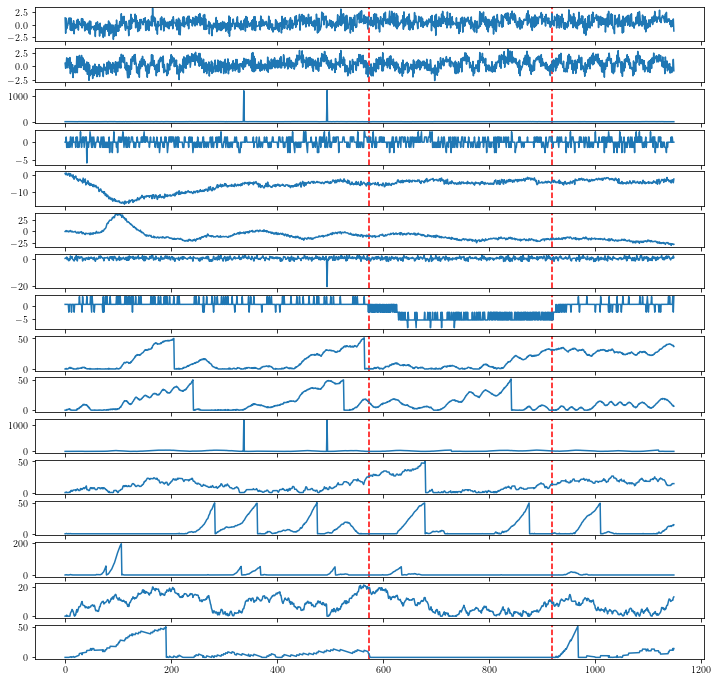

In [82]:
threshold = 0.01
alpha = 0.1

fig, axes = plt.subplots(X.shape[1]*2, 1, sharex=True, figsize=(12, 12))

X = X_list[3]
idxes_change = idxes_change_list[3]

for k in range(X.shape[1]):
    axes[k].plot(X[:, k])
    for idx in idxes_change:
        axes[k].axvline(idx, linestyle='dashed', color='red', zorder=1)

for k in range(X.shape[1]):
    ph = PageHinkley()
    score_list_ph_k = []
    for t, x in enumerate(X[:, k]):
        ph.add_element(x)
        score_t = ph.sum - threshold
        score_list_ph_k.append(score_t)

    axes[X.shape[1] + k].plot(score_list_ph_k)
    for idx in idxes_change:
        axes[X.shape[1] + k].axvline(idx, linestyle='dashed', color='red', zorder=1)
        
    auc_k_ = calc_auc_main(score_list_ph_k, idxes_change, start=100, end=X.shape[0],  
                           T=T_auc, N_thr=100)
    print(k, ':', auc_k_)
    #auc_all.append(auc_k_)

plt.show()

In [83]:
#threshold_list_ph = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
threshold_list_ph = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
alpha_list_ph = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999]

res_ph = []

for n, (X, idxes_change) in tqdm.tqdm(enumerate(zip(X_list, idxes_change_list))):
    for i, threshold in enumerate(threshold_list_ph):
        for j, alpha in enumerate(alpha_list_ph):
            auc_all = []
            for k in range(X.shape[1]):
                ph = PageHinkley()
                score_list_ph_k = []
                for t, x in enumerate(X[:, k]):
                    ph.add_element(x)
                    score_t = ph.sum - threshold
                    score_list_ph_k.append(score_t)

                auc_k_ = calc_auc_main(score_list_ph_k, idxes_change, start=100, end=X.shape[0],  
                                       T=T_auc, N_thr=100)
                auc_all.append(auc_k_)

            #auc_ = np.max(auc_all)
            res_ph.append([n, threshold, alpha] + auc_all)

16it [02:07,  7.98s/it]


In [84]:
res_ph_df = pd.DataFrame(res_ph, columns=['n', 'threshold', 'alpha'] + ['auc%d' % (j+1) for j in range(X.shape[1])])

In [90]:
res_ph_df.loc[res_ph_df['alpha'] == 0.1, :]

,n,threshold,alpha,auc1,auc2,auc3,auc4,auc5,auc6,auc7,auc8
0,0,0.01,0.1,0.426049,0.529878,0.501927,0.321716,0.480166,0.482990,0.189990,0.226575
8,0,0.05,0.1,0.426049,0.529878,0.501927,0.321716,0.480166,0.482990,0.189990,0.226575
16,0,0.10,0.1,0.426049,0.529878,0.501927,0.321716,0.480166,0.482990,0.189990,0.226575
24,0,0.50,0.1,0.426049,0.529878,0.501927,0.321716,0.480166,0.482990,0.189990,0.226575
32,0,1.00,0.1,0.426049,0.529878,0.501927,0.321716,0.480166,0.482990,0.189990,0.226575
40,0,5.00,0.1,0.426049,0.529878,0.501927,0.321716,0.480166,0.482990,0.189990,0.226575
48,0,10.00,0.1,0.426049,0.529878,0.501927,0.321716,0.480166,0.482990,0.189990,0.226575
56,1,0.01,0.1,0.219966,0.646688,0.263185,0.478256,0.593948,0.698599,0.428433,0.247901
64,1,0.05,0.1,0.219966,0.646688,0.263185,0.478256,0.593948,0.698599,0.428433,0.247901
72,1,0.10,0.1,0.219966,0.646688,0.263185,0.478256,0.593948,0.698599,0.428433,0.247901


In [86]:
res_ph_train_df = res_ph_df.loc[res_ph_df['n'] %2 == 0, :]
res_ph_test_df = res_ph_df.loc[res_ph_df['n'] %2 == 1, :]

In [87]:
res_ph_train_df.groupby(['threshold', 'alpha'])[['auc1', 'auc2', 'auc3', 'auc4', 'auc5', 'auc6', 'auc7', 'auc8']].agg(['mean', 'std'])

auc1                auc2                auc3            \
                     mean       std      mean       std      mean       std   
threshold alpha                                                               
0.01      0.100  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.300  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.500  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.700  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.900  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.950  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.990  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.999  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
0.05      0.100  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.300  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.500  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.700  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.900  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.950  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.990  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.999  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
0.10      0.100  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.300  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.500  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.700  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.900  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.950  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.990  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.999  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
0.50      0.100  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.300  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.500  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.700  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.900  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.950  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.990  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.999  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
1.00      0.100  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.300  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.500  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.700  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.900  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.950  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.990  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.999  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
5.00      0.100  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.300  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.500  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.700  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.900  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.950  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.990  0.466601  0.235301  0.432863  0.120417  0.538492  0.200398   
          0.999  0.466601  0.235301  0.432863  0.120417  0.538492  0.20

In [88]:
res_ph_test_df.groupby(['threshold', 'alpha'])[['auc1', 'auc2', 'auc3', 'auc4', 'auc5', 'auc6', 'auc7', 'auc8']].agg(['mean', 'std'])

auc1                auc2                auc3            \
                     mean       std      mean       std      mean       std   
threshold alpha                                                               
0.01      0.100  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.300  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.500  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.700  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.900  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.950  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.990  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.999  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
0.05      0.100  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.300  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.500  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.700  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.900  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.950  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.990  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.999  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
0.10      0.100  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.300  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.500  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.700  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.900  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.950  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.990  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.999  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
0.50      0.100  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.300  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.500  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.700  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.900  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.950  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.990  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.999  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
1.00      0.100  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.300  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.500  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.700  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.900  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.950  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.990  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.999  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
5.00      0.100  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.300  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.500  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.700  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.900  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.950  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.990  0.468562  0.200513  0.580429  0.203975  0.421965  0.115599   
          0.999  0.468562  0.200513  0.580429  0.203975  0.421965  0.11

# R-FPOP

In [89]:
X = X_list[4]
idxes_change = idxes_change_list[4]

numpy2ri.activate()

res = robseg.multiBinSeg(np.array(X),  
                         10)
                         #loss="Outlier", 
                         #loss="Huber",
                         #lam=1.4*np.log(len(X.ravel())), 
                         #lthreshold=3)
                         #lam=50000.0,
                         #lthreshold=0.01)
                         #lam=10000.0,
                         #lam=1000.0,
                         #lam = 1000.0, 
                         #lthreshold=0.01
                         #lthreshold=10.0)

numpy2ri.deactivate()

scores = np.zeros(X.shape[0])
cps_detected = np.array(dollar(res, "t.est"))[:-1] - 1
scores[cps_detected] = 1.0

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [ ]:
cps_detected

In [ ]:
fig, axes = plt.subplots(X.shape[1]+1, 1, sharex=True, figsize=(12, 12))

for k in range(X.shape[1]):
    axes[k].plot(X[:, k])
    for idx in idxes_change:
        axes[k].axvline(idx, linestyle='dashed', color='red', zorder=1)

axes[-1].plot(scores)
plt.show()